In [50]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### EY analysis for a IIIV-Si 4T tandem for the location in Golden



In [51]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pvcircuit as pvc
from pvcircuit.PlotWithControls import PlotsWithControls
import ipywidgets as widgets
from scipy import constants
from scipy.optimize import curve_fit, fsolve
from scipy.special import erfc
from scipy.interpolate import interp1d

from IPython import display

from pvcircuit.physics_helpers import fit_sandia_simple
from pvlib.pvsystem import singlediode
from pvlib.ivtools.utils import rectify_iv_curve
from pvlib import irradiance, solarposition
import pvlib.location as pvloc

import os
import sys

from glob import glob
from datetime import datetime
from tqdm.notebook import trange

# set path for NREL meteorological package and import
sys.path.append("../../NREL_Meteorological")
from environmental import Spectra, Meteorological, sync
import warnings
from scipy.optimize import OptimizeWarning
from itertools import cycle
from matplotlib.lines import Line2D
import pickle

from dataeval.iv_factory import IVCollection, IVType, SweepDirection, IVData, IVLight
from dataeval.qe_factory import EQECollection, EQEData
import re

from sklearn import linear_model

In [52]:
warnings.simplefilter("ignore", OptimizeWarning)


In [53]:
def get_figsize(width_pt=396, fraction = 1, ratio=(5**.5 - 1) / 2, rows=1, cols=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you set in latex
     ratio: float, optional
            Golden ratio to set aesthetic figure height
            https://disq.us/p/2940ij3
            golden_ratio = (5**.5 - 1) / 2
    rows: subplot rows
    cols: subplot cols
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27



    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * ratio * (rows / cols)

    return (fig_width_in, fig_height_in)


In [54]:
# For IEEE
# FIG_WIDTH = 396
# FIG_WIDTH = 522
# FIG_WIDTH = 252

# For RRL
FIG_WIDTH = 542.02501

In [55]:
# style_path = r"C:\Users\rwitteck\.matplotlib\mystyles\mystyle.mplstyle"
# mpl.use('pgf')
mpl.style.reload_library()
plt.style.use('default')
# plt.style.use('mystyle')



In [56]:
# mpl.rc("figure",figsize=get_figsize(FIG_WIDTH))
fig_onecol = get_figsize(FIG_WIDTH, fraction = 0.85, ratio=1,rows=1,cols=1)
fig_twocol = get_figsize(FIG_WIDTH, fraction = 1, ratio=1,rows=1,cols=2)
fig_threecol = get_figsize(FIG_WIDTH, fraction = 1, ratio=1,rows=1,cols=3)

fig_settings = {
    # "figure.figsize":get_figsize(396),
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    # Use 9pt font arial in plots, to match 10pt font in document latex CM
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "axes.linewidth": 1.5,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "xtick.major.width": 1.5,
    "xtick.minor.width": 1.3,
    "ytick.major.width": 1.5,
    "ytick.minor.width": 1.3,
    "ytick.labelsize": 8,
    "pgf.texsystem": "lualatex",
    "savefig.transparent": True,
    "pgf.rcfonts": False,     # don't setup fonts from rc parameters,
    'pgf.preamble': "\n".join([
        #  r"\usepackage[T1]{fontenc}",   # unicode math setup
        #  r"\usepackage[utf8x]{inputenc}",  # serif font via preamble
    ]),
}

plt.rcParams.update(fig_settings)

Helpers


In [57]:

def wavelength_to_photonenergy(wavelength):
    return constants.h * constants.c / (wavelength * 1e-9) / constants.e


def photonenergy_to_wavelength(photonenergy):
    return constants.h * constants.c / (photonenergy * 1e-9) / constants.e


def _normalize(eqe: pd.DataFrame) -> pd.DataFrame:
    eqe_min = np.nanmin(eqe)
    eqe_max = np.nanmax(eqe)
    return (eqe - eqe_min) / (eqe_max - eqe_min)


def _eq_solve_Eg(Eg, *data):
    x, y = data
    return np.trapz(x * y, x) / np.trapz(y, x) - Eg


def _gaussian(x, a, x0, sigma):
    return 1 * np.exp(-((x - x0) ** 2) / (2 * sigma**2))

def calc_ape(ape_spectra):
    phi = ape_spectra * (ape_spectra.columns.astype(np.float64) * 1e-9) / constants.h / constants.c
    ape = pd.Series(np.trapz(x=ape_spectra.columns.astype(np.float64), y=ape_spectra) / constants.e / np.trapz(x=ape_spectra.columns.astype(np.float64), y=phi.values), index = ape_spectra.index)
    return ape

def calc_Eg_Rau(eqe, fit_gaussian=True):
    # using [1] U. Rau, B. Blank, T. C. M. Müller, and T. Kirchartz,
    # “Efficiency Potential of Photovoltaic Materials and Devices Unveiled by Detailed-Balance Analysis,”
    # Phys. Rev. Applied, vol. 7, no. 4, p. 044016, Apr. 2017, doi: 10.1103/PhysRevApplied.7.044016.
    # extended by gaussian fit

    # Define the Gaussian function
    wavelength = eqe.index.values
    y = eqe.values
    x = wavelength_to_photonenergy(wavelength)

    # use negative gradient - all positive max area declining EQE signal
    y_grad = -1 * np.gradient(y)

    # filter tail to avoid eqe dips at end/beginning of measurement
    # y_grad = y_grad[(x < x[len(x) // 2])]
    # x = x[(x < x[len(x) // 2])]
    data_filter = (x < (x.max() + x.min()) / 2)
    x = x[data_filter]
    y = y[data_filter]
    y_grad = y_grad[data_filter]

    # we only need declining EQE to determine bandgaps
    data_filter = y_grad > 0
    x = x[data_filter]
    y = y[data_filter]
    y_grad = y_grad[data_filter]

    # convert wavelength to photon energy
    # y_grad = np.abs(np.gradient(y.values))
    # y_grad = np.abs(np.diff(y.values, prepend=np.nan))
    # y_grad = y.diff().abs().values

    # normalize data
    y_grad = _normalize(y_grad)
    # get the index of the maximas
    y_diff_max_idx = np.argsort(y_grad)
    # check if there are more than one maxima above 0.95 and take the one with the lowest energy
    y_diff_max_idx = y_diff_max_idx[y_grad[y_diff_max_idx] > 0.95]
    if len(y_diff_max_idx) > 1:
        x_for_max_sort = x[y_diff_max_idx]
        x_for_max_sort_idx = np.argsort(x_for_max_sort)
        y_diff_max_idx = y_diff_max_idx[x_for_max_sort_idx[0]]

    # get the max coordinates
    x_diff_max = x[y_diff_max_idx]
    y_diff_max = y_grad[y_diff_max_idx]

    # define lower threshold
    p_ab = np.exp(-2) * y_diff_max
    # find the index of the low-energy side where P(a) is max(P(Eg)/2)
    a_idx = np.where((y_grad < p_ab) & (x < x_diff_max))[0]
    if len(a_idx) > 0:
        a_idx = np.nanmin(a_idx)
    else:
        a_idx = -1

    a = x[a_idx]
    p_a = y_grad[a_idx]
    # find the index of the high-energy side where P(b) is max(P(Eg)/2)
    b_idx = np.nanmax(np.where((y_grad < p_ab) & (x > x_diff_max))[0])
    b = x[b_idx]
    p_b = y_grad[b_idx]

    x_target = x[a_idx : b_idx - 1 : -1]
    y_target = y_grad[a_idx : b_idx - 1 : -1]

    if fit_gaussian:

        # initial guesses from weighted arithmetic mean and weighted sample sigma
        mean = sum(x_target * y_target) / sum(y_target)
        sigma = np.sqrt(sum(y_target * (x_target - mean) ** 2) / sum(y_target))

        fit_res = curve_fit(
            _gaussian,
            x_target,
            y_target,
            p0=[max(y_target), mean, sigma],
        )
        x_fit = np.linspace(x[b_idx], x[a_idx], 100)
        y_fit = _gaussian(x_fit, *fit_res[0])

        # plot the data and fit for bandgap
        # fig,ax = plt.subplots(1)
        # ax.plot(x, y)
        # ax.plot(x, y_grad)
        # ax.plot(x_fit, y_fit)
        # ax.plot(x_target, y_target, ".r")
        # ax.plot(x_diff_max, y_diff_max, "r*")
        # ax.plot(a, p_a, "g*")
        # ax.plot(b, p_b, "b*")
        # ax.set_ylabel(r"$\frac{{\mathrm{d}}EQE}{{\mathrm{d}}E_{\nu}}$")
        # ax.set_xlabel(r"Photon energy $E_{\nu}$ [eV]")

        # plot sigma broadening
        # plt.plot(x_fit - fit_res[0][1], y_fit) # For sigma

        x_fit = x_fit[y_fit >= 0.5 * y_fit.max()]
        y_fit = y_fit[y_fit >= 0.5 * y_fit.max()]
        sigma = fit_res[0][2]
    else:
        fit_res = [None]
        x_fit = x_target
        y_fit = y_target
        sigma = None

    res = fsolve(_eq_solve_Eg, 1.0, args=(x_fit, y_fit))
    bandgap = res[0]

    return bandgap, sigma

# def si_eg_shift(temperature, bandgap_25):
#     # p = [-6.48857961e-04,  1.01634831e+00]
#     # p = [-6.67853208e-04,  1.04610179e+00]
#     p = [-6.00255651e-04,  1.01445219e+00]
#     # p = [-1.00255651e-04,  1.01445219e+00]
#     return (p[0] * temperature + p[1]) * bandgap_25

# def si_sigma_shift(temperature, sigma_25):
#     p = [0.00959188, 0.76558903]
#     return (p[0] * temperature + p[1])*sigma_25

# def tc_eg_shift(temperature, bandgap_25):
#     # use Varshni parameters where α and β are material constants and Eg (0) is the bandgap at 0 K
#     # GaAs (α = 0.5405 meV/K, β = 204K [23])
#     # alpha = 5.405e-4 #[eV/K]
#     # beta = 204 #[K]
#     alpha = 8.871e-4 #[eV/K]
#     beta = 572 #[K]
#     Eg0 = bandgap_25 + alpha * (constants.zero_Celsius + 25)**2 / ((constants.zero_Celsius + 25) + beta)
#     return Eg0 - alpha * (constants.zero_Celsius + temperature)**2 / ((constants.zero_Celsius + temperature) + beta)

def intergrate_eqe(eqe):
    path_to_am15_spectra = os.path.join(os.path.dirname(os.getcwd()), "data","ASTMG173.csv")  # Data files here
    # spectra = pd.read_csv(path_to_am15_spectra, header=[*range(0,3)])
    spectra_full = pd.read_csv(path_to_am15_spectra, header=[2])
    spectra_full.set_index(spectra_full.columns[0], inplace=True)

    spectra = spectra_full.reindex(eqe.index)
    if spectra.isnull().any(axis=1).any():
        spectra = spectra.reindex(index=eqe.index).interpolate(method="index")

    # jsc = (
    #     eqe.apply(lambda x: np.trapz(y=x * spectra["global"] / qe._wavelength_to_photonenergy(eqe.index), x=eqe.index)) / 10
    # )
    jsc = np.trapz(y=eqe.values * spectra["global"] / wavelength_to_photonenergy(eqe.index), x=eqe.index) / 10


    return jsc
    si_fit = np.polyfit(temperature_silicon, jsc[1:], 1)

    temps = np.linspace(min(temperature_silicon), max(temperature_silicon), 50)
    jsc_fit = np.polyval(si_fit, temps)

    fig, ax = plt.subplots(1)
    ax.plot(temperature_silicon, jsc[1:], "*", temps, jsc_fit)

# @numba.jit()
def shift_eqe(eqe_ref, bandgap_25, sigma_25, bandgaps, sigmas, spectra):

    eqe = eqe_ref.values
    lam = eqe_ref.index.values
    Ey = constants.h * constants.c / (lam * 1e-9) / constants.e  # [eV]

    # abs = 1 / 2 * erfc((bandgap_25 - Ey) / (sigma_25 * np.sqrt(2)))

    lam_eqe_saturation_idx = np.argmax(eqe * lam) - 2
    eqe_saturation = eqe[lam_eqe_saturation_idx]
    # lam_eqe_saturation = lam[lam_eqe_saturation_idx]

    # jscs = []
    # # fig,ax = plt.subplots()
    # for i, col in enumerate(bandgaps):
    #     # print(qe_data.temperature)
    #     spec = spectra.iloc[i][lam]
    #     bandgap = bandgaps[i]
    #     sigma = sigmas[i]
    #     abs = 1 / 2 * erfc((bandgap - Ey) / (sigma * np.sqrt(2))) * eqe_saturation
    #     eqe_filter = lam > photonenergy_to_wavelength(bandgap + 2*sigma)
    #     eqe_new = np.concatenate([eqe[~eqe_filter],abs[eqe_filter]])
    #     # ax.plot(eqe_new)
    #     jscs.append(np.trapz(y = eqe_new * spec / wavelength_to_photonenergy(spec.index), x = spec.index) / 10)

    if len(spectra) > 1:
        spec_interp_func = interp1d(spectra.index, spectra,axis=0)

        spectra_interp = pd.DataFrame(spec_interp_func(spectra.index.astype(np.float64)).astype(np.float64), index = spectra.index.astype(np.float64))

    else:
        spectra_interp = spectra.T

    bandgaps_arr = np.tile(bandgaps, [len(Ey), 1])
    sigmas_arr = np.tile(sigmas, [len(Ey), 1])
    erfc_arr = (bandgaps_arr - Ey.reshape(-1,1)) / (sigmas_arr * np.sqrt(2))
    vec_erfc = np.vectorize(erfc)
    abs_arr = vec_erfc(erfc_arr) * 0.5 * eqe_saturation
    eqe_filter = np.tile(lam,[len(bandgaps),1]).T > photonenergy_to_wavelength(bandgaps_arr + 2*sigmas_arr)
    eqe_new_arr = np.tile(eqe,[len(bandgaps),1]).T
    eqe_new_arr = eqe_new_arr * ~eqe_filter + abs_arr * eqe_filter
    jscs = np.trapz(y = eqe_new_arr * spectra_interp.values  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10
    # jscs = np.trapz(y = eqe_new_arr * spectra_interp.loc[lam].values.reshape(-1,1)  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10

    # print(f"check jscs = {all(jscs_arr == np.array(jscs))}")

    return jscs


# @numba.jit()
def shift_eqe_tcbc(tc_eqe_ref, tc_bandgap_25, tc_sigma_25, tc_bandgaps, tc_sigmas, bc_eqe_ref, bc_bandgap_25, bc_sigma_25, bc_bandgaps, bc_sigmas, spectra):

    vec_erfc = np.vectorize(erfc)
    tc_trans = None
    # in case values are percentages

    lam = tc_eqe_ref.index.values

    tc_eqe = tc_eqe_ref.values
    tc_Ey = constants.h * constants.c / (lam * 1e-9) / constants.e  # [eV]

    tc_lam_eqe_saturation_idx = np.argmax(tc_eqe * lam)
    tc_eqe_saturation = tc_eqe[tc_lam_eqe_saturation_idx]
    # using 25 degC EQE for saturation
    tc_eqe_saturation = tc_eqe_ref[lam > photonenergy_to_wavelength(tc_bandgap_25 + 2*tc_sigma_25)].iloc[0]

    bc_eqe = bc_eqe_ref.values
    bc_Ey = constants.h * constants.c / (lam * 1e-9) / constants.e  # [eV]

    bc_lam_eqe_saturation_idx = np.argmax(bc_eqe * lam)
    bc_eqe_saturation = bc_eqe[bc_lam_eqe_saturation_idx]
    # using 25 degC EQE for saturation
    bc_eqe_saturation = bc_eqe_ref[lam > photonenergy_to_wavelength(bc_bandgap_25 + 2*bc_sigma_25)].iloc[0]

    # if len(spectra) > 1:
    #     spec_interp_func = interp1d(spectra.index, spectra,axis=0)
    #     spectra_interp = pd.DataFrame(spec_interp_func(spectra.index.astype(np.float64)).astype(np.float64), index = spectra.index.astype(np.float64))

    # else:
    #     spectra_interp = spectra.T

    tc_bandgaps_arr = np.tile(tc_bandgaps, [len(tc_Ey), 1])
    tc_sigmas_arr = np.tile(tc_sigmas, [len(tc_Ey), 1])
    tc_erfc_arr = (tc_bandgaps_arr - tc_Ey.reshape(-1,1)) / (tc_sigmas_arr * np.sqrt(2))
    tc_eqe_filter = np.tile(lam,[len(tc_bandgaps),1]).T > photonenergy_to_wavelength(tc_bandgaps_arr + 2*tc_sigmas_arr)
    tc_eqe_new_arr = np.tile(tc_eqe,[len(tc_bandgaps),1]).T
    tc_abs_arr = vec_erfc(tc_erfc_arr) * 0.5 * tc_eqe_saturation
    # tc_abs_arr = vec_erfc(tc_erfc_arr) * 0.5 * np.tile(tc_eqe_new_arr[tc_eqe_filter.argmax(axis=0),:].reshape(1,-1), (tc_eqe_new_arr.shape[0],1))
    tc_eqe_new_arr = tc_eqe_new_arr * ~tc_eqe_filter + tc_abs_arr * tc_eqe_filter

    # fig,ax = plt.subplots()
    # ax.plot(lam,tc_abs_arr[:,0], "k--")
    # ax.plot(lam,tc_eqe_new_arr[:,0] * ~tc_eqe_filter[:,0], "r--")
    # ax.plot(lam,tc_abs_arr[:,0] * tc_eqe_filter[:,0], "b--")
    # ax.plot(lam,tc_eqe_ref, "m-")



    tc_trans = None
    if tc_trans is None:
        tc_trans = 1 - _normalize(tc_eqe_new_arr)

    eqe_max_idx = np.argmax(tc_eqe_new_arr,axis=0)
    filter_idx = (tc_eqe_new_arr < 0.01) & (tc_eqe_new_arr > eqe_max_idx)
    tc_trans[filter_idx] = 1


    bc_bandgaps_arr = np.tile(bc_bandgaps, [len(bc_Ey), 1])
    bc_sigmas_arr = np.tile(bc_sigmas, [len(bc_Ey), 1])
    bc_erfc_arr = (bc_bandgaps_arr - bc_Ey.reshape(-1,1)) / (bc_sigmas_arr * np.sqrt(2))
    bc_eqe_filter = np.tile(lam,[len(bc_bandgaps),1]).T > photonenergy_to_wavelength(bc_bandgaps_arr + 2*bc_sigmas_arr)
    bc_eqe_new_arr = np.tile(bc_eqe,[len(bc_bandgaps),1]).T
    bc_abs_arr = vec_erfc(bc_erfc_arr) * 0.5 * bc_eqe_saturation
    # bc_abs_arr = vec_erfc(bc_erfc_arr) * 0.5 * np.tile(bc_eqe_new_arr[bc_eqe_filter.argmax(axis=0),:].reshape(1,-1), (bc_eqe_new_arr.shape[0],1))
    bc_eqe_new_arr = bc_eqe_new_arr * ~bc_eqe_filter + bc_abs_arr * bc_eqe_filter

    # Apply TC transmittance to BC
    bc_eqe_new_arr = bc_eqe_new_arr * tc_trans


    tc_jscs = np.trapz(y = tc_eqe_new_arr * spectra.values  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10
    bc_jscs = np.trapz(y = bc_eqe_new_arr * spectra.values  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10


    # fig,ax = plt.subplots(1,2)
    # ax[0].plot(lam,tc_eqe_new_arr)
    # ax[0].plot(tc_eqe_ref, "r--")

    # ax[1].plot(lam,bc_eqe_new_arr)
    # ax[1].plot(bc_eqe_ref, "r--")
    # ax.plot(tc_eqe_new_arr)
    # bc_eqe_filtered = tc_trans_interp * bc_eqe_interp

    # # get the bandgap to cut-off eqe of bottom cell where eqe of the top cell is weak
    # eg_tc, sigma_tc = calc_Eg_Rau(tc_eqe_interp)
    # lam_cut_psc = photonenergy_to_wavelength(eg_tc + 2 * sigma_tc)

    # bc_eqe_filtered[tc_eqe_interp.index <= lam_cut_psc] = 0


    return tc_jscs, bc_jscs

In [58]:
def simple_interp_VocIscPmpp(v,i):
    """
    Determines the Voc, Isc, and MPP from the IV data of the device.
    Isc is determined by consindering the IV range from the index offset around the IV pair with abs voltage closest to 0. The resulting IV range is fitted with a first order regression to determine Isc
    Voc is determined by consindering the IV range from the index offset around the IV pair with abs current closest to 0. The resulting IV range is fitted with a second order regression to determine Voc
    MPP is determined by consindering the IV range from the index offset around the IV pair from argmax(P). The resulting PV range is fitted with a fourth order regression to determine MPP

    Raises:
        ValueError: If the residuals from the fitted Isc deviate by more than C_EPSILON from the measurement data.
        ValueError: If the residuals from the fitted Voc deviate by more than C_EPSILON from the measurement data.
        ValueError: If the residuals from the fitted MPP deviate by more than C_EPSILON from the measurement data.
    """

    # Simple determines the Voc, Isc and Pmpp from the IV data


    # Rejection criteria
    eps = 2.0

    # plots IV of rejected data
    # show_rejected = False

    # make a robust linear and poly2 fit
    # robustfit = False

    # remove duplicate Voltage points a take median for current
    voltage = v
    current = i

    uniV, uni_inverse, uni_count = np.unique(
        voltage, return_inverse=True, return_counts=True
    )

    # remove duplicate currents for different voltages
    if len(uniV) != len(uni_inverse):
        uniI = np.bincount(uni_inverse, current) / uni_count
        voltage = uniV
        current = uniI

    # Find Isc with V closest to zero
    Isc_d_idx = np.argmin(np.abs(voltage))
    isc_guess = i[Isc_d_idx]
    Voc_d_idx = np.argmin(np.abs(current))
    voc_guess = v[Voc_d_idx]

    power = voltage * current
    Pmpp_d = np.max(power)
    Pmpp_d_idx = np.argmax(power)
    pmpp_guess = power[Pmpp_d_idx]

    isc_idx_offset = int((Pmpp_d_idx  - Isc_d_idx) * 0.166)
    voc_idx_offset = int((Voc_d_idx  - Pmpp_d_idx) * 0.333)
    pmpp_idx_offset = 10

    if Isc_d_idx < isc_idx_offset:
        Isc_d_idx = isc_idx_offset

    if Voc_d_idx < voc_idx_offset:
        Voc_d_idx = voc_idx_offset

    # Fit Isc by linear interpolation
    I_fitdata = current[Isc_d_idx - isc_idx_offset : Isc_d_idx + isc_idx_offset + 1]
    V_fitdata = voltage[Isc_d_idx - isc_idx_offset : Isc_d_idx + isc_idx_offset + 1]
    V_fit_Isc = V_fitdata

    order = 1
    p, res_Isc, _, _, _ = np.polyfit(V_fitdata, I_fitdata, order, full=True)
    I_fit_Isc = np.polyval(p, V_fit_Isc)
    Isc = np.polyval(p, 0)

    res_Isc = np.sqrt(np.sum(np.square(I_fitdata - I_fit_Isc)))

    # if sum(Delta_Voc.^2) > eps
    if np.abs(isc_guess / Isc - 1)*100 > eps:
        raise np.linalg.LinAlgError(
            f"Isc residuals is {np.max(res_Isc / I_fit_Isc * 100):.2f}%"
        )
        fig, ax = plt.subplots()
        ax.plot(v, i, "b.")
        ax.plot(V_fitdata, I_fitdata, "r.")
        ax.plot(V_fit_Isc, I_fit_Isc, "-")

    I_fitdata = current[Voc_d_idx - voc_idx_offset : Voc_d_idx + voc_idx_offset + 1]
    V_fitdata = voltage[Voc_d_idx - voc_idx_offset : Voc_d_idx + voc_idx_offset + 1]

    I_fit_Voc = I_fitdata

    order = 2
    p, res_Voc, _, _, _ = np.polyfit(I_fitdata, V_fitdata, order, full=True)
    V_fit_Voc = np.polyval(p, I_fit_Voc)
    Voc = np.polyval(p, 0)

    res_Voc = np.sqrt(np.sum(np.square(V_fitdata - V_fit_Voc)))

    if not Voc:
        raise ValueError(
            "Voc not reached during measurement. Using maximum measurement value"
        )

    if (V_fit_Voc == 0).any():
        raise ValueError("Voc cannot be 0")

    if np.abs(voc_guess / Voc - 1)*100 > eps:
        # print("Bla")
        raise np.linalg.LinAlgError(
            f"Voc residuals is larger {np.max(res_Voc / V_fit_Voc * 100):.2f}%"
        )
        fig, ax = plt.subplots()
        ax.plot(v, i, "b.")
        ax.plot(V_fitdata, I_fitdata, "r.")
        ax.plot(V_fit_Voc, I_fit_Voc, "-")

    # Fit Pmpp by 4th order polynom


    I_fitdata = current[
        Pmpp_d_idx - pmpp_idx_offset : Pmpp_d_idx + pmpp_idx_offset + 1
    ]
    V_fitdata = voltage[
        Pmpp_d_idx - pmpp_idx_offset : Pmpp_d_idx + pmpp_idx_offset + 1
    ]
    P_fitdata = V_fitdata * I_fitdata

    if len(I_fitdata) < 1 or len(V_fitdata) < 1:
        raise ValueError("Cannot find MPP.")

    V_fit_Pmpp = V_fitdata

    order = 4
    p, _, _, _, _ = np.polyfit(V_fitdata, P_fitdata, order, full=True)
    P_fit_Pmpp = np.polyval(p, V_fit_Pmpp)

    res_Pmpp = np.sqrt(np.sum(np.square(P_fitdata - P_fit_Pmpp)))
    # if sum(Delta.^2) > eps && (sum(Delta_Voc.^2) > eps || sum(Delta_Isc.^2) > eps)

    I_fit_Pmpp = P_fit_Pmpp / V_fit_Pmpp

    d1func = np.polyder(p)  # First Derivative
    d2func = np.polyder(d1func)  # Second Derivative
    d1roots = np.roots(d1func)  # roots of first derivative
    d2funcroots = np.polyval(
        d2func, d1roots
    )  # roots of second derivative to determine maximum.
    Vmpp = np.real(
        d1roots[(d2funcroots < 0) & (np.imag(d2funcroots) == 0)]
    )  # Find minima for second derivative ignoring complex values to get possible Vmpp values.
    if len(Vmpp[(Vmpp < Voc) & (Vmpp > 0)]) == 0:
        fig,ax = plt.subplots()
        ax.plot(v,i,".")
        ax.plot(V_fitdata, I_fitdata,"o")
        ax.plot(Voc, 0,"o")
        ax.plot(0, Isc,"o")
        # ax.plot(Vmpp, Impp,"o")

        ax.plot(voltage[Voc_d_idx - voc_idx_offset : Voc_d_idx + voc_idx_offset + 1], current[Voc_d_idx - voc_idx_offset : Voc_d_idx + voc_idx_offset + 1],"r-x")

        raise ValueError(
            f"Invalid Vmpp {Vmpp}"
        )
    Vmpp = np.max(
        Vmpp[
            (Vmpp < Voc)
            & (Vmpp > 0)
            & (Vmpp < V_fitdata.max())
            & (Vmpp > V_fitdata.min())
        ]
    )  # Remove all maxima for Vmpp which are bigger than Voc or below 0.
    Pmpp = np.max(np.polyval(p, Vmpp))
    Impp = Pmpp / Vmpp

    if np.abs(pmpp_guess / Pmpp - 1)*100 > eps:
    # if np.max(res_Pmpp / P_fit_Pmpp * 100) > eps:
        raise ValueError(
            f"Pmpp residuals is {np.max(res_Pmpp / P_fit_Pmpp * 100):.2f}%"
        )


    if Impp is None:
        raise ValueError("Invalid Pmpp or Vmpp")

    # For debugging if Impp is negative or fitted Pmpp deviates more than 10% from the Pmpp from max(V*I)
    if (Impp < 0) | (Pmpp_d / Pmpp < 0.9):
        # _, ax = plt.subplots(1)
        # ax.set_title("Error")
        # ax.plot(voltage, power, ".")
        # ax.plot(V_fit_Pmpp, P_fit_Pmpp, "-r")
        # Pmpp = np.max(power)
        # Pmpp_idx = np.argmax(power)
        # mpp = current[Pmpp_idx]
        # Vmpp = voltage[Pmpp_idx]
        raise ValueError("Invalid IV data")


    # create a mask to stitch together all current voltage ranges for Isc, Voc, and MPP fitting.
    mask = np.zeros_like(voltage, dtype=bool)
    mask[Isc_d_idx - isc_idx_offset : Isc_d_idx + isc_idx_offset + 1] = True
    mask[Voc_d_idx - voc_idx_offset : Voc_d_idx + voc_idx_offset + 1] = True
    mask[Pmpp_d_idx - pmpp_idx_offset : Pmpp_d_idx + pmpp_idx_offset + 1] = True

    # concatenate all values for the fitting ranges and fill values in-between from the input voltages and currents.
    V_interp = np.concatenate([V_fit_Isc, V_fit_Pmpp, V_fit_Voc, voltage[~mask]])
    I_interp = np.concatenate([I_fit_Isc, I_fit_Pmpp, I_fit_Voc, current[~mask]])

    # Sort for voltages in case the concatenated ranges overlap
    sort_idx = np.argsort(V_interp)
    V_interp = V_interp[sort_idx]
    I_interp = I_interp[sort_idx]

    V_interp = np.append(V_interp,Voc)
    V_interp = np.insert(V_interp,0,0)

    I_interp = np.append(I_interp, 0)
    I_interp = np.insert(I_interp, 0, Isc)

    # Set resulting class attributes.
    return V_interp, I_interp

Some notebook settings

In [59]:
t_elaps = None
t_elapsMP = None

squeeze_day_to_one_day = True # squeezes the meteo data into one day to allow plot comparison in one day
results = None

In [60]:
path_to_am15_spectra = os.path.join(os.path.dirname(os.getcwd()), "data","ASTMG173.csv")  # Data files here
# spectra = pd.read_csv(path_to_am15_spectra, header=[*range(0,3)])
am15g = pd.read_csv(path_to_am15_spectra, header=[2])
am15g.set_index(am15g.columns[0], inplace=True)
am15g = am15g['global']


Load the meteorological data

In [61]:
def get_meteo(date_start, date_end, resampler):

    # date_start = datetime(2022, 6, 15, 0, 0, 0)  # sunny day
    # date_end = date_start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    meteo_data = Meteorological.get_midc_environmental(date_start, date_end)
    # spectra_class = Spectra.get_srrl_wiser_global_track(date_start, date_end)
    # spectra_class = Spectra.get_srrl_solarsim_direct_normal(date_start, date_end)
    spectra_class = Spectra.get_otf_global_tilt(date_start, date_end)
    # spectra_class = Spectra.get_srrl_wiser_global_tilt(date_start, date_end)



    # resample
    spectra_resampled = spectra_class.spectra.resample(resampler).median(numeric_only =True)
    meteo_resampled = meteo_data.data.resample(resampler).median(numeric_only =True)

    spectra_sync, meteo_sync = sync(spectra_resampled, meteo_resampled)

    # remove nan
    nan_filter = spectra_sync.isna().all(axis=1) | meteo_sync.isna().all(axis=1)
    spectra_sync = spectra_sync[~nan_filter]
    meteo_sync = meteo_sync[~nan_filter]

    #remove negative spectral data
    spec_filter = (spectra_sync<-1).any(axis=1)
    spectra_sync = spectra_sync[~spec_filter]
    meteo_sync = meteo_sync[~spec_filter]

    # if squeeze_days_to_one_day:
    #     meteo_data.data.index = meteo_data.data.index.map(lambda dt: dt.replace(day=1))

    # import TMY data of meteo_spectra
    meteo_spectra = pvc.Meteo(
        wavelength=spectra_sync.columns.astype(np.int32),
        spectra=spectra_sync,
        ambient_temperature=meteo_sync["Deck Dry Bulb Temp [deg C]"],
        wind=meteo_sync["Avg Wind Speed @ 6ft [m/s]"],
        daytime=spectra_sync.index,
    )
    return meteo_spectra


In [62]:
def get_currents(spectra:pd.DataFrame,eqe:pd.Series):
    """
    Calculate the current density from spectral and eqe data.

    Args:
        meteo_spectra (pd.DataFrame): meteo data class with the spectra
        eqe (pd.Series): eqe data with wavelength as index

    Returns:
        (pd.Series): integrated jsc
    """
    if spectra.columns.dtype =='object':
        spectra.columns = spectra.columns.astype(np.int64)
    spectra_T = spectra.T

    # interpolate eqe or spectra depending on which has smallest dlambda
    if np.mean(np.diff(spectra_T.index)) < np.mean(np.diff(eqe.index)):
        # interpolate spectra for EQE.
        fint = interp1d(spectra_T.index, spectra_T, axis=0, bounds_error=False, fill_value=0)
        spectra_interp = pd.DataFrame(fint(eqe.index), index = eqe.index, columns=spectra_T.columns)
        tc_eqe_interp = eqe

    else:
        # interpolate EQE for spectra.
        fint = interp1d(eqe.index, eqe, axis=0, bounds_error=False, fill_value=0)
        tc_eqe_interp = pd.Series(fint(spectra_T.index), index = spectra_T.index)
        spectra_interp = spectra_T


    jsc = np.trapz(
        constants.e
        / constants.h
        / constants.c
        * spectra_interp.index.values.reshape(-1, 1)
        * spectra_interp.values
        * tc_eqe_interp.values.reshape(-1, 1)
        * 1e-10,
        x=spectra_interp.index,
        axis=0,
    )

    return pd.Series(jsc,  index = spectra.index)

In [63]:
def get_tandem_eqe(tc_eqe, tc_trans, bc_eqe, tc_params, bc_params):

    # get the Silicon paramters
    (tc_isc, _, _, _, _,) = tc_params
    (bc_isc, _, _, _, _,) = bc_params

    A_tc = 1.0  # [cm^2]
    A_bc = 1.0  # [cm^2]
    TC = 25  # [degC]

    tc_trans = None
    if tc_trans is None:
        tc_trans = 1 - _normalize(tc_eqe)

    # # in case values are percentages
    # if any(tc_eqe.values > 1):
    #     tc_eqe = tc_eqe.div(100)
    # if any(tc_trans.values > 1):
    #     tc_trans = tc_trans.div(100)
    # if any(bc_eqe.values > 1):
    #     bc_eqe = bc_eqe.div(100)

    # # round in case wavelength has many floating points
    tc_eqe.index = np.round(tc_eqe.index.astype(np.double), 1)
    tc_trans.index = np.round(tc_trans.index.astype(np.double), 1)
    bc_eqe.index = np.round(bc_eqe.index.astype(np.double), 1)

    # integrate the EQE and compare the Jsc with the Jsc form the IV data. Assumption here is that the Jsc from IV measurement is the true value and EQE needs to be scaled
    # eqe_scaler = tc_isc / A_tc * 1e3 / intergrate_eqe(tc_eqe)
    # tc_eqe = tc_eqe * eqe_scaler

    # eqe_scaler = bc_isc / A_bc * 1e3 / intergrate_eqe(bc_eqe)
    # bc_eqe = bc_eqe * eqe_scaler

    # interpolate with eqe's superseding transmission wavelengths
    comb_lam = tc_eqe.index.union(bc_eqe.index)
    tc_eqe_interp = tc_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
    tc_trans_interp = tc_trans.reindex(index=comb_lam).interpolate(method="index")
    bc_eqe_interp = bc_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")


    eqe_max_idx = tc_eqe_interp.idxmax()
    filter_idx = (tc_eqe_interp.values < 0.01) & (tc_trans_interp.index.values > eqe_max_idx)
    tc_trans_interp[filter_idx] = 1

    bc_eqe_filtered = tc_trans_interp * bc_eqe_interp

    # get the bandgap to cut-off eqe of bottom cell where eqe of the top cell is weak
    eg_tc, sigma_tc = calc_Eg_Rau(tc_eqe_interp)
    lam_cut_psc = photonenergy_to_wavelength(eg_tc + 2 * sigma_tc)

    bc_eqe_filtered[tc_eqe_interp.index <= lam_cut_psc] = 0

    # commbine Psk and filter EQE
    df_tandem_eqe = pd.concat([tc_eqe_interp, bc_eqe_filtered], axis=1)
    df_tandem_eqe.columns = ["TC", "BC"]

    return df_tandem_eqe, bc_eqe_interp


def get_area_isc_eqe(tc_eqe, tc_trans, bc_eqe, tc_params, bc_params):
    # estimate the area of the cells from scaling the EQE Jsc to the current from the IV fitting

    # get the Silicon paramters
    (tc_isc, _, _, _, _,) = tc_params
    (bc_isc, _, _, _, _,) = bc_params

    A_tc = 1.0  # [cm^2]
    A_bc = 1.0  # [cm^2]
    TC = 25  # [degC]

    tc_trans = None
    if tc_trans is None:
        tc_trans = 1 - _normalize(tc_eqe)

    # # in case values are percentages
    # if any(tc_eqe.values > 1):
    #     tc_eqe = tc_eqe.div(100)
    # if any(tc_trans.values > 1):
    #     tc_trans = tc_trans.div(100)
    # if any(bc_eqe.values > 1):
    #     bc_eqe = bc_eqe.div(100)

    # # round in case wavelength has many floating points
    tc_eqe.index = np.round(tc_eqe.index.astype(np.double), 1)
    tc_trans.index = np.round(tc_trans.index.astype(np.double), 1)
    bc_eqe.index = np.round(bc_eqe.index.astype(np.double), 1)

    # integrate the EQE and compare the Jsc with the Jsc form the IV data. Assumption here is that the Jsc from IV measurement is the true value and EQE needs to be scaled
    tc_scaler = tc_isc / A_tc * 1e3 / intergrate_eqe(tc_eqe)

    bc_scaler = bc_isc / A_bc * 1e3 / intergrate_eqe(bc_eqe)

    return tc_scaler, bc_scaler



In [64]:
def get_tandem_device(tc_params, bc_params, df_bc_eqe_filtered, eg_tc, eg_bc, A_tc, A_bc):

    (tc_isc, tc_io, tc_rs, tc_rsh, tc_nNsVth) = tc_params
    (bc_isc,bc_io, bc_rs, bc_rsh, bc_nNsVth) = bc_params


    jo_scale = 1000
    # A_tc = 1.0  # [cm^2]
    # A_bc = 1.4  # [cm^2]
    TC = 25  # [degC]

    tc_jsc = tc_isc / A_tc  # [A/cm^2]
    tc_jo = tc_io / A_tc
    tc_n = tc_nNsVth / pvc.junction.Vth(TC)
    tc_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_tc)
    tc_joratio = jo_scale * tc_jo / (tc_jdb * jo_scale) ** (1.0 / tc_n)
    tc_joratio = 300

    tc_rser = tc_rs * A_tc
    tc_gsh = 1 / (tc_rsh * A_tc)

    bc_jsc = bc_isc / A_bc  # [A/cm^2]
    bc_jo = bc_io / A_bc
    bc_n = bc_nNsVth / pvc.junction.Vth(TC)
    bc_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_bc)
    bc_joratio = jo_scale * bc_jo / (bc_jdb * jo_scale) ** (1.0 / bc_n)

    bc_jsc = intergrate_eqe(df_bc_eqe_filtered) / 1e3

    bc_rser = bc_rs * A_bc
    bc_gsh = 1 / (bc_rsh * A_bc)

    dev3T = pvc.Tandem3T()
    dev3T.set(name="PskSidev3T", Rz=0)
    dev3T.top.set(Eg=eg_tc, J0ratio=[tc_joratio], Jext=tc_jsc, Gsh=tc_gsh, Rser=tc_rser, n=[tc_n], beta = 0, JLC = 0, area=A_tc)
    dev3T.bot.set(Eg=eg_bc, J0ratio=[bc_joratio], Jext=bc_jsc, Gsh=bc_gsh, Rser=bc_rser, n=[bc_n], beta = 0, JLC = 0, area=A_bc)
    return dev3T

Funtions for the APE binning

In [65]:
def get_ape_df(meteo_spectra):
    ape_dataframe = pd.DataFrame(
        {"timestamps": meteo_spectra.spectra.index, "SpecPower": meteo_spectra.SpecPower.values, "TempCell": meteo_spectra.TempCell.values}, index=meteo_spectra.average_photon_energy
    )
    return ape_dataframe

def ape_binning(nr_of_ape_bins, ape_dataframe, *, plot_binning=False):

    ape_dataframe_apesorted = ape_dataframe.sort_index()
    ape_dataframe_apesorted["powerCumSum"] = ape_dataframe_apesorted["SpecPower"].cumsum()
    total_power = ape_dataframe_apesorted["powerCumSum"].iloc[-1]
    bin_power = total_power / nr_of_ape_bins

    if plot_binning:
        ax = ape_dataframe_apesorted["powerCumSum"].plot()
    ape_bin_edges = np.zeros(nr_of_ape_bins + 1)
    ape_bin_mids = np.zeros(nr_of_ape_bins)
    ape_bin_counts = np.zeros(nr_of_ape_bins)
    ape_bin_edges[0] = ape_dataframe.index.min() * 0.99
    for ape_bin in range(1, nr_of_ape_bins + 1):
        max_idx = ape_dataframe_apesorted["powerCumSum"][ape_dataframe_apesorted["powerCumSum"] <= ape_bin * bin_power].dropna().index[-1]
        ape_bin_edges[ape_bin] = max_idx
        ape_bin_mids[ape_bin - 1] = (ape_bin_edges[ape_bin - 1] + ape_bin_edges[ape_bin]) / 2

        ape_bin_counts[ape_bin - 1] = len(ape_dataframe_apesorted[(ape_dataframe_apesorted.index > ape_bin_edges[ape_bin - 1]) & (ape_dataframe_apesorted.index <= ape_bin_edges[ape_bin])])

        if plot_binning:
            ax.plot([0, max_idx], [ape_bin * bin_power, ape_bin * bin_power], "r--")
            ax.plot([max_idx, max_idx], [0 * bin_power, ape_bin * bin_power], "r--")

    if plot_binning:
        ax.set_xlabel("Average photon energy $APE$ [eV]")
        ax.set_ylabel("Cumulative irradiance $E$ [W m$^{-2}$]")

    return ape_bin_mids, ape_bin_edges, ape_bin_counts

# Load EQE(T) for equivalent top and bottom cell data to determine bandgap and sigma dependence 

Topcell data is GaAs measured by Emmet

## Load the IV data from Emmet's for GaAs IV

In [66]:
iv_fp = r"C:\Users\rwitteck\Box\Outdoor Tandem Data\Modeling\MO555n15L.csv"
df = pd.read_csv(iv_fp, index_col="V")
df = -1e-3 * df

name_list = []
iv_list = []
for _, col in df.items():
    iv_data = IVLight(col.name,pd.Series(col.index), col.reset_index(drop=True), area=1)
    iv_data.temperature = float(re.findall(r'\d+(?=C)', col.name)[0])
    iv_data.simple_interp_VocIscPmpp()
    name_list.append(col.name)
    iv_list.append(iv_data)
iv_collection = IVCollection(name_list, iv_list, filepaths=iv_fp)

(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot: xlabel='Wavelength $\\lambda$ [nm]', ylabel='External quantum efficiency $EQE$ [-]'>)

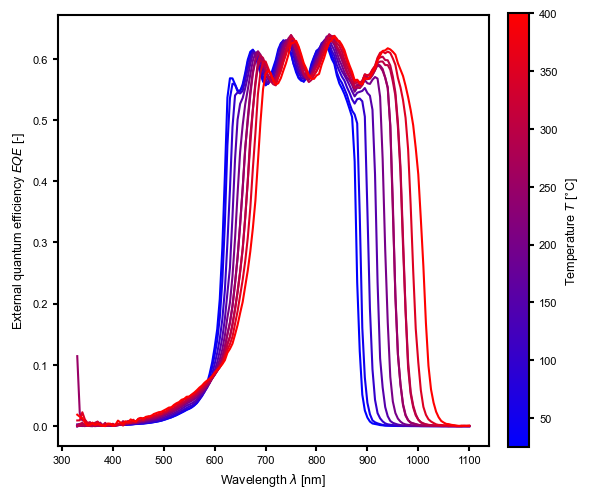

In [67]:
eqe_fp = r"C:\Users\rwitteck\Box\Outdoor Tandem Data\Modeling\MO555An5_EQE.csv"
df = pd.read_csv(eqe_fp, index_col="wavelength")

name_list = []
qe_list = []
for _, col in df.items():
    qe_data = EQEData(col.name,col.index, col)
    qe_data.temperature = float(re.findall(r'\d+(?=C)', col.name)[0])
    qe_data.calc_Eg_Rau()
    name_list.append(col.name)
    qe_list.append(qe_data)
qe_collection = EQECollection(name_list, qe_list, filepaths=eqe_fp)
qe_collection.get_bandgaps()

qe_collection.plot_eqe_temperature()



[-3.40729015e-04  1.00860650e+00]


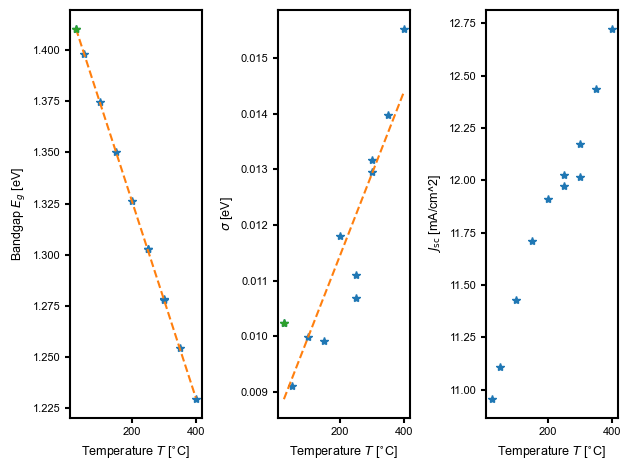

In [68]:
fig, axs = plt.subplots(1,3)


tc_temp = 25
t25idx = qe_collection.temperatures.index(tc_temp)
GaAs_bandgap_25 = qe_collection.bandgaps["Rau_bandgap_eV"][t25idx]
GaAs_sigma_25 = qe_collection.sigmas[t25idx]

model = lambda t, *p: (p[0] * t + p[1])

p0 = [0, 0]
fitres_GaAs_bandgap, _ = curve_fit(model, qe_collection.temperatures, qe_collection.bandgaps["Rau_bandgap_eV"], p0)
fitres_GaAs_sigma, _ = curve_fit(model, qe_collection.temperatures, qe_collection.sigmas, p0)

fitres_GaAs_bandgap = fitres_GaAs_bandgap / GaAs_bandgap_25
fitres_GaAs_sigma = fitres_GaAs_sigma / GaAs_sigma_25
print(fitres_GaAs_bandgap)
x_fit = np.linspace(min(qe_collection.temperatures), max(qe_collection.temperatures), 50)
y_fit_bandgap = model(x_fit, *fitres_GaAs_bandgap) * GaAs_bandgap_25
y_fit_sigma = model(x_fit, *fitres_GaAs_sigma) * GaAs_sigma_25

axs[0].plot(qe_collection.temperatures,qe_collection.bandgaps["Rau_bandgap_eV"],"*")
axs[1].plot(qe_collection.temperatures,qe_collection.sigmas,"*")
axs[2].plot(qe_collection.temperatures,qe_collection.jscs,"*")


axs[0].plot(x_fit, y_fit_bandgap, "--")
axs[0].plot(25, GaAs_bandgap_25, "*")
axs[1].plot(x_fit, y_fit_sigma, "--")
axs[1].plot(25, GaAs_sigma_25, "*")
plt.tight_layout()

# test_bandgap = 1.14
# y_test = psc_eg_shift(temperature_silicon, test_bandgap)
# ax[0].plot(x_fit, y_test, "--")
# ax[0].plot(25, test_bandgap, ".")
axs[0].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[0].set_ylabel(r"Bandgap $E_g$ [eV]")
axs[1].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[1].set_ylabel(r"$\sigma$ [eV]")
axs[2].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[2].set_ylabel(r"$J_\mathrm{sc}$ [mA/cm^2]")
plt.tight_layout()

def GaAs_eg_shift(temperature, bandgap_25):
    # p = [-6.48857961e-04,  1.01634831e+00]
    # p = [-6.67853208e-04,  1.04610179e+00]
    p = fitres_GaAs_bandgap
    return (p[0] * temperature + p[1]) * bandgap_25


def GaAs_sigma_shift(temperature, sigma_25):
    p = fitres_GaAs_sigma
    return (p[0] * temperature + p[1])*sigma_25



In [69]:
t25idx = iv_collection.temperatures.index(25)

tc_temp = iv_collection.temperatures[t25idx]
eg_idx = qe_collection.temperatures.index(tc_temp)
GaAs_bandgap_25 = qe_collection.bandgaps['Rau_bandgap_eV'][eg_idx]
GaAs_sigma_25 = qe_collection.sigmas[eg_idx]


v, i = rectify_iv_curve(iv_collection[t25idx].voltage, iv_collection[t25idx].current)
iv_params = fit_sandia_simple(v, i)

(tc_isc, tc_io, tc_rs, tc_rsh, tc_nNsVth) = iv_params

jo_scale = 1000
A = 1
TC = tc_temp
tc_jsc = tc_isc / A  # [A/cm^2]
tc_jo = tc_io / A
tc_n = tc_nNsVth / pvc.junction.Vth(TC)
tc_jdb = pvc.junction.Jdb(TC=TC, Eg=GaAs_bandgap_25)
tc_joratio = jo_scale * tc_jo / (tc_jdb * jo_scale) ** (1.0 / tc_n)

tc_rser = tc_rs * A
tc_gsh = 1 / (tc_rsh * A)

tc_sj = pvc.Multi2T(name="TC", area=A, Jext=tc_jsc, Eg_list=[GaAs_bandgap_25], n=[tc_n], J0ratio=[tc_joratio], TC=tc_temp)
tc_sj.set(Rs2T=tc_rser, Gsh=tc_gsh)


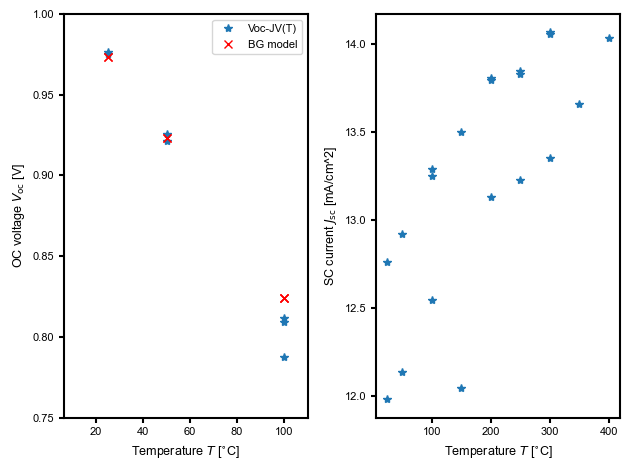

In [70]:
temperature = iv_collection.temperatures
voc = [c.voc for c in iv_collection.iv_data_list]
jsc = [c.jsc for c in iv_collection.iv_data_list]

fig, axs = plt.subplots(1, 2)
axs[0].plot(temperature, voc, "*")
axs[1].plot(temperature, jsc, "*")

tc_sj = pvc.Multi2T(
    name="TC", area=1, Jext=jsc[t25idx] / 1e3, Eg_list=[qe_collection.bandgaps["Rau_bandgap_eV"]], n=[tc_n], J0ratio=[tc_joratio]
)
tc_sj.set(Rs2T=tc_rser, Gsh=tc_gsh)
tc_sj.j[0]
for t in temperature:
    tc_eg_t = GaAs_eg_shift(t, GaAs_bandgap_25)
    tc_sj.set(Eg=tc_eg_t, TC=t, Jext=jsc[temperature.index(t)] / 1e3)
    voc = tc_sj.MPP()["Voc"]
    axs[0].plot(t, voc, "rx")


axs[0].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[0].set_ylabel(r"OC voltage $V_\mathrm{oc}$ [V]")
axs[1].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[1].set_ylabel(r"SC current $J_\mathrm{sc}$ [mA/cm^2]")

axs[0].legend(["Voc-JV(T)", "BG model"])
axs[0].set_xlim(right=110)
axs[0].set_ylim(0.75,1)
plt.tight_layout()


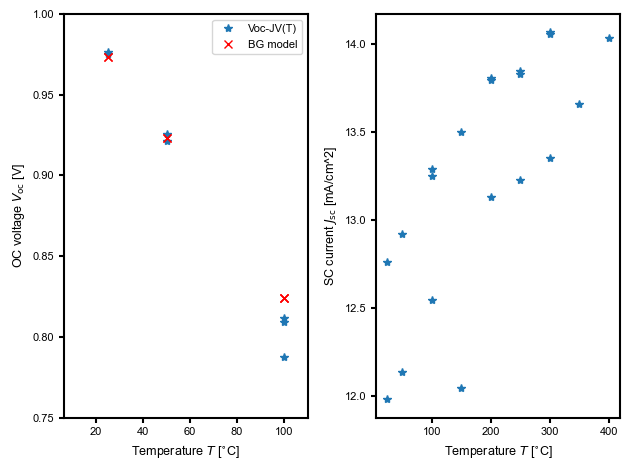

In [71]:
temperature = iv_collection.temperatures
voc = [c.voc for c in iv_collection.iv_data_list]
jsc = [c.jsc for c in iv_collection.iv_data_list]

fig, axs = plt.subplots(1, 2)
axs[0].plot(temperature, voc, "*")
axs[1].plot(temperature, jsc, "*")

tc_sj = pvc.Multi2T(
    name="TC", area=1, Jext=jsc[t25idx] / 1e3, Eg_list=[qe_collection.bandgaps["Rau_bandgap_eV"]], n=[tc_n], J0ratio=[tc_joratio]
)
tc_sj.set(Rs2T=tc_rser, Gsh=tc_gsh)
tc_sj.j[0]
for t in temperature:
    tc_eg_t = GaAs_eg_shift(t, GaAs_bandgap_25)
    tc_sj.set(Eg=tc_eg_t, TC=t, Jext=jsc[temperature.index(t)] / 1e3)
    voc = tc_sj.MPP()["Voc"]
    axs[0].plot(t, voc, "rx")


axs[0].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[0].set_ylabel(r"OC voltage $V_\mathrm{oc}$ [V]")
axs[1].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[1].set_ylabel(r"SC current $J_\mathrm{sc}$ [mA/cm^2]")

axs[0].legend(["Voc-JV(T)", "BG model"])
axs[0].set_xlim(right=110)
axs[0].set_ylim(0.75,1)
plt.tight_layout()


## Do the same for the Silicon data 
Load Si data from a Silicon module

In [72]:
# test regex for positive and negative floats and integers
text = "Test: 3.14, -42, 0.5, -0.2, 100, +10 string"
pattern = r"-?\d+(?:\.\d+)?"
# pattern = r"[+-]?\d+(?:\.\d+)?"
# pattern = r"([-+]?\d+\.?\d+)"
matches = re.findall(pattern, text)
print(matches)

['3.14', '-42', '0.5', '-0.2', '100', '10']


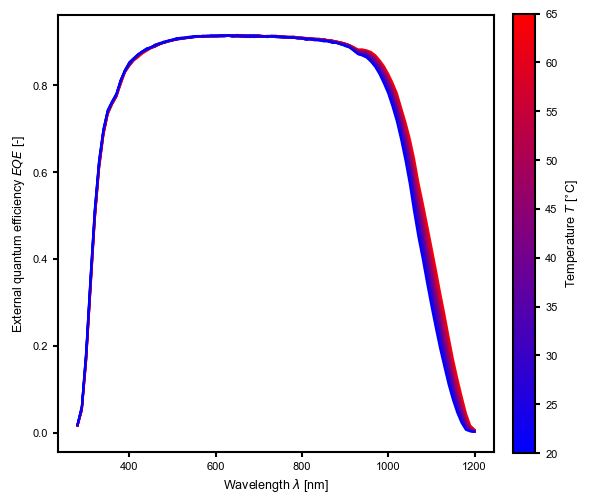

In [73]:
eqe_fp = r"../data/EQE-T_Silicon.csv"
df = pd.read_csv(r"../data/EQE-T_Silicon.csv", sep=",")
df.set_index(df.columns[0], inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)

name_list = []
qe_list = []
for _, col in df.items():
    qe_data = EQEData(col.name, col.index, col)
    qe_data.temperature = float(re.findall(r"([-+]?\d+\.?\d+)", col.name)[0])
    qe_data.calc_Eg_Rau()
    name_list.append(col.name)
    qe_list.append(qe_data)
qe_collection = EQECollection(name_list, qe_list, filepaths=eqe_fp)

fig, _ = qe_collection.plot_eqe_temperature()


# fig.savefig(rf"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\eqe.pdf")


In [74]:
# qe_collection.get_bandgaps()
# # fig, axs = plt.subplots(1,2, constrained_layout = True, figsize = fig_twocol)
# # fig, axs = plt.subplots(1,3, constrained_layout = True, figsize = fig_twocol)
# # fig, axs = plt.subplot_mosaic(
# #     [[0, 1, 2], [".", ".", 3]],
# #     constrained_layout=False,
# #     sharex=True,
# #     gridspec_kw={"height_ratios": [2, 1]},
# #     figsize=get_figsize(522, fraction = 1, ratio=1,rows=2,cols=3),
# # )

# idx_25 = qe_collection.temperatures.index(25)
# Si_bandgap_25 = qe_collection.bandgaps["Rau_bandgap_eV"][idx_25]
# Si_sigma_25 = qe_collection.sigmas[idx_25]

# model = lambda t, *p: (p[0] * t + p[1])

# p0 = [0, 0]
# fitres_Si_bandgap, _ = curve_fit(model, qe_collection.temperatures, qe_collection.bandgaps["Rau_bandgap_eV"], p0)
# fitres_Si_sigma, _ = curve_fit(model, qe_collection.temperatures, qe_collection.sigmas, p0)

# fitres_Si_bandgap = fitres_Si_bandgap / Si_bandgap_25
# fitres_Si_sigma = fitres_Si_sigma / Si_sigma_25
# x_fit = np.linspace(min(qe_collection.temperatures), max(qe_collection.temperatures), 50)
# y_fit_bandgap = model(x_fit, *fitres_Si_bandgap) * Si_bandgap_25
# y_fit_sigma = model(x_fit, *fitres_Si_sigma) * Si_sigma_25

# def Si_eg_shift(temperature, bandgap_25):
#     # p = [-6.48857961e-04,  1.01634831e+00]
#     # p = [-6.67853208e-04,  1.04610179e+00]
#     p = fitres_Si_bandgap
#     return (p[0] * temperature + p[1]) * bandgap_25


# def Si_sigma_shift(temperature, sigma_25):
#     p = fitres_Si_sigma
#     return (p[0] * temperature + p[1]) * sigma_25


# jscs_shift = shift_eqe(
#     qe_collection[idx_25].eqe,
#     Si_bandgap_25,
#     Si_sigma_25,
#     [Si_eg_shift(temp,Si_bandgap_25) for temp in qe_collection.temperatures],
#     [Si_sigma_shift(temp,Si_sigma_25) for temp in qe_collection.temperatures],
#     am15g.reindex(qe_collection[idx_25].waves),
# )


# fig, axs = plt.subplots(
#     2,3,
#     constrained_layout=False,
#     sharex=True,
#     gridspec_kw={"height_ratios": [2, 1]},
#     figsize=get_figsize(522, fraction = 1, ratio=1,rows=2,cols=3),
# )
# axs = axs.ravel()

# axs[0].plot(qe_collection.temperatures, qe_collection.bandgaps["Rau_bandgap_eV"], "*", mfc=(0, 0, 1, 0.66), mec=(0, 0, 1))
# axs[1].plot(qe_collection.temperatures, qe_collection.sigmas, "*", mfc=(0, 0, 1, 0.66), mec=(0, 0, 1))

# qe_jscs = [intergrate_eqe(qe.eqe) for qe in qe_collection]
# axs[2].plot(qe_collection.temperatures, qe_collection.jscs, "*", mfc=(0, 0, 1, 0.66), mec=(0, 0, 1))
# # axs[2].plot(qe_collection.temperatures,qe_jscs,"*", mfc=(0,0,1,0.66), mec=(0,0,1))


# axs[0].plot(x_fit, y_fit_bandgap, "--")
# axs[1].plot(x_fit, y_fit_sigma, "--")

# axs[3].remove()
# axs[4].remove()

# axs[0].set_box_aspect(1)
# axs[1].set_box_aspect(1)
# axs[2].set_box_aspect(2/3)
# axs[5].set_box_aspect(1/3)

# axs[0].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
# axs[1].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
# axs[5].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")

# axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# axs[0].set_ylabel(r"Mean bandgap $\tilde{E}_{\mathrm{g},i}$ [eV]")
# axs[1].set_ylabel(r"Std. deviation $\sigma_{E_{\mathrm{g}}}$ [eV]")
# axs[2].set_ylabel(r"$J_\mathrm{sc}$ [mAcm$^{-2}$]")
# axs[5].set_ylabel(r"$\Delta$ $J_\mathrm{sc}$ [mAcm$^{-2}$]")
# axs[5].set_ylim(-0.175,0.175)

# t_sorter = np.argsort(qe_collection.temperatures)
# axs[2].plot(np.array(qe_collection.temperatures)[t_sorter], jscs_shift[t_sorter], "--")
# axs[5].plot(qe_collection.temperatures, qe_collection.jscs - jscs_shift, "*", mfc=(0, 0, 1, 0.66), mec=(0, 0, 1))

# fig.subplots_adjust(hspace=0, wspace = 0.5)
# ax2pos = axs[2].get_position().get_points()
# x0, y0 = ax2pos[0]
# x1, y1 = ax2pos[1]
# axs[2].set_position([x0, y0 + (y1-y0)/4, x1-x0, y1-y0])

# ax3pos = axs[5].get_position().get_points()
# x0, y0 = ax3pos[0]
# x1, y1 = ax3pos[1]
# axs[5].set_position([x0, y0 + (y1-y0)*3, x1-x0, y1-y0])

# for ax in axs[[2,5]]:
#     for item in [ax.yaxis.label]:
#         item.set_fontsize(7)



# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\egsigma.pgf", format="pgf")
# # fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\egsigma.pdf", format='pdf', bbox_inches = "tight")


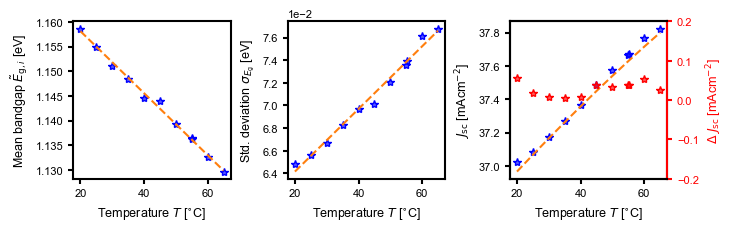

In [75]:
qe_collection.get_bandgaps()

idx_25 = qe_collection.temperatures.index(25)
Si_bandgap_25 = qe_collection.bandgaps["Rau_bandgap_eV"][idx_25]
Si_sigma_25 = qe_collection.sigmas[idx_25]

model = lambda t, *p: (p[0] * t + p[1])

p0 = [0, 0]
fitres_Si_bandgap, _ = curve_fit(model, qe_collection.temperatures, qe_collection.bandgaps["Rau_bandgap_eV"], p0)
fitres_Si_sigma, _ = curve_fit(model, qe_collection.temperatures, qe_collection.sigmas, p0)

fitres_Si_bandgap = fitres_Si_bandgap / Si_bandgap_25
fitres_Si_sigma = fitres_Si_sigma / Si_sigma_25
x_fit = np.linspace(min(qe_collection.temperatures), max(qe_collection.temperatures), 50)
y_fit_bandgap = model(x_fit, *fitres_Si_bandgap) * Si_bandgap_25
y_fit_sigma = model(x_fit, *fitres_Si_sigma) * Si_sigma_25

def Si_eg_shift(temperature, bandgap_25):
    # p = [-6.48857961e-04,  1.01634831e+00]
    # p = [-6.67853208e-04,  1.04610179e+00]
    p = fitres_Si_bandgap
    return (p[0] * temperature + p[1]) * bandgap_25


def Si_sigma_shift(temperature, sigma_25):
    p = fitres_Si_sigma
    return (p[0] * temperature + p[1]) * sigma_25


jscs_shift = shift_eqe(
    qe_collection[idx_25].eqe,
    Si_bandgap_25,
    Si_sigma_25,
    [Si_eg_shift(temp,Si_bandgap_25) for temp in qe_collection.temperatures],
    [Si_sigma_shift(temp,Si_sigma_25) for temp in qe_collection.temperatures],
    am15g.reindex(qe_collection[idx_25].waves),
)


fig, axs = plt.subplots(1,3, constrained_layout = True, figsize=get_figsize(522, fraction = 1, ratio=1,rows=1,cols=3))
ax2 = axs[2].twinx()

# set colors of second y axis
ax2.yaxis.label.set_color('r')
ax2.tick_params(axis='y', colors='r')
ax2.spines['right'].set_color('r')

axs[0].plot(qe_collection.temperatures, qe_collection.bandgaps["Rau_bandgap_eV"], "*", mfc=(0, 0, 1, 0.66), mec=(0, 0, 1))
axs[1].plot(qe_collection.temperatures, qe_collection.sigmas, "*", mfc=(0, 0, 1, 0.66), mec=(0, 0, 1))

qe_jscs = [intergrate_eqe(qe.eqe) for qe in qe_collection]
axs[2].plot(qe_collection.temperatures, qe_collection.jscs, "*", mfc=(0, 0, 1, 0.66), mec=(0, 0, 1))

axs[0].plot(x_fit, y_fit_bandgap, "--")
axs[1].plot(x_fit, y_fit_sigma, "--")


axs[0].set_box_aspect(1)
axs[1].set_box_aspect(1)
axs[2].set_box_aspect(1)

axs[0].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[1].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[2].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")

axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

axs[0].set_ylabel(r"Mean bandgap $\tilde{E}_{\mathrm{g},i}$ [eV]")
axs[1].set_ylabel(r"Std. deviation $\sigma_{E_{\mathrm{g}}}$ [eV]")
axs[2].set_ylabel(r"$J_\mathrm{sc}$ [mAcm$^{-2}$]")


ax2.set_ylabel(r"$\Delta$ $J_\mathrm{sc}$ [mAcm$^{-2}$]")
ax2.set_ylim(-0.2,0.2)

t_sorter = np.argsort(qe_collection.temperatures)
axs[2].plot(np.array(qe_collection.temperatures)[t_sorter], jscs_shift[t_sorter], "--")
ax2.plot(qe_collection.temperatures, qe_collection.jscs - jscs_shift, "*", mfc=(1, 0, 0, 0.66), mec=(1, 0, 0))


fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\egsigma.pgf", format="pgf")
# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\egsigma.pdf", format='pdf', bbox_inches = "tight")


In [76]:
def convert_to_arraystring(string:str)->np.ndarray:
    """
    Function to convert the outdoor csv format containing the numpy array as a string into a np.array type

    Args:
        string (str): Numpy array string representation

    Returns:
        _type_: numpy array
    """
    return np.fromstring(string[1:-1], sep=' ')
    # return np.fromiter(string[1:-1].split(), dtype=float)


# Load outdoor data

Load cell parameters from IV measurement

In [77]:
root = r"C:\Users\rwitteck\Box\Outdoor Tandem Data\Outdoor Data"
data_raw = pd.read_csv(os.path.join(root,"backup_dfWB284+MR281-20210902_wRMIS.csv"))
data_raw.timestamp = data_raw.timestamp.astype(np.datetime64)
data_raw = data_raw.set_index('timestamp').sort_index()



Filter irrelevant data

In [78]:
data_filter = (
    (data_raw["irrad_mean"] > 50)
    # & (data_raw["global_horizontal"] > 30)
    & (data_raw["pmp"] < 1e3)
    & (np.abs(data_raw["irrad_post"] / data_raw["irrad_pre"] - 1) < 0.05)
    # & (np.abs(data_raw["temp_module_post"] - data_raw["temp_module_pre"]) < 3)
    # & (np.abs(data_raw["temp_module_post"] / data_raw["temp_module_pre"] - 1) < 0.1)
    & (data_raw["temp_module_mean"] < 200)
)
# print(data_filter.sum())
data = data_raw[data_filter].copy()

In [79]:
data.module.unique()

array(['M1910-0016 MR281 bottom', 'M1910-0016 MR281 top'], dtype=object)

In [80]:
data["v"] = data["v"].apply(convert_to_arraystring)
data["i"] = data["i"].apply(convert_to_arraystring)

C:\Users\rwitteck\AppData\Local\Temp\1\ipykernel_22744\434524853.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees


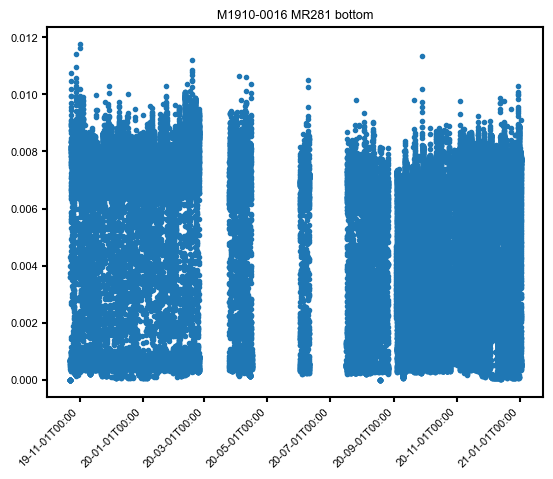

In [81]:
module_names = data.module.unique()
module_chose = 0
df_module = data[data.module == module_names[module_chose]]
fig,axs = plt.subplots()
axs.plot(df_module["pmp"],".")
axs.set_title(module_names[module_chose])

axs.set_xticklabels(axs.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees
axs.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%dT%H:%M'))
# ax.set_ylim(0,0.1)

Fit the IV data with single diode model

use best so far
(0.014725092533505402, 0.008032776852352975, -1.0, 112748.53115227912, 1.0)
(0.014758180498376015, 1.508048216711765e-11, 0.04927773431821308, 4401.581432733193, 0.033187602260321254)
use best so far
(0.014763147426069004, 0.007998107971072883, -1.0, 18398.76260293795, 1.0)
use best so far
(0.014774073841126924, 0.008037070644846628, -1.0, 213708.66617754323, 1.0)
(0.014683668243792225, 3.884454506289451e-11, 0.051964844464632995, 59001.66612954853, 0.03479819535577036)
(0.014796816419399186, 2.152579893739024e-11, 0.09456494370826253, 10594.388535830069, 0.03375259851245121)
use best so far
(0.014803784419350903, 0.008063061533480194, -1.0, 60823.90008038082, 1.0)
(0.014207756771342374, 1.818423623845448e-11, 0.00026094983940457125, 5473.260030378988, 0.03356084101361579)
(0.014203567251335205, 2.5705858408638962e-11, 0.2158655587143819, 53762.350529173964, 0.0340671677996021)
(0.014195473095746581, 1.0831269181920487e-11, 0.033737265257517884, 3312.2969976611125, 0.03

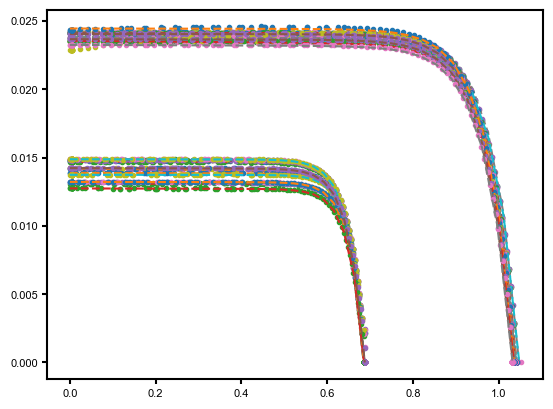

In [82]:
fig, axs = plt.subplots()
for mod_name in module_names:
    df_module = data[data.module == mod_name]
    df_module = df_module[
        (df_module["irrad_mean"] > 995)
        & (df_module["irrad_mean"] < 1005)
        & (df_module["temp_module_mean"] > 24.5)
        & (df_module["temp_module_mean"] < 25.5)
    ]
    for _, row in df_module.iterrows():
        # v_sorter = np.argsort(row["v"])
        # v = row["v"][v_sorter]
        # i = row["i"][v_sorter]
        v, i = row["v"], row["i"]
        v, i = simple_interp_VocIscPmpp(v, i)
        v, i = rectify_iv_curve(v, i)
        # interpolate
        # vint = np.linspace(v[0],v[-1],150)
        # iint = np.interp(vint, v, i)
        # v = vint
        # i = iint

        # if row["v"] and row["i"]:
        iv_params = fit_sandia_simple(v, i)
        print(iv_params)
        if all(np.array(iv_params) > 0):
        # if any(np.array(iv_params) < 0):
            fit = singlediode(*iv_params, ivcurve_pnts=30)
            axs.plot(v, i, ".")
            axs.plot(fit["v"], fit["i"], "--", label="psc-fit")


Plot Jsc-Voc

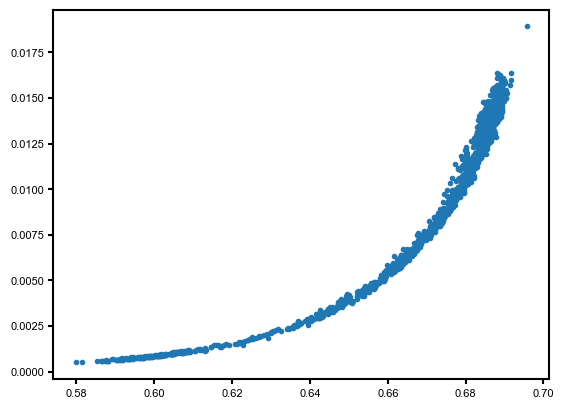

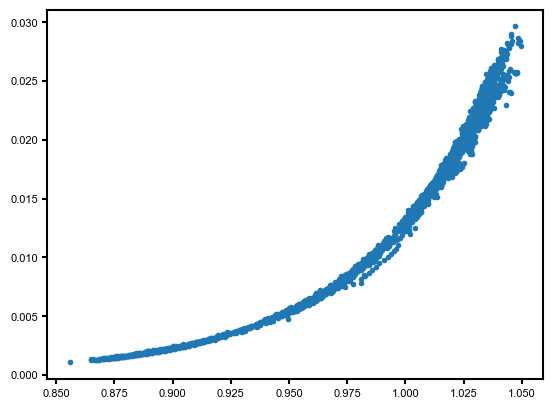

In [83]:

for mod_name in module_names:
    x = []
    y = []
    fig, axs = plt.subplots()

    df_module = data[data.module == mod_name]
    df_module = df_module[
        (
            (df_module["temp_module_mean"] > 24.5)
            & (df_module["temp_module_mean"] < 25.5)
        )
    ]
    for _, row in df_module.iterrows():
        x.append(row["voc"])
        y.append(row["isc"])
    axs.plot(x, y, ".")
        # ax.plot(row["vmp"], row["imp"], ".")


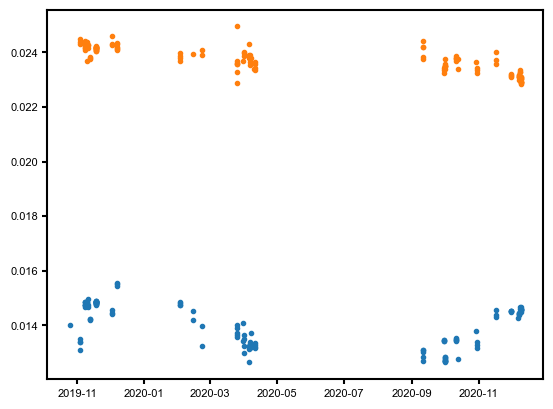

In [84]:
fig, axs = plt.subplots()
for mod_name in module_names:
    df_module = data[data.module == mod_name]
    df_module = df_module[
        (df_module["irrad_mean"] > 990)
        & (df_module["irrad_mean"] < 1010)
        & (df_module["temp_module_mean"] > 24)
        & (df_module["temp_module_mean"] < 26)
    ]
    axs.plot(df_module['isc'], ".")


Load EQEs


Text(0, 0.5, 'EQE [1]')

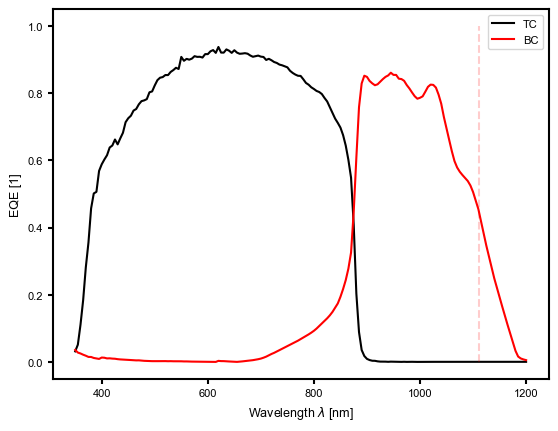

In [85]:

eqe_raw = pd.read_excel(r"C:\Users\rwitteck\Box\Outdoor Tandem Data\Modeling\EQEs.xlsx", index_col="wavelength")

tc_eqe = eqe_raw["TC_EQE"]
bc_eqe = eqe_raw["BC_EQE"]
fig,axs = plt.subplots()
axs.plot(tc_eqe,"k-")
axs.plot(bc_eqe,"r-")
axs.legend(["TC", "BC"])

device_tc_eg_25, device_tc_sigma_25 = calc_Eg_Rau(tc_eqe)
device_bc_eg_25, device_bc_sigma_25 = calc_Eg_Rau(bc_eqe)
axs.plot([photonenergy_to_wavelength(device_bc_eg_25),photonenergy_to_wavelength(device_bc_eg_25)],[0,1], "--", c=(1,0,0,0.2))
# device_bc_eg_25 = 1.2 # results in better for for Voc(T) dependence

axs.set_xlabel(r"Wavelength $\lambda$ [nm]")
axs.set_ylabel(r"EQE [1]")



Localize time and add AOI


In [86]:
location = pvloc.Location(39.7555, -105.2211, tz="America/Denver", altitude=1828.8)
# location = pvloc.Location(39.742, -105.18, tz="America/Denver", altitude=1828.8)

tilt = 40
azimuth = 180

data['tztime'] = data.index.tz_localize(location.tz).values
solpos = solarposition.get_solarposition(
   data['tztime'], latitude=location.latitude, longitude=location.longitude, altitude=location.altitude, method="nrel_numpy"
)
aoi = irradiance.aoi(tilt, azimuth, solpos.apparent_zenith, solpos.azimuth)
data['aoi'] = aoi.values

Load IV data

In [87]:
MR281_top = data[data['module'] == 'M1910-0016 MR281 top'] # GaAs
MR281_bottom = data[data['module'] == 'M1910-0016 MR281 bottom'] # Si IBC
# WB284_bottom = data[data['module'] == 'M2002-0001 WB284 bottom']
# WB284_Top = data[data['module'] == 'M2002-0001 WB284 Top']

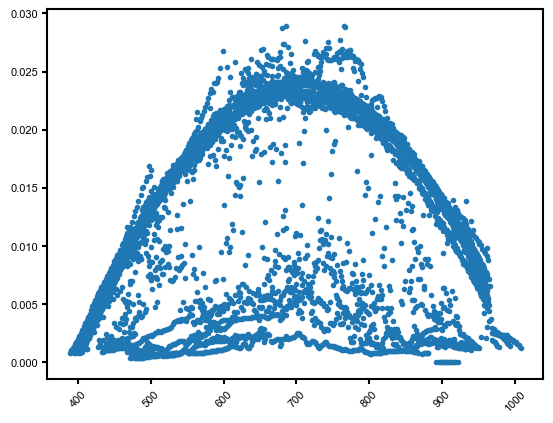

In [88]:
fig,ax = plt.subplots()
time_only = MR281_top.index.to_series().dt.time.astype(str)

# ax.plot(time_only[:5000], MR281_top.pmp[:5000],".")
ax.plot(MR281_top.index[:5000].hour*60+MR281_top.index[:5000].minute, MR281_top.imp[:5000],".")
ax.tick_params(axis='x', rotation=45)
# xticks = ax.get_xticks()
# ax.set_xticks(xticks[::len(xticks) // 10]) # set new tick positions

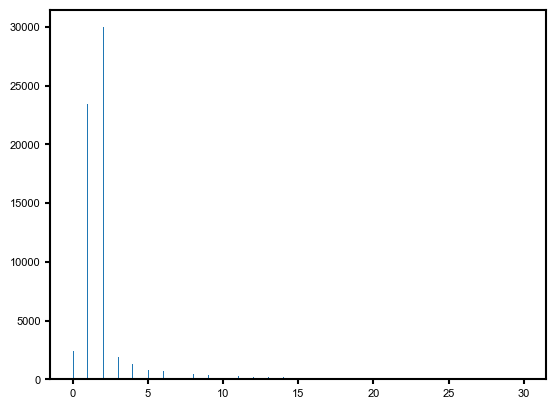

In [89]:
fig,ax = plt.subplots()
times = (np.diff(MR281_bottom.index) / np.timedelta64(1, 'm')).astype(int)
times.sort()
hst = ax.hist(times[:-500],500)
# ax.set_xlim(0,1000)

Load spectral data

In [90]:
# meteo_spectra = get_meteo(MR281_top.index[0], MR281_top.index[-1], "1T")
# with open("meteo_spectra.p", 'wb') as fout:
#     pickle.dump(meteo_spectra,fout)

with open(r"meteo_data/meteo_spectra.p", 'rb') as fin:
    meteo_spectra = pickle.load(fin)

# meteo_spectra = get_meteo(MR281_top.index[0], MR281_top.index[0] + pd.Timedelta(days=10), "1T")
# meteo_spectra = get_meteo(MR281_top.index[-1] - pd.Timedelta(weeks=1), MR281_top.index[-1], "1T")
# meteo_spectra = get_meteo(pd.Timestamp(2020,11,5,0,0,0 ),pd.Timestamp(2021,1,5,0,0,0), "1T")


In [91]:
time_tolerance = pd.Timedelta(seconds=60)

Load all meteorological data for comparison of irradiance sensors, snow etc.

In [92]:
# meteo_data = Meteorological.get_midc_environmental(MR281_top.index[0], MR281_top.index[-1])

# with open("meteo_data.p", 'wb') as fout:
#     pickle.dump(meteo_data,fout)

with open(r"meteo_data/meteo_data.p", 'rb') as fin:
    meteo_data = pickle.load(fin)

meteo_resampled = meteo_data.data.resample("1T").median(numeric_only =True)


Align data

In [93]:
# (MR281_bottom.index[1]-MR281_bottom.index[0]).total_seconds()

# np.argmax([
#     np.median(np.diff(MR281_bottom.index)),
#     np.median(np.diff(MR281_top.index)),
#     np.median(np.diff(meteo_spectra.spectra.index))
#     ]
# )
indices = {"MR281_bottom":MR281_bottom.index, "MR281_top":MR281_top.index,"spectra":meteo_spectra.spectra.index}
idx_align = np.argmin([
    len(MR281_bottom.index),
    len(MR281_top.index),
    len(meteo_spectra.spectra.index)
    ]
)

idx_align = indices.get(list(indices.keys())[idx_align])

MR281_top_aligned = MR281_top.reindex(index=idx_align, method="nearest", tolerance=time_tolerance)
MR281_bottom_aligned =MR281_bottom.reindex(index=idx_align, method="nearest", tolerance=time_tolerance)
meteo_spectra_aligned = meteo_spectra.reindex(index=idx_align, method="nearest", tolerance=time_tolerance)
meteo_data_aligned = meteo_resampled.reindex(index=idx_align, method="nearest", tolerance=time_tolerance)


nan_filter = ~(MR281_top_aligned.iloc[:,:17].isna().any(axis=1)) & ~(MR281_bottom_aligned.iloc[:,:17].isna().any(axis=1)) & ~(meteo_spectra_aligned.wind.isna()) & ~(meteo_data_aligned['Avg Wind Speed @ 6ft [m/s]'].isna())
MR281_top_aligned =  MR281_top_aligned[nan_filter]
MR281_bottom_aligned = MR281_bottom_aligned[nan_filter]
meteo_spectra_aligned = meteo_spectra_aligned.filter_custom(nan_filter)
meteo_data_aligned = meteo_data_aligned[nan_filter]

Snow

C:\Users\rwitteck\AppData\Local\Temp\1\ipykernel_22744\1611029713.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(axs.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees
C:\Users\rwitteck\AppData\Local\Temp\1\ipykernel_22744\1611029713.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(axs.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees


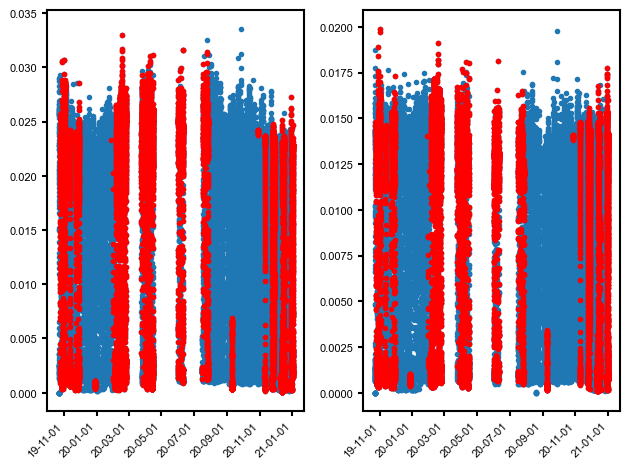

In [94]:
fig,ax = plt.subplots(1,2)
# ax.plot(meteo_data_aligned["Snow Depth [cm]"],MR281_top_aligned['isc'],".")
# ax.set_xlim(0, meteo_data_aligned["Snow Depth [cm]"].max())

ax[0].plot(MR281_top_aligned['isc'],".")
ax[0].plot(MR281_top_aligned['isc'][meteo_data_aligned["Snow Depth [cm]"]>1],"r.")
ax[1].plot(MR281_bottom_aligned['isc'],".")
ax[1].plot(MR281_bottom_aligned['isc'][meteo_data_aligned["Snow Depth [cm]"]>1],"r.")

ax[0].set_xticklabels(axs.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
ax[1].set_xticklabels(axs.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
plt.tight_layout()

In [95]:
# meteo_spectra_aligned.wind.isna().any()
# MR281_top_aligned.iloc[:,:17].isna().any(axis=1)

In [96]:
# # align with same timestamps

# MR281_top_aligned = MR281_top.reindex(index=MR281_bottom.index, method="nearest", tolerance=time_tolerance)
# MR281_bottom_aligned = MR281_bottom[~MR281_top_aligned.isna().all(axis=1)]
# MR281_top_aligned = MR281_top_aligned[~MR281_top_aligned.isna().all(axis=1)]
# # MR281_top_aligned.index == MR281_bottom_aligned.index

# # print(MR281_top_aligned.shape[0] == MR281_bottom_aligned.shape[0])
# # print(all(MR281_top_aligned.index == MR281_bottom_aligned.index))
# # align with same timestamps
# wind_aligned = meteo_spectra.wind.reindex(index=MR281_top.index, method="nearest", tolerance=pd.Timedelta(seconds=30))
# spectra_aligned = meteo_spectra.spectra.reindex(index=MR281_top.index, method="nearest", tolerance=pd.Timedelta(seconds=30))
# MR281_top_aligned = MR281_top[~spectra_aligned.isna().all(axis=1)]
# wind_aligned = wind_aligned[~spectra_aligned.isna().all(axis=1)]
# spectra_aligned = spectra_aligned[~spectra_aligned.isna().all(axis=1)]

# spec_power_aligned = pd.Series(np.trapz(x=meteo_spectra.wavelength,y=spectra_aligned),index=spectra_aligned.index)

In [97]:
# align but keep original timestamps

indices = {"MR281_bottom":MR281_bottom.index, "MR281_top":MR281_top.index,"spectra":meteo_spectra.spectra.index}
idx_align = np.argmin([
    len(MR281_bottom.index),
    len(MR281_top.index),
    len(meteo_spectra.spectra.index)
    ]
)

idx_align = indices.get(list(indices.keys())[idx_align])

# create a list of dataframes
df_list = [MR281_bottom, MR281_top, meteo_spectra.spectra]

# find the dataframe with the fewest time values
df_min = min(df_list, key=lambda x: len(x.index))

# define the time difference
time_diff = pd.Timedelta(minutes=1)

# get the reference index of the dataframe with the fewest time values
ref_idx = df_min.index

# create an empty list to store the indices of the other dataframes
new_dfs = []

# loop over the other dataframes and get the indices within the time difference of the reference index
for df in df_list:
    ref_indexer = ref_idx.get_indexer(target=df.index, method="nearest", tolerance=time_tolerance)
    ref_indexer = ref_indexer[ref_indexer > -1]
    ref_idx = ref_idx[ref_indexer]
    ref_idx = ref_idx[~ref_idx.duplicated()]

for df in df_list:
    df_indexer = df.index.get_indexer(target=ref_idx, method="nearest", tolerance=time_tolerance)
    df_indexer = df_indexer[df_indexer > -1]
    new_dfs.append(df.iloc[df_indexer, :])

# concatenate the indices into a single index object

assert new_dfs[0].shape[0] == new_dfs[1].shape[0] == new_dfs[2].shape[0]
assert ~(all(new_dfs[0].index == new_dfs[1].index) & all(new_dfs[0].index == new_dfs[2].index))
# assert all(np.abs(MR281_top_aligned.index - MR281_bottom_aligned.index) < time_tolerance)

In [98]:
# # align but keep original timestamps
# top_indexer = MR281_top.index.get_indexer(target=MR281_bottom.index, method="nearest", tolerance=time_tolerance)
# top_indexer = top_indexer[top_indexer > -1]
# MR281_top_aligned = MR281_top.iloc[top_indexer, :]

# bottom_indexer = MR281_bottom.index.get_indexer(target=MR281_top_aligned.index, method="nearest", tolerance=time_tolerance)
# bottom_indexer = bottom_indexer[bottom_indexer > -1]
# MR281_bottom_aligned = MR281_bottom.iloc[bottom_indexer, :]

# # print(MR281_top_aligned.shape[0] == MR281_bottom_aligned.shape[0])
# # print(all(MR281_top_aligned.index == MR281_bottom_aligned.index))
# assert MR281_top_aligned.shape[0] == MR281_bottom_aligned.shape[0]
# assert ~all(MR281_top_aligned.index == MR281_bottom_aligned.index)
# assert all(np.abs(MR281_top_aligned.index - MR281_bottom_aligned.index) < time_tolerance)


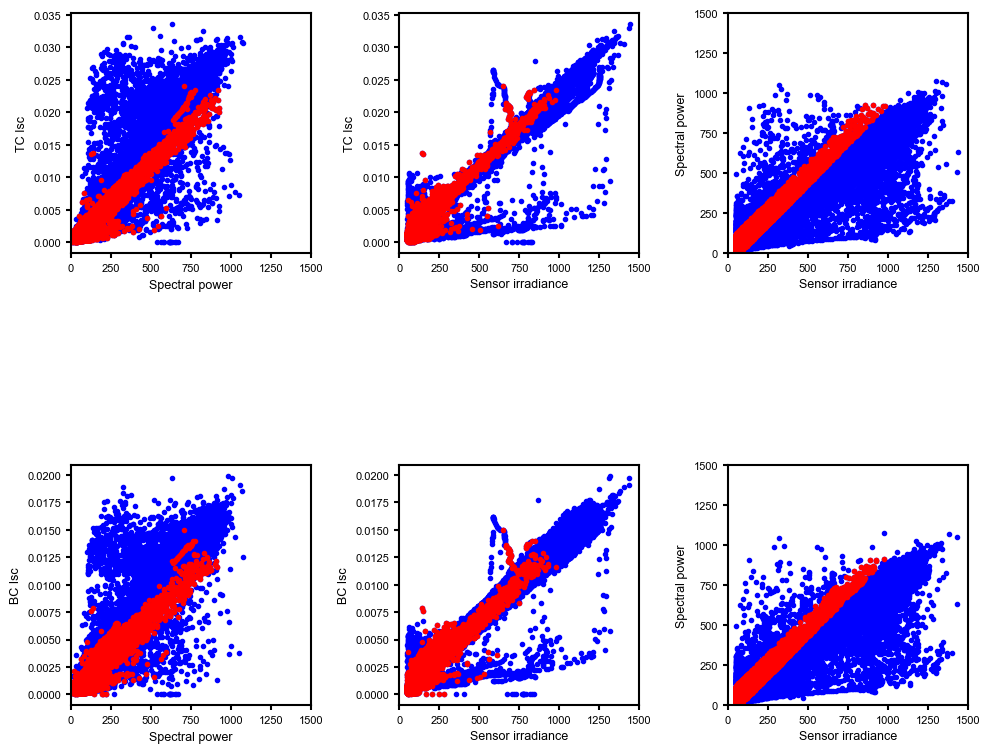

In [99]:
fig,axs = plt.subplots(2,3, figsize=(10,10))

max_irr = max(max(meteo_spectra_aligned.SpecPower), max(MR281_top_aligned['irrad_mean']))

axs[0,0].plot(meteo_spectra_aligned.SpecPower,MR281_top_aligned['isc'],"b.")
axs[0,1].plot(MR281_top_aligned['irrad_mean'],MR281_top_aligned['isc'],"b.")
axs[0,2].plot(MR281_top_aligned['irrad_mean'],meteo_spectra_aligned.SpecPower,"b.")

axs[1,0].plot(meteo_spectra_aligned.SpecPower,MR281_bottom_aligned['isc'],"b.")
axs[1,1].plot(MR281_bottom_aligned['irrad_mean'],MR281_bottom_aligned['isc'],"b.")
axs[1,2].plot(MR281_bottom_aligned['irrad_mean'],meteo_spectra_aligned.SpecPower,"b.")

confidence_filter = np.abs(meteo_spectra_aligned.SpecPower - MR281_top_aligned['irrad_mean'])/np.sqrt(2) < 50

axs[0,0].plot(meteo_spectra_aligned.SpecPower[confidence_filter],MR281_top_aligned['isc'][confidence_filter],"r.")
axs[0,1].plot(MR281_top_aligned['irrad_mean'][confidence_filter],MR281_top_aligned['isc'][confidence_filter],"r.")
axs[0,2].plot(MR281_top_aligned['irrad_mean'][confidence_filter],meteo_spectra_aligned.SpecPower[confidence_filter],"r.")

confidence_filter = np.abs(meteo_spectra_aligned.SpecPower - MR281_bottom_aligned['irrad_mean'])/np.sqrt(2) < 50

axs[1,0].plot(meteo_spectra_aligned.SpecPower[confidence_filter],MR281_bottom_aligned['isc'][confidence_filter],"r.")
axs[1,1].plot(MR281_bottom_aligned['irrad_mean'][confidence_filter],MR281_bottom_aligned['isc'][confidence_filter],"r.")
axs[1,2].plot(MR281_bottom_aligned['irrad_mean'][confidence_filter],meteo_spectra_aligned.SpecPower[confidence_filter],"r.")


for ax in axs.ravel():
    # ax.axis('square')
    ax.set_xlim(0,1500)
    ax.set_box_aspect(1)

axs[0,2].set_ylim(0,1500)
axs[1,2].set_ylim(0,1500)

xticks = axs[0,2].get_xticks()
axs[0,2].set_yticks(xticks)

xticks = axs[1,2].get_xticks()
axs[1,2].set_yticks(xticks)

axs[0,0].set_xlabel("Spectral power")
axs[0,1].set_xlabel("Sensor irradiance")
axs[0,2].set_xlabel("Sensor irradiance")
axs[0,0].set_ylabel("TC Isc")
axs[0,1].set_ylabel("TC Isc")
axs[0,2].set_ylabel("Spectral power")

axs[1,0].set_xlabel("Spectral power")
axs[1,1].set_xlabel("Sensor irradiance")
axs[1,2].set_xlabel("Sensor irradiance")
axs[1,0].set_ylabel("BC Isc")
axs[1,1].set_ylabel("BC Isc")
axs[1,2].set_ylabel("Spectral power")

plt.tight_layout()


Correct spectral data for irradiance


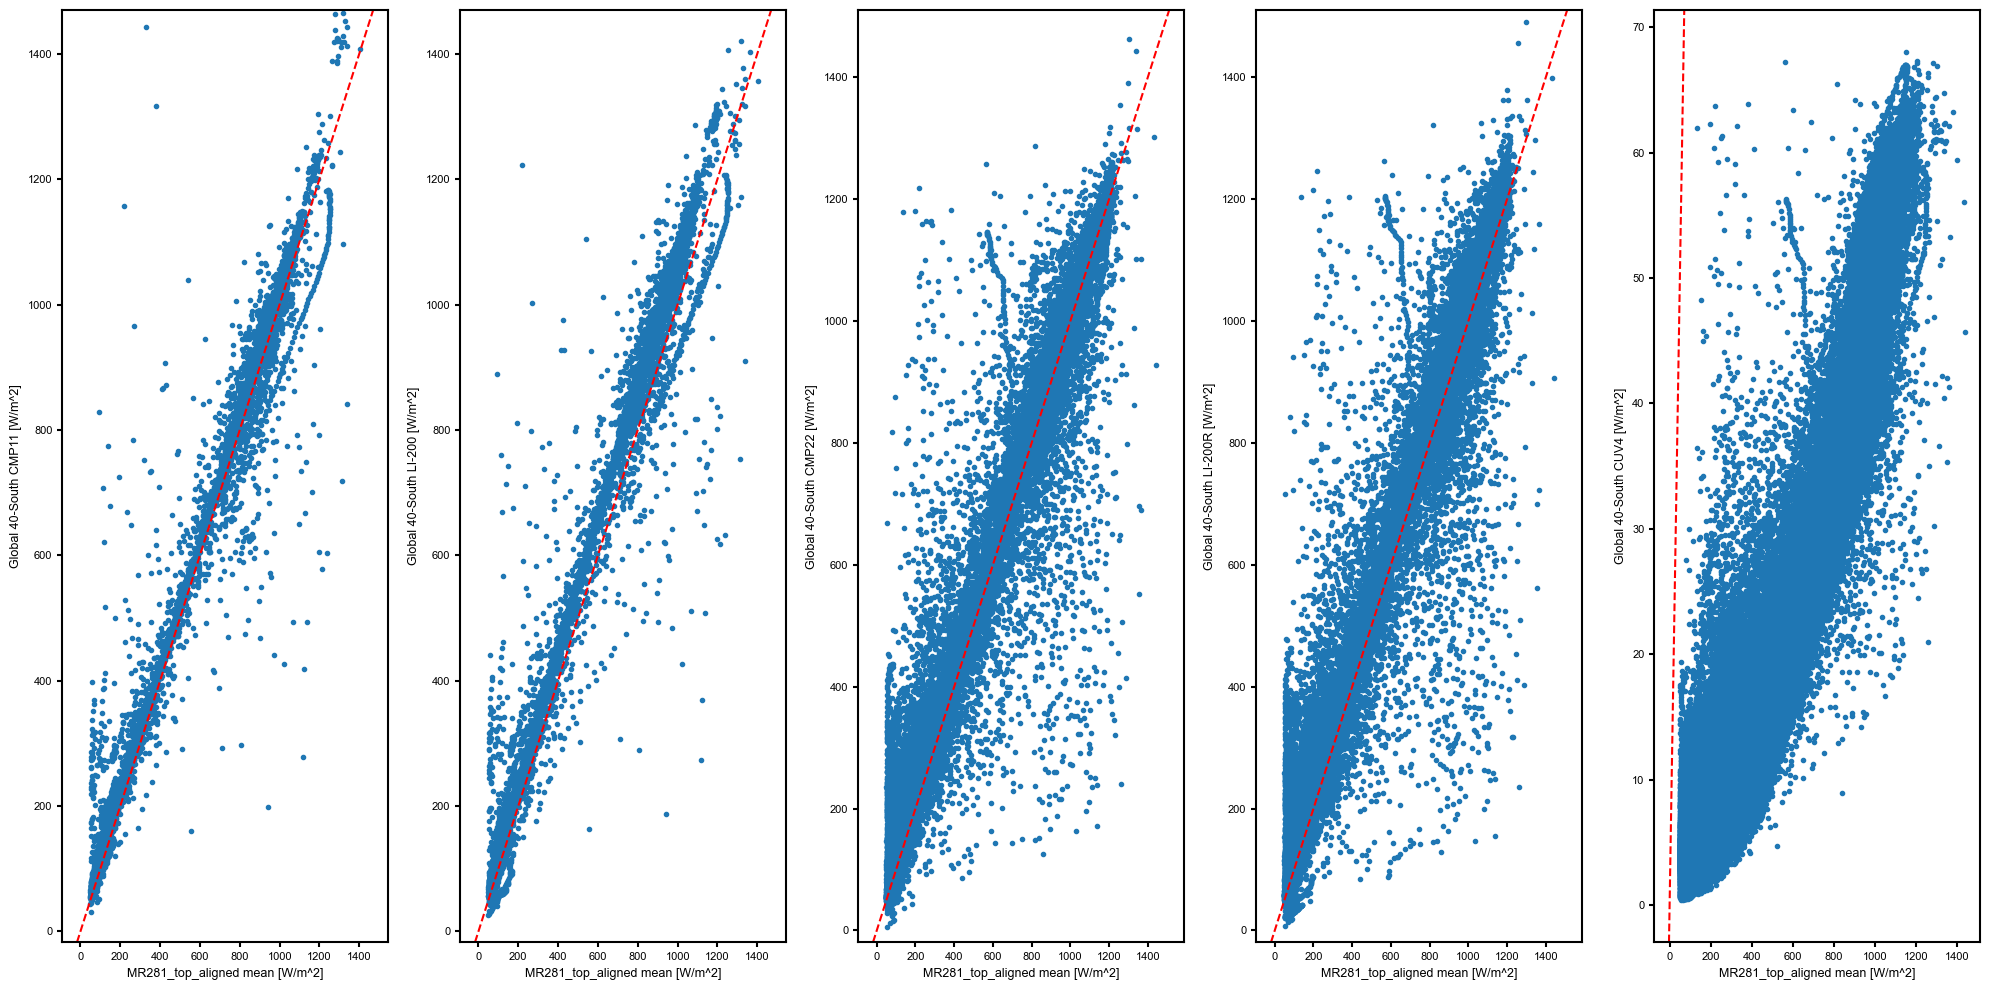

In [100]:
def calc_pearson(actual, predic):
    return -1*actual.corr(predic)

pearson_dev = []
cols = [x for x in meteo_data_aligned.columns if "W/m" in x]
for col in cols:
    # eucl_dev.append(calc_euclidean_dev(integrated_spectra, meteo_sync[col]))
    # perc_dev.append(calc_percent_dev(integrated_spectra, meteo_sync[col]))
    # cheby_dev.append(calc_chebi_dev(integrated_spectra, meteo_sync[col]))
    pearson_dev.append(calc_pearson(pd.Series(MR281_top_aligned['irrad_mean'], index = meteo_data_aligned[col].index), meteo_data_aligned[col]))



# df_deviations = pd.DataFrame({'sensor':cols,"Euclid": eucl_dev, "Percentage": perc_dev, "Chebychev": cheby_dev, "Pearson": pearson_dev})
df_deviations = pd.DataFrame({'sensor':cols, "Pearson": pearson_dev})
df_rank = df_deviations.iloc[:,1:].rank()
df_rank['median'] = df_rank.median(axis=1)
df_rank_sort = df_rank.sort_values('median')

n = 5
fig, ax = plt.subplots(1, n, figsize=[20, 10])
for i in range(n):
    idx = df_rank_sort.index[i]
    ax[i].plot(MR281_top_aligned['irrad_mean'], meteo_data_aligned[cols[idx]], ".", label=f"{cols[idx]}")
    ax_lims = max(ax[i].get_xlim(), ax[i].get_ylim())
    ax[i].set_ylim(ax_lims)
    ax[i].plot(ax_lims,ax_lims, "r--")
    ax[i].set_xlabel(f"MR281_top_aligned mean [W/m^2]")
    ax[i].set_ylabel(f"{cols[idx]}")


plt.tight_layout()

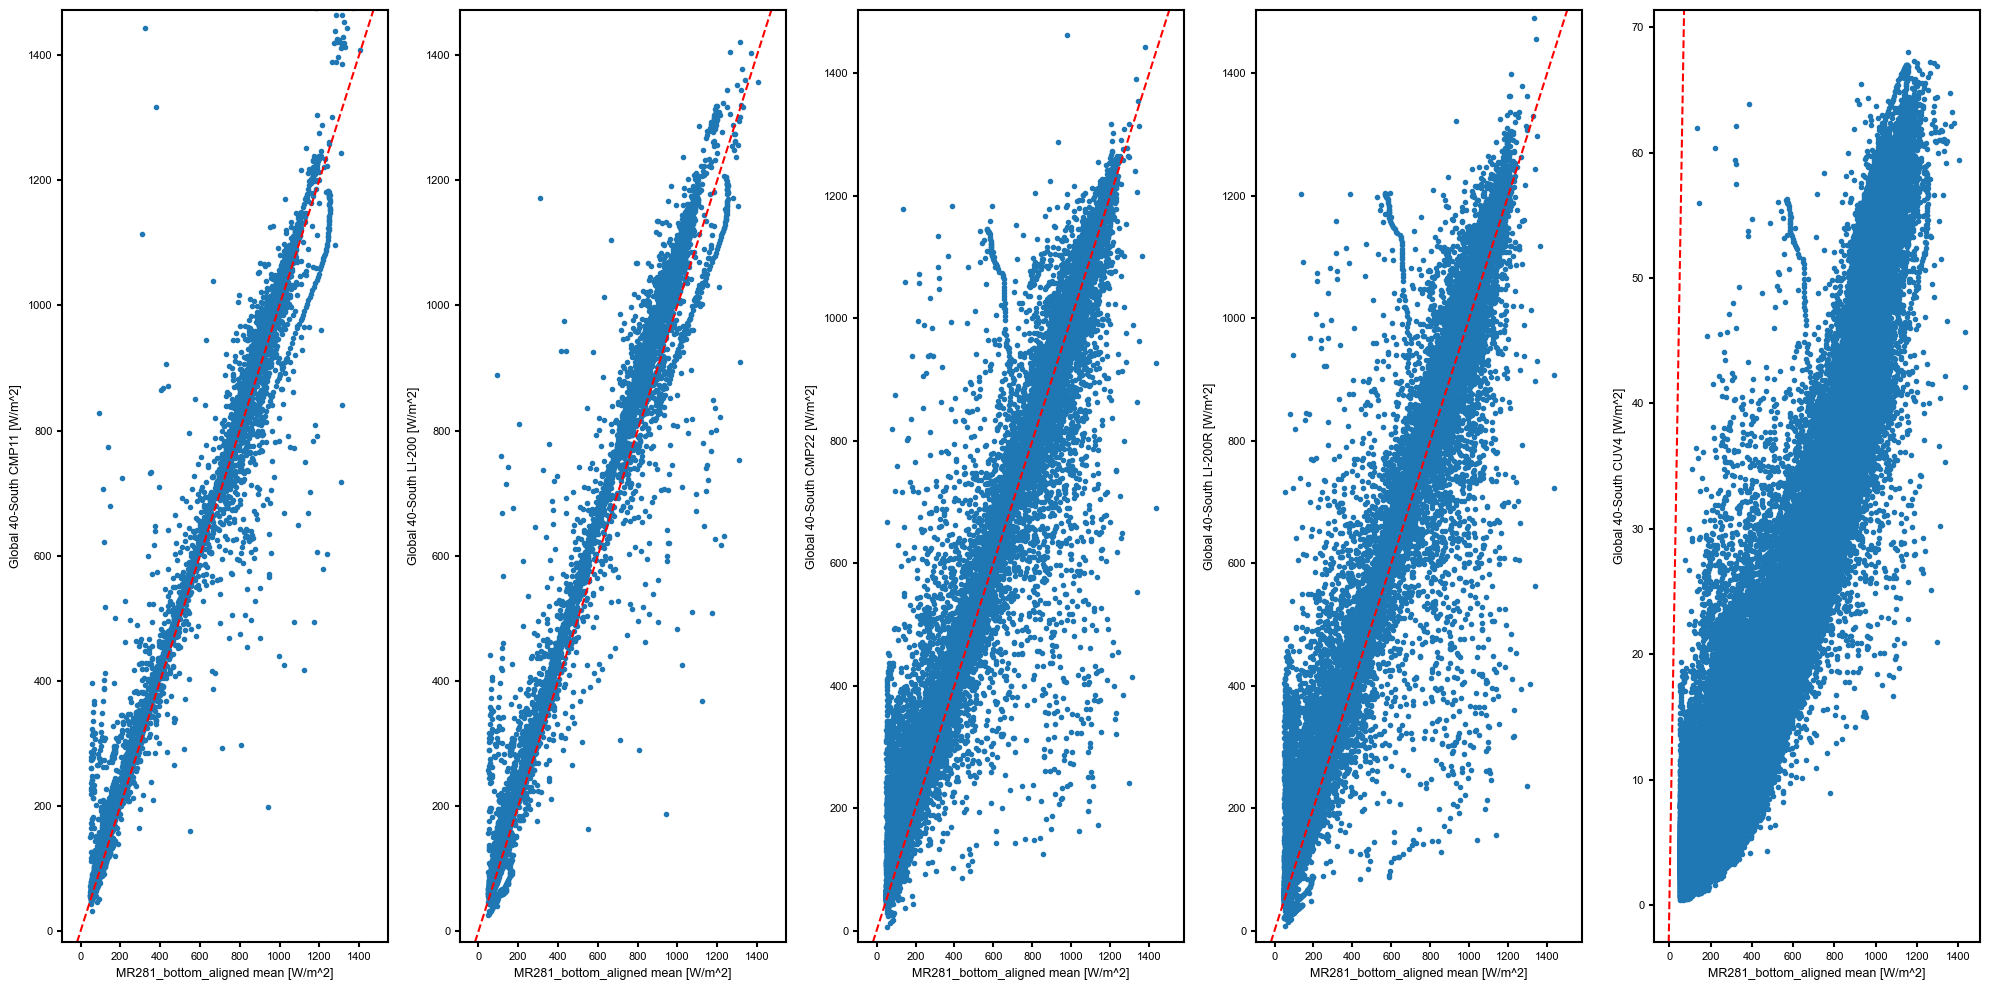

In [101]:
def calc_pearson(actual, predic):
    return -1*actual.corr(predic)

pearson_dev = []
cols = [x for x in meteo_data_aligned.columns if "W/m" in x]
for col in cols:
    # eucl_dev.append(calc_euclidean_dev(integrated_spectra, meteo_sync[col]))
    # perc_dev.append(calc_percent_dev(integrated_spectra, meteo_sync[col]))
    # cheby_dev.append(calc_chebi_dev(integrated_spectra, meteo_sync[col]))
    pearson_dev.append(calc_pearson(pd.Series(MR281_bottom_aligned['irrad_mean'], index = meteo_data_aligned[col].index), meteo_data_aligned[col]))

# df_deviations = pd.DataFrame({'sensor':cols,"Euclid": eucl_dev, "Percentage": perc_dev, "Chebychev": cheby_dev, "Pearson": pearson_dev})
df_deviations = pd.DataFrame({'sensor':cols, "Pearson": pearson_dev})
df_rank = df_deviations.iloc[:,1:].rank()
df_rank['median'] = df_rank.median(axis=1)
df_rank_sort = df_rank.sort_values('median')

n = 5
fig, ax = plt.subplots(1, n, figsize=[20, 10])
for i in range(n):
    idx = df_rank_sort.index[i]
    ax[i].plot(MR281_bottom_aligned['irrad_mean'], meteo_data_aligned[cols[idx]], ".", label=f"{cols[idx]}")
    ax_lims = max(ax[i].get_xlim(), ax[i].get_ylim())
    ax[i].set_ylim(ax_lims)
    ax[i].plot(ax_lims,ax_lims, "r--")
    ax[i].set_xlabel(f"MR281_bottom_aligned mean [W/m^2]")
    ax[i].set_ylabel(f"{cols[idx]}")


plt.tight_layout()

In [102]:
# Use a date range for OTF and WISER spectra and calculate the spectral power for the wavelength range of the OTF spectrometer.
# Use the actual date range, calculate the spectral power, find this spectral power in the WISER array and use the corresponding full wavelength spectra of the WISER for the current calculations.
# get he wiser spectral data
# wiser_global_tilt = Spectra.get_srrl_wiser_global_tilt(pd.Timestamp(2022,5,1), pd.Timestamp.now())
with open("wiser_global_tilt.p", "rb") as fin:
    wiser_global_tilt = pickle.load(fin)

max_otf_wavelength = meteo_spectra.wavelength.max()
otf_global_spec_power = meteo_spectra.SpecPower
wiser_global_spec_power = np.trapz(x=wiser_global_tilt.wavelength[wiser_global_tilt.wavelength <= max_otf_wavelength],y=wiser_global_tilt.spectra.iloc[:,wiser_global_tilt.wavelength <= max_otf_wavelength])
otf_ape = calc_ape(meteo_spectra.spectra.iloc[:,meteo_spectra.wavelength <= max_otf_wavelength])
wiser_ape = calc_ape(wiser_global_tilt.spectra.iloc[:,wiser_global_tilt.wavelength <= max_otf_wavelength])


## Comparing missing spectral irradiance for OTF vs WISE or AM1.5G spectra

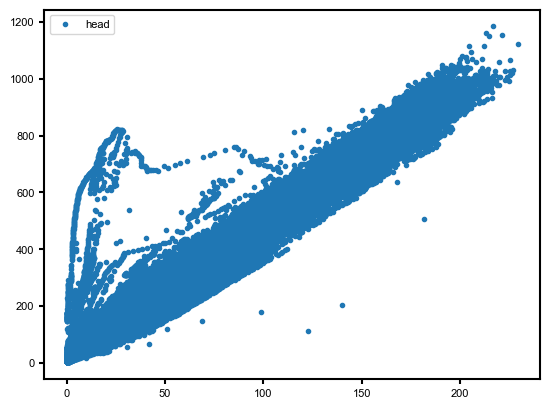

In [103]:
# filter spectra according to irradiance and remove spectra with all negative
wiser_irradiance_filter = (wiser_global_spec_power > 0) & ((wiser_global_tilt.spectra > 0).all(axis=1))
ape_filtered = wiser_ape[wiser_irradiance_filter]
irr_filtered = wiser_global_spec_power[wiser_irradiance_filter]
wiser_global_tilt_spectra_filtered = wiser_global_tilt.spectra[wiser_irradiance_filter]

wiser_global_spec_power_head = np.trapz(x=wiser_global_tilt.wavelength[wiser_global_tilt.wavelength <= max_otf_wavelength],y=wiser_global_tilt_spectra_filtered.iloc[:,wiser_global_tilt.wavelength <= max_otf_wavelength])
wiser_global_spec_power_tail = np.trapz(x=wiser_global_tilt.wavelength[wiser_global_tilt.wavelength > max_otf_wavelength],y=wiser_global_tilt_spectra_filtered.iloc[:,wiser_global_tilt.wavelength > max_otf_wavelength])
fig,ax = plt.subplots()
ax.plot(wiser_global_spec_power_tail,wiser_global_spec_power_head,'.')
ax.legend(['head','tail'])

### Approach to take a median spectra from the outdoor WISER spectrometer

In [104]:
# Get a median spectra
median_spectra = wiser_global_tilt_spectra_filtered.median(axis=0)
# Get a median head and tail spectra where head is all with wavelength lower and tail with wavelength higher than the cut-off wavelength of the OTF sensor
median_head = median_spectra[wiser_global_tilt.wavelength <= max_otf_wavelength]
median_tail = median_spectra[wiser_global_tilt.wavelength > max_otf_wavelength]


Test spectra tail spectral power 2.26 W/m^2 vs median spectra scaled tail spectral power 2.16 - deviation = 4.81%


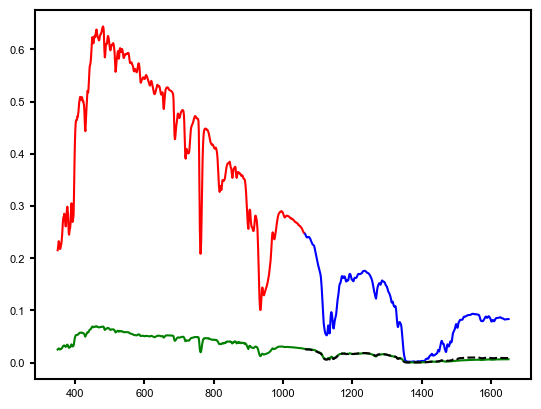

In [105]:
# plot it
fig, ax = plt.subplots()
# ax.plot(median_spectra,'k')
ax.plot(median_head,'r')
ax.plot(median_tail,'b')

#get a random test spectra to compare scaling the tail spectra
rand_spectra_idx = np.random.randint(len(wiser_global_tilt_spectra_filtered))
test_spectra  =wiser_global_tilt_spectra_filtered.iloc[rand_spectra_idx,:]
ax.plot(test_spectra,'g')

# Calculate the irradiance of the head spectra and the test spectra for the same head spectral wavelength range
scaler = np.trapz(test_spectra[wiser_global_tilt.wavelength <= max_otf_wavelength]) / np.trapz(median_head)

# sclale the tail spectra with the scaler
ax.plot(median_tail * scaler,'k--')

# calculate power in test spectra tail
test_tail_power = np.trapz(test_spectra[(test_spectra.index > max_otf_wavelength) & (test_spectra.index <= bc_eqe.index[-1])])
# calculate power in scaled AM1.5 spectra tail
median_scaled_tail_power = np.trapz(median_tail[(median_tail.index > max_otf_wavelength) & (median_tail.index  <= bc_eqe.index[-1])] * scaler)

print(f"Test spectra tail spectral power {test_tail_power:.2f} W/m^2 vs median spectra scaled tail spectral power {median_scaled_tail_power:.2f} - deviation = {abs(1 - test_tail_power / median_scaled_tail_power) * 100:.2f}%")


### Approach to take a AM1.5G spectra

Test spectra tail spectral power 2.26 W/m^2 vs AM1.5g scaled tail spectral power 2.05 - deviation = 10.46%


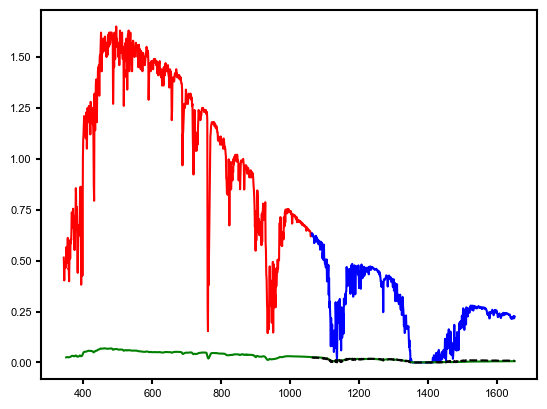

In [106]:
fig, ax = plt.subplots()
# ax.plot(am15g[(am15g.index >= meteo_spectra.wavelength[0]) & (am15g.index <= meteo_spectra.wavelength[-1])],'k')
am15g_head = am15g[(am15g.index >= meteo_spectra.wavelength[0]) & (am15g.index <= max_otf_wavelength)]
am15g_tail = am15g[(am15g.index >= max_otf_wavelength) & (am15g.index <= wiser_global_tilt.wavelength.max())]
ax.plot(am15g_head,'r')
ax.plot(am15g_tail,'b')


#get a random test spectra to compare scaling the tail spectra
test_spectra  =wiser_global_tilt_spectra_filtered.iloc[rand_spectra_idx,:]
ax.plot(test_spectra,'g')

# Calculate the irradiance of the head spectra and the test spectra for the same head spectral wavelength range
scaler = np.trapz(test_spectra[wiser_global_tilt.wavelength <= max_otf_wavelength]) / np.trapz(am15g[(am15g.index >= test_spectra.index[0]) & (am15g.index <= max_otf_wavelength)])

ax.plot(am15g_tail * scaler,'k--')


# calculate power in test spectra tail
test_tail_power = np.trapz(test_spectra[(test_spectra.index > max_otf_wavelength) & (test_spectra.index <= bc_eqe.index[-1])])
# calculate power in scaled AM1.5 spectra tail
am15g_scaled_tail_power = np.trapz(am15g_tail[(am15g_tail.index > max_otf_wavelength) & (am15g_tail.index  <= bc_eqe.index[-1])] * scaler)


print(f"Test spectra tail spectral power {test_tail_power:.2f} W/m^2 vs AM1.5g scaled tail spectral power {am15g_scaled_tail_power:.2f} - deviation = {abs(1 - test_tail_power / am15g_scaled_tail_power) * 100:.2f}%")

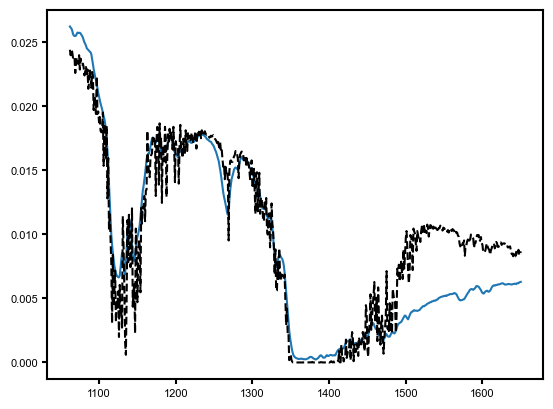

In [107]:
fig, ax = plt.subplots()
ax.plot(test_spectra[(test_spectra.index >= am15g_tail.index[0]) & (test_spectra.index <= am15g_tail.index[-1])])
ax.plot(am15g_tail * scaler,'k--')


## Correction for the tail of the OTF spectra

In [108]:
# interpolate am1.5g spectra with OTF spectra
am15g_interp_func = interp1d(am15g.index, am15g.values)

am15g_interp_head = pd.Series(am15g_interp_func(meteo_spectra_aligned.wavelength), index=meteo_spectra_aligned.wavelength)
am15g_interp_head_power = np.trapz(x=am15g_interp_head.index, y=am15g_interp_head.values)

scalers = scaler = meteo_spectra_aligned.SpecPower / am15g_interp_head_power

am15g_tail = am15g[(am15g.index > max_otf_wavelength) & (am15g.index <= 1200)]
am15g_tail_scaled = pd.DataFrame(np.outer(scalers,am15g_tail), index = scalers.index, columns=am15g_tail.index)

spectra_corr = pd.concat([meteo_spectra_aligned.spectra, am15g_tail_scaled], axis=1)

meteo_spectra_corr = pvc.Meteo(
        wavelength=spectra_corr.columns.astype(np.int32),
        spectra=spectra_corr,
        ambient_temperature=meteo_spectra_aligned.temp,
        wind=meteo_spectra_aligned.wind,
        daytime=spectra_corr.index,
    )
meteo_spectra_aligned = meteo_spectra_corr

In [109]:
# fig, axs = plt.subplots(2, 3, figsize=(10, 10))

# corr_factor_top = np.polyfit(MR281_top_aligned["irrad_mean"], meteo_spectra_aligned.SpecPower, 1)
# corr_factor_bottom = np.polyfit(MR281_bottom_aligned["irrad_mean"], meteo_spectra_aligned.SpecPower, 1)
# corr_factor = np.mean([corr_factor_top, corr_factor_bottom], axis=0)

# # e1 = np.trapz(x=meteo_spectra_aligned.wavelength, y=meteo_spectra_aligned.spectra.iloc[0,:])
# # e2 = np.trapz(x=meteo_spectra_aligned.wavelength, y=meteo_spectra_aligned.spectra * (1/corr_factor[0])) - meteo_spectra_aligned.SpecPower/corr_factor[0]
# # plt.plot(meteo_spectra_aligned.spectra.iloc[0,:])
# # plt.plot(meteo_spectra_aligned.spectra.iloc[0,:] * (1/corr_factor[0]))

# meteo_spectra_aligned.spectra = meteo_spectra_aligned.spectra * 1/corr_factor[0]
# meteo_spectra_aligned.SpecPower = meteo_spectra_aligned.SpecPower * 1/corr_factor[0]

# # axs[0, 0].plot(meteo_spectra_aligned.SpecPower, MR281_top_aligned["isc"], "b.", alpha=0.2)
# axs[0, 0].plot(meteo_spectra_aligned.SpecPower, MR281_top_aligned["isc"], "b.")
# axs[0, 1].plot(MR281_top_aligned["irrad_mean"], MR281_top_aligned["isc"], "b.")
# # axs[0, 2].plot(MR281_top_aligned["irrad_mean"], meteo_spectra_aligned.SpecPower, "b.", alpha=0.2)
# axs[0, 2].plot(MR281_top_aligned["irrad_mean"], meteo_spectra_aligned.SpecPower, "b.")

# # axs[1, 0].plot(meteo_spectra_aligned.SpecPower, MR281_bottom_aligned["isc"], "b.", alpha=0.2)
# axs[1, 0].plot(meteo_spectra_aligned.SpecPower, MR281_bottom_aligned["isc"], "b.")
# axs[1, 1].plot(MR281_bottom_aligned["irrad_mean"], MR281_bottom_aligned["isc"], "b.")
# axs[1, 2].plot(MR281_bottom_aligned["irrad_mean"], meteo_spectra_aligned.SpecPower, "b.")

# # confidence_filter = np.abs(meteo_spectra_aligned.SpecPower - MR281_top_aligned["irrad_mean"]) / np.sqrt(2) < 50

# # axs[0, 0].plot(meteo_spectra_aligned.SpecPower[confidence_filter] , MR281_top_aligned["isc"][confidence_filter], "r.")
# # axs[0, 1].plot(MR281_top_aligned["irrad_mean"][confidence_filter], MR281_top_aligned["isc"][confidence_filter], "r.")
# # axs[0, 2].plot(MR281_top_aligned["irrad_mean"][confidence_filter], meteo_spectra_aligned.SpecPower[confidence_filter], "r.")

# # confidence_filter = np.abs(meteo_spectra_aligned.SpecPower  - MR281_bottom_aligned["irrad_mean"]) / np.sqrt(2) < 50

# # axs[1, 0].plot(meteo_spectra_aligned.SpecPower[confidence_filter] , MR281_bottom_aligned["isc"][confidence_filter], "r.")
# # axs[1, 1].plot(MR281_bottom_aligned["irrad_mean"][confidence_filter], MR281_bottom_aligned["isc"][confidence_filter], "r.")
# # axs[1, 2].plot(MR281_bottom_aligned["irrad_mean"][confidence_filter], meteo_spectra_aligned.SpecPower[confidence_filter] , "r.")



# xticks = axs[0, 2].get_xticks()
# axs[0, 2].set_yticks(xticks)

# xticks = axs[1, 2].get_xticks()
# axs[1, 2].set_yticks(xticks)

# ax_lims = (0, 1500)
# axs[0, 2].set_ylim(ax_lims)
# axs[1, 2].set_ylim(ax_lims)
# axs[0, 2].plot(ax_lims, ax_lims, "r--")
# axs[1, 2].plot(ax_lims, ax_lims, "r--")


# axs[0, 0].set_xlabel("Spectral power")
# axs[0, 1].set_xlabel("Sensor irradiance")
# axs[0, 2].set_xlabel("Sensor irradiance")
# axs[0, 0].set_ylabel("TC Isc")
# axs[0, 1].set_ylabel("TC Isc")
# axs[0, 2].set_ylabel("Spectral power")

# axs[1, 0].set_xlabel("Spectral power")
# axs[1, 1].set_xlabel("Sensor irradiance")
# axs[1, 2].set_xlabel("Sensor irradiance")
# axs[1, 0].set_ylabel("BC Isc")
# axs[1, 1].set_ylabel("BC Isc")
# axs[1, 2].set_ylabel("Spectral power")

# plt.tight_layout()


C:\Users\rwitteck\AppData\Local\Temp\1\ipykernel_22744\891285756.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees


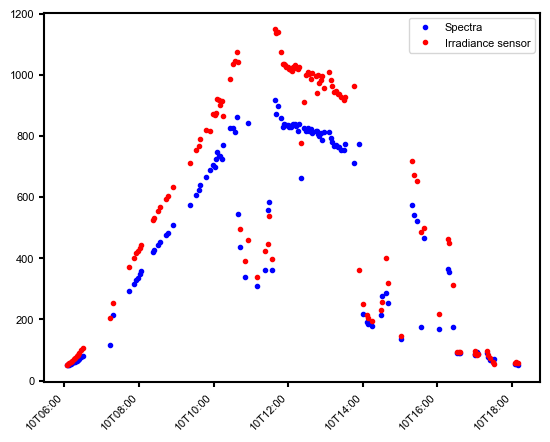

In [110]:
start_date = pd.Timestamp(2020,8,22)
start_date = pd.Timestamp(2020,8,10)
end_date = start_date + pd.Timedelta(days=1)
day_flt = (meteo_spectra_aligned.SpecPower.index > start_date) & (meteo_spectra_aligned.SpecPower.index < end_date)
fig,axs = plt.subplots(1)
axs.plot(meteo_spectra_aligned.SpecPower[day_flt],"b.")
axs.plot(MR281_top_aligned['irrad_mean'][day_flt],"r.")

axs.set_xticklabels(axs.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees
axs.xaxis.set_major_formatter(mdates.DateFormatter('%dT%H:%M'))
meteo_spectra_aligned.SpecPower.index.min()
axs.legend(['Spectra','Irradiance sensor'])

Plot irradiance as function of angle of incidence

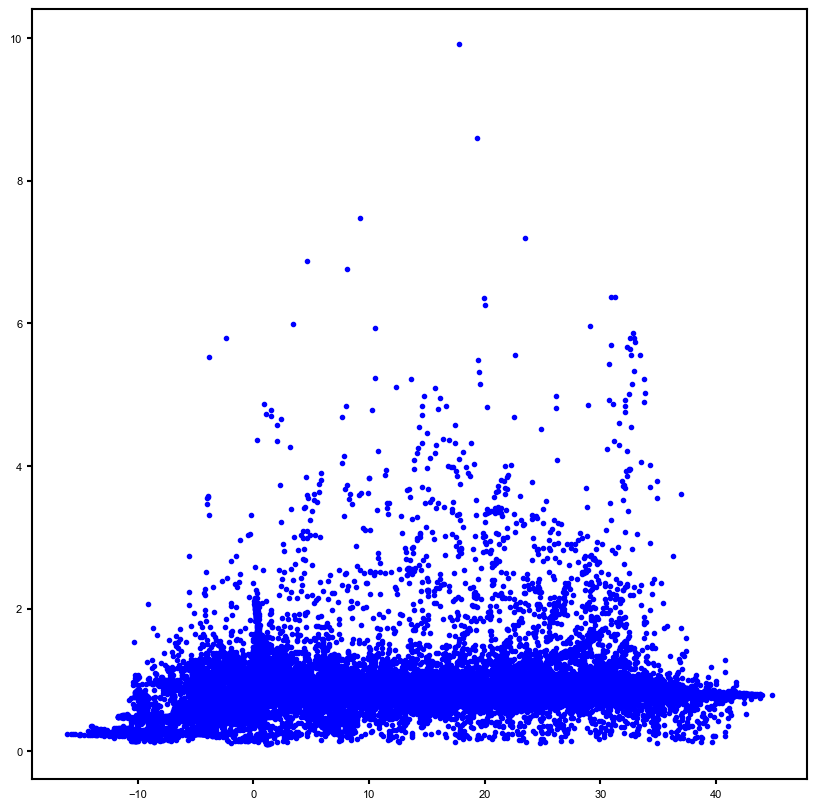

In [111]:
fig,axs = plt.subplots(1,1, figsize=(10,10))

max_irr = max(max(meteo_spectra_corr.SpecPower), max(MR281_top_aligned['irrad_mean']))

# axs.plot(MR281_top_aligned['spa_arrayaoi'],MR281_top_aligned['irrad_mean'] * MR281_top_aligned['isc'],"r.")
axs.plot(MR281_top_aligned['temp_module_mean'],meteo_spectra_corr.SpecPower / MR281_top_aligned['irrad_mean'],"b.")
# axs[0,0].plot(MR281_top_aligned['spa_arrayaoi'],meteo_spectra_aligned.SpecPower,"b.")

# axs[1,0].plot(meteo_spectra_aligned.SpecPower,MR281_bottom_aligned['isc'],"b.")
# axs[1,1].plot(MR281_bottom_aligned['irrad_mean'],MR281_bottom_aligned['isc'],"b.")
# axs[1,2].plot(MR281_bottom_aligned['irrad_mean'],meteo_spectra_aligned.SpecPower,"b.")

# confidence_filter = np.abs(meteo_spectra_aligned.SpecPower - MR281_top_aligned['irrad_mean'])/np.sqrt(2) < 50

# axs[0,0].plot(meteo_spectra_aligned.SpecPower[confidence_filter],MR281_top_aligned['isc'][confidence_filter],"r.")
# axs[0,1].plot(MR281_top_aligned['irrad_mean'][confidence_filter],MR281_top_aligned['isc'][confidence_filter],"r.")
# axs[0,2].plot(MR281_top_aligned['irrad_mean'][confidence_filter],meteo_spectra_aligned.SpecPower[confidence_filter],"r.")

# confidence_filter = np.abs(meteo_spectra_aligned.SpecPower - MR281_bottom_aligned['irrad_mean'])/np.sqrt(2) < 50

# axs[1,0].plot(meteo_spectra_aligned.SpecPower[confidence_filter],MR281_bottom_aligned['isc'][confidence_filter],"r.")
# axs[1,1].plot(MR281_bottom_aligned['irrad_mean'][confidence_filter],MR281_bottom_aligned['isc'][confidence_filter],"r.")
# axs[1,2].plot(MR281_bottom_aligned['irrad_mean'][confidence_filter],meteo_spectra_aligned.SpecPower[confidence_filter],"r.")


# for ax in axs.ravel():
#     # ax.axis('square')
#     ax.set_xlim(0,1500)
#     ax.set_box_aspect(1)

# axs[0,2].set_ylim(0,1500)
# axs[1,2].set_ylim(0,1500)

# xticks = axs[0,2].get_xticks()
# axs[0,2].set_yticks(xticks)

# xticks = axs[1,2].get_xticks()
# axs[1,2].set_yticks(xticks)

# axs[0,0].set_xlabel("Spectral power")
# axs[0,1].set_xlabel("Sensor irradiance")
# axs[0,2].set_xlabel("Sensor irradiance")
# axs[0,0].set_ylabel("TC Isc")
# axs[0,1].set_ylabel("TC Isc")
# axs[0,2].set_ylabel("Spectral power")

# axs[1,0].set_xlabel("Spectral power")
# axs[1,1].set_xlabel("Sensor irradiance")
# axs[1,2].set_xlabel("Sensor irradiance")
# axs[1,0].set_ylabel("BC Isc")
# axs[1,1].set_ylabel("BC Isc")
# axs[1,2].set_ylabel("Spectral power")

# plt.tight_layout()


Fit the IV from outdoor testsite which are close to STC conditions

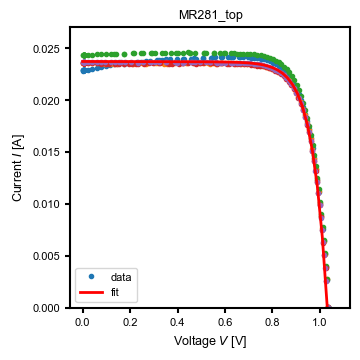

In [112]:
fig, axs = plt.subplots(1,1, constrained_layout = True, figsize=get_figsize(252, fraction = 1, ratio=1,rows=1,cols=1))
tc_iv_params = []
df_module = MR281_top_aligned[
    (MR281_top_aligned["irrad_mean"] > 995)
    & (MR281_top_aligned["irrad_mean"] < 1005)
    & (MR281_top_aligned["temp_module_mean"] > 24.5)
    & (MR281_top_aligned["temp_module_mean"] < 25.5)
    & (MR281_top_aligned["aoi"] < 15)
    # & (MR281_top_aligned.index > pd.Timestamp(2020,9,15))

]
idx = 0
for _, row in df_module.iterrows():
    # v_sorter = np.argsort(row["v"])
    # v = row["v"][v_sorter]
    # i = row["i"][v_sorter]
    v, i = row["v"], row["i"]
    v, i = simple_interp_VocIscPmpp(v, i)
    v, i = rectify_iv_curve(v, i)
    # interpolate
    # vint = np.linspace(v[0],v[-1],150)
    # iint = np.interp(vint, v, i)
    # v = vint
    # i = iint

    # if row["v"] and row["i"]:
    iv_params = fit_sandia_simple(v, i)
    if all(np.array(iv_params) > 0):
    # if any(np.array(iv_params) < 0):
        fit = singlediode(*iv_params, ivcurve_pnts=30)
        if idx == 0:
            axs.plot(v, i, ".", label = 'data')
            idx = 1
        else:
            axs.plot(v, i, ".")


        # axs.plot(fit["v"], fit["i"], "--", label="psc-fit")

        iv_params = list(iv_params)
        iv_params[0] = iv_params[0] * 1000 /row['irrad_mean']

        tc_iv_params.append(iv_params)

tc_iv_params = np.array(tc_iv_params).mean(axis=0)
(tc_isc, tc_io, tc_rs, tc_rsh, tc_nNsVth) = tc_iv_params

jo_scale = 1000
A = 1
TC = 25
tc_jsc = tc_isc / A  # [A/cm^2]
tc_jo = tc_io / A
tc_n = tc_nNsVth / pvc.junction.Vth(TC)
tc_jdb = pvc.junction.Jdb(TC=TC, Eg=device_tc_eg_25)
tc_joratio = jo_scale * tc_jo / (tc_jdb * jo_scale) ** (1.0 / tc_n)

tc_rser = tc_rs * A
tc_gsh = 1 / (tc_rsh * A)

tc_sj = pvc.Multi2T(name="TC", area=A, Jext=tc_jsc, Eg_list=[device_tc_eg_25], n=[tc_n], J0ratio=[tc_joratio])
tc_sj.set(Rs2T=tc_rser, Gsh=tc_gsh)
tc_sj.j[0]


MPP = tc_sj.MPP()

bc_voc = MPP["Voc"]
Isc = MPP["Isc"]

pvc_voltage_set = np.linspace(0, bc_voc)
pvc_current_set = np.linspace(0, Isc)

pvc_voltage_calc = np.zeros_like(pvc_voltage_set)
pvc_current_calc = np.zeros_like(pvc_current_set)

V2Tvect = np.vectorize(tc_sj.V2T)
I2Tvect = np.vectorize(tc_sj.I2T)

pvc_current_calc = I2Tvect(pvc_voltage_set)
pvc_voltage_calc = V2Tvect(pvc_current_set)

Vboth = np.concatenate((pvc_voltage_calc, pvc_voltage_set), axis=None)
Iboth = np.concatenate((pvc_current_set, pvc_current_calc), axis=None)
        # sort
p = np.argsort(Vboth)
Vlight = Vboth[p]
Ilight = -1 * Iboth[p]


axs.plot(Vlight,Ilight, 'r-',lw=2, label ='fit')

axs.set_ylim(bottom=0)
axs.set_title("MR281_top")
axs.set_xlabel(r"Voltage $V$ [V]")
axs.set_ylabel(r"Current $I$ [A]")
axs.set_box_aspect(1)
axs.legend()
plt.show()

In [113]:
MR281_bottom_aligned[
    (MR281_bottom_aligned["irrad_mean"] > 995)
    & (MR281_bottom_aligned["irrad_mean"] < 1005)
    & (MR281_bottom_aligned["temp_module_mean"] > 24.5)
    & (MR281_bottom_aligned["temp_module_mean"] < 25.5)
    & (MR281_bottom_aligned["aoi"] < 15)
    # & (MR281_bottom_aligned.index < pd.Timestamp(2021,10,1))
]['isc']

timestamp
2020-03-25 13:56:02.735950    0.013642
2020-03-25 14:04:02.054917    0.013570
2020-10-01 12:33:01.573717    0.012756
2020-10-11 12:47:02.792429    0.013431
Name: isc, dtype: float64

use best so far
use best so far
use best so far


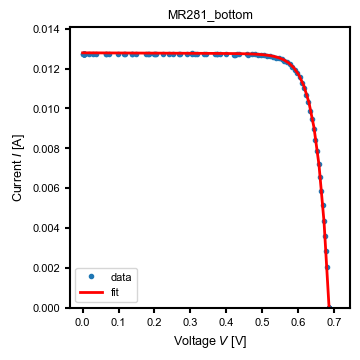

In [114]:
fig, axs = plt.subplots(1,1, constrained_layout = True, figsize=get_figsize(252, fraction = 1, ratio=1,rows=1,cols=1))
bc_iv_params = []
df_module = MR281_bottom_aligned[
    (MR281_bottom_aligned["irrad_mean"] > 995)
    & (MR281_bottom_aligned["irrad_mean"] < 1005)
    & (MR281_bottom_aligned["temp_module_mean"] > 24.5)
    & (MR281_bottom_aligned["temp_module_mean"] < 25.5)
    & (MR281_bottom_aligned["aoi"] < 15)
    # & (MR281_bottom_aligned["ambient_temperature"] > 0)
    & (MR281_bottom_aligned.index > pd.Timestamp(2019,10,1))
]
idx = 0

for _, row in df_module.iterrows():
    # v_sorter = np.argsort(row["v"])
    # v = row["v"][v_sorter]
    # i = row["i"][v_sorter]
    v, i = row["v"], row["i"]
    v, i = simple_interp_VocIscPmpp(v, i)
    v, i = rectify_iv_curve(v, i)
    # interpolate
    # vint = np.linspace(v[0],v[-1],150)
    # iint = np.interp(vint, v, i)
    # v = vint
    # i = iint

    # if row["v"] and row["i"]:
    iv_params = fit_sandia_simple(v, i)
    if all(np.array(iv_params) > 0):
    # if any(np.array(iv_params) < 0):
        fit = singlediode(*iv_params, ivcurve_pnts=30)
        if idx == 0:
            axs.plot(v, i, ".",label='data')
        else:
            axs.plot(v, i, ".")
        # axs.plot(fit["v"], fit["i"], "--", label="psc-fit")
        iv_params = list(iv_params)
        iv_params[0] = iv_params[0] * 1000 /row['irrad_mean']
        bc_iv_params.append(iv_params)

bc_iv_params = np.array(bc_iv_params).mean(axis=0)
(bc_isc, bc_io, bc_rs, bc_rsh, bc_nNsVth) = bc_iv_params

jo_scale = 1000
A = 1
TC = 25
bc_jsc = bc_isc / A  # [A/cm^2]
bc_jo = bc_io / A
bc_n = bc_nNsVth / pvc.junction.Vth(TC)
bc_jdb = pvc.junction.Jdb(TC=TC, Eg=device_bc_eg_25)
bc_joratio = jo_scale * bc_jo / (bc_jdb * jo_scale) ** (1.0 / bc_n)

bc_rser = bc_rs * A
bc_gsh = 1 / (bc_rsh * A)

bc_sj = pvc.Multi2T(name="TC", area=A, Jext=bc_jsc, Eg_list=[device_bc_eg_25], n=[bc_n], J0ratio=[bc_joratio])
bc_sj.set(Rs2T=bc_rser, Gsh=bc_gsh)
bc_sj.j[0]


MPP = bc_sj.MPP()

bc_voc = MPP["Voc"]
Isc = MPP["Isc"]

pvc_voltage_set = np.linspace(0, bc_voc)
pvc_current_set = np.linspace(0, Isc)

pvc_voltage_calc = np.zeros_like(pvc_voltage_set)
pvc_current_calc = np.zeros_like(pvc_current_set)

V2Tvect = np.vectorize(bc_sj.V2T)
I2Tvect = np.vectorize(bc_sj.I2T)

pvc_current_calc = I2Tvect(pvc_voltage_set)
pvc_voltage_calc = V2Tvect(pvc_current_set)

Vboth = np.concatenate((pvc_voltage_calc, pvc_voltage_set), axis=None)
Iboth = np.concatenate((pvc_current_set, pvc_current_calc), axis=None)
        # sort
p = np.argsort(Vboth)
Vlight = Vboth[p]
Ilight = -1 * Iboth[p]


axs.plot(Vlight,Ilight, 'r-',lw=2, label = 'fit')

axs.set_ylim(bottom=0)
axs.set_title("MR281_bottom")
axs.set_xlabel(r"Voltage $V$ [V]")
axs.set_ylabel(r"Current $I$ [A]")
axs.set_box_aspect(1)
axs.legend()
plt.show()

In [155]:
df_module["imp"]

timestamp
2019-10-22 15:33:07.619367    0.007356
2019-10-22 15:39:07.098241    0.006879
2019-10-22 15:43:07.503117    0.006436
2019-10-22 15:45:07.307795    0.006243
2019-10-22 15:50:05.794669    0.006245
                                ...   
2021-01-01 15:40:02.261911    0.006498
2021-01-01 15:42:02.801059    0.006406
2021-01-01 15:44:02.180847    0.006167
2021-01-01 15:46:02.521904    0.006040
2021-01-01 15:48:02.767391    0.005888
Name: imp, Length: 17915, dtype: float64

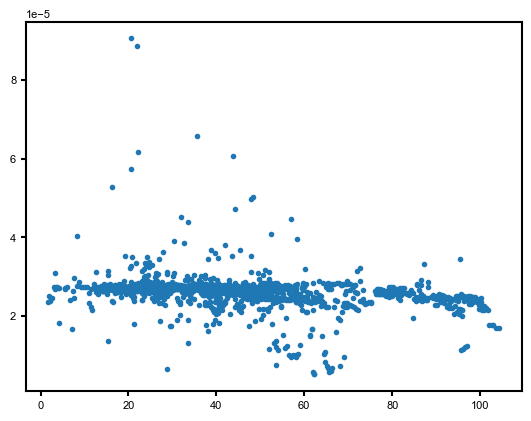

In [163]:
fig, ax = plt.subplots()
df_module = MR281_top_aligned.copy()
t_set = 15
t_diff = 0.5
data_filter = (df_module["temp_module_mean"] >= t_set - t_diff) & (df_module["temp_module_mean"] <= t_set + t_diff)

# data_filter = (
#         (df_module["irrad_mean"] > 50)
#         & (df_module["irrad_mean"] < 1300)
#         & (df_module["temp_module_mean"] > 3)
#         & (df_module.index.date != df_module.index.date[0])
#     )

df_module = df_module[data_filter]
irradiance = meteo_spectra_aligned.SpecPower[data_filter]
ax.plot(df_module["aoi"], df_module["imp"] / irradiance,".")

Temperature coefficients

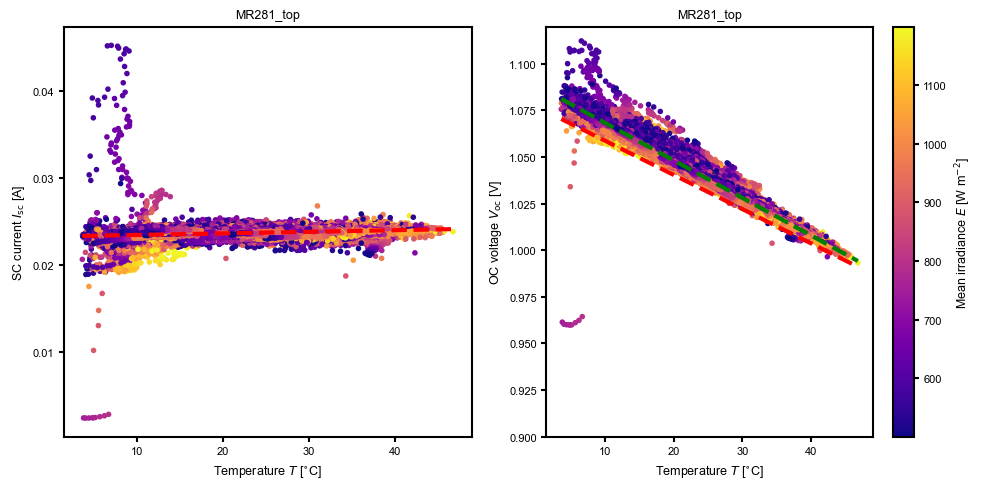

In [115]:


x = []
y1 = []
y2 = []
fig, axs = plt.subplots(1, 2, figsize=(10,5))

df_module = MR281_top_aligned
data_filter = (
        (df_module["irrad_mean"] > 500)
        & (df_module["irrad_mean"] < 1200)
        & (df_module["temp_module_mean"] > 3)
        & (df_module.index.date != df_module.index.date[0])
    )

# data_filter = (
#         (df_module["irrad_mean"] > 50)
#         & (df_module["irrad_mean"] < 1300)
#         & (df_module["temp_module_mean"] > 3)
#         & (df_module.index.date != df_module.index.date[0])
#     )

df_module = df_module[data_filter]
spec_power_aligned = meteo_spectra_aligned.SpecPower[data_filter]
wind_aligned = meteo_spectra_aligned.wind[data_filter]
tcell_test = meteo_spectra_aligned.TempCell[data_filter]

for i, row in df_module.iterrows():
    E0 = 1e3
    deltaT = 3

    # tcell = pvc.EY.sandia_T(df_module["irrad_mean"].loc[i], wind_aligned.loc[i], row["temp_module_mean"])
    # tcell = pvc.EY.sandia_T(spec_power_aligned.loc[i], wind_aligned.loc[i], row["temp_module_mean"])
    tcell = row["temp_module_mean"] + (spec_power_aligned.loc[i]*0.7 / E0) * (deltaT)
    # tcell = row["temp_module_mean"] + (row["irrad_mean"]*0.2 / E0) * (deltaT)


    # tcell = row["temp_module_mean"]
    x.append(tcell)
    # y1.append(row["isc"])
    y1.append(row["isc"] * 1000 / row["irrad_mean"])
    y2.append(row["voc"] - tc_iv_params[-1] / pvc.junction.Vth(25) * pvc.junction.Vth(25) * np.log(row["irrad_mean"] / 1000))
    # y2.append(row["voc"] - tc_iv_params[-1] / pvc.junction.Vth(25) * pvc.junction.Vth(25) * np.log(spec_power_aligned.loc[i] / 1000))

axs[0].scatter(x, y1,None,df_module["irrad_mean"], marker=".", cmap="plasma")
axs[0].set_title("MR281_top")
sp = axs[1].scatter(x, y2,None,df_module["irrad_mean"], marker=".", cmap="plasma")
axs[1].set_title("MR281_top")
fig.colorbar(sp, label="Mean irradiance $E$ [W m$^{-2}$]")

isc_25 = tc_jsc

# fit alpha_isc

tc0 = 25
isc_t_fit = np.polyfit(np.array(x) - tc0, y1, 1)
tc_alpha_isc = isc_t_fit[0]


t_range = np.linspace(np.min(x), np.max(x), 20)
axs[0].plot(t_range, tc_alpha_isc * (t_range - tc0) + isc_25, "r--", lw=3)

voc_fit = []
for t in t_range:
    tc_eg_t = GaAs_eg_shift(t, device_tc_eg_25)
    # tc_sj.set(Eg=tc_eg_t, TC=t, Jext=tc_alpha_isc * t + isc_25)
    tc_sj.set(Eg=tc_eg_t, TC=t, Jext=isc_25)
    voc_fit.append(tc_sj.MPP()["Voc"])
axs[1].plot(t_range, voc_fit, "r--", lw=3)

voc_polyfit = np.polyfit(x, y2, 1)
# axs[1].plot(t_range, np.polyval(voc_polyfit,t_range), "g--", lw=3)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(np.array(x).reshape(-1,1), np.array(y2).reshape(-1,1))
line_y_ransac = ransac.predict(t_range.reshape(-1,1))
axs[1].plot(t_range, line_y_ransac, "g--", lw=3)

axs[0].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[0].set_ylabel(r"SC current $I_\mathrm{sc}$ [A]")
axs[1].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[1].set_ylabel(r"OC voltage $V_\mathrm{oc}$ [V]")
axs[1].set_ylim(bottom=0.9)
plt.tight_layout()


data_filter = (
        (df_module["irrad_mean"] > 990)
        & (df_module["irrad_mean"] < 1010)
        & (df_module["temp_module_mean"] > 3)
        & (df_module.index.date != df_module.index.date[0])
    )

df_module = df_module[data_filter]

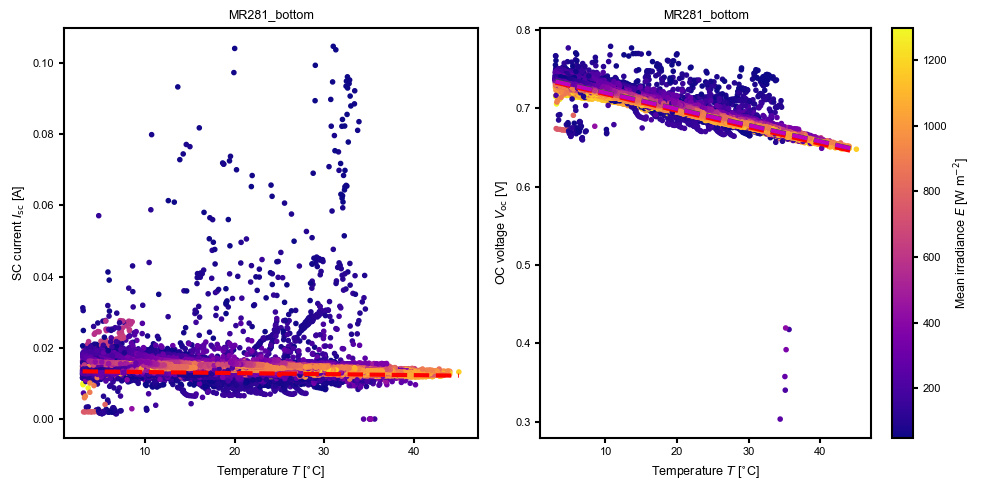

In [67]:
x = []
y1 = []
y2 = []
fig, axs = plt.subplots(1, 2, figsize=(10,5))

df_module = MR281_bottom_aligned
data_filter = (
    (df_module["irrad_mean"] > 550)
    & (df_module["irrad_mean"] < 1050)
    & (df_module["temp_module_mean"] > 3)
    & (df_module["isc"] * 1000 / df_module["irrad_mean"] > 0.01)
    & (df_module["isc"] * 1000 / df_module["irrad_mean"] < 0.0175)
    & (df_module.index.date != df_module.index.date[0])
)

data_filter = (
    (df_module["irrad_mean"] > 50)
    & (df_module["irrad_mean"] < 1300)
    & (df_module["temp_module_mean"] > 3)
    # & (df_module["isc"] * 1000 / df_module["irrad_mean"] < 0.0175)
    & (df_module.index.date != df_module.index.date[0])
)

df_module = df_module[data_filter]
spec_power_aligned = meteo_spectra_aligned.SpecPower[data_filter]
wind_aligned = meteo_spectra_aligned.wind[data_filter]

for i, row in df_module.iterrows():

    # tcell = pvc.EY.sandia_T(((tc_alpha_isc * row["temp_module_mean"]) + 0.1) * spec_power_aligned.loc[i], wind_aligned.loc[i], row["temp_module_mean"])
    # tcell = pvc.EY.sandia_T(spec_power_aligned.loc[i], wind_aligned.loc[i], row["ambient_temperature"])
    # tcell = pvc.EY.sandia_T(spec_power_aligned.loc[i], wind_aligned.loc[i], row["temp_module_mean"])
    # tcell = pvc.EY.sandia_T(0.1*spec_power_aligned.loc[i], wind_aligned.loc[i], row["temp_module_mean"])
    tcell = row["temp_module_mean"] + (spec_power_aligned.loc[i] * 0 / E0) * (deltaT)
    # tcell = row["temp_module_mean"] + (row["irrad_mean"]*0.0 / E0) * (deltaT)

    # tcell = row["temp_module_mean"]
    x.append(tcell)

    # y1.append(row["isc"])
    y1.append(row["isc"] * 1000 / row["irrad_mean"])
    # y1.append(row["isc"] * 1000 / spec_power_aligned.loc[i])
    y2.append(row["voc"] - bc_iv_params[-1] / pvc.junction.Vth(25) * pvc.junction.Vth(25) * np.log(row["irrad_mean"] / 1000))
    # y2.append(row["voc"] - bc_iv_params[-1] / pvc.junction.Vth(25) * pvc.junction.Vth(25) * np.log(spec_power_aligned.loc[i] / 1000))
axs[0].scatter(x, y1, None, df_module["irrad_mean"], marker=".", cmap="plasma")
# ax[0].scatter(x, y1, None, spec_power_aligned, marker=".", cmap="plasma")
axs[0].set_title("MR281_bottom")
sp = axs[1].scatter(x, y2, None, df_module["irrad_mean"], marker=".", cmap="plasma")
axs[1].set_title("MR281_bottom")
fig.colorbar(sp, label="Mean irradiance $E$ [W m$^{-2}$]")

isc_25 = bc_jsc
axs[0].plot(25, bc_jsc, "r.")
t_range = np.linspace(np.min(x), np.max(x), 50)

# fit alpha_isc
tc0 = 25
isc_t_fit = np.polyfit(np.array(x) - tc0, y1, 1)
bc_alpha_isc = isc_t_fit[0]
# ax[0].plot(t_range, bc_alpha_isc*(t_range-25) + isc_t_fit[1], "m--")
axs[0].plot(t_range, bc_alpha_isc * (t_range - tc0) + isc_25, "r--", lw=3)
# isc_25 = isc_t_fit[1]


voc_fit = []
for t in t_range:
    bc_eg_t = Si_eg_shift(t, device_bc_eg_25)
    # bc_eg_t = Si_eg_shift(t, Si_bandgap_25)
    # bc_sj.set(Eg=bc_eg_t, TC=t, Jext=bc_alpha_isc * (t - 25) + isc_25)
    bc_sj.set(Eg=bc_eg_t, TC=t, Jext=isc_25)
    voc_fit.append(bc_sj.MPP()["Voc"])

axs[1].plot(t_range, voc_fit, "r--", lw=3)

voc_polyfit = np.polyfit(x, y2, 1)
axs[1].plot(t_range, np.polyval(voc_polyfit,t_range), "g--", lw=3)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(np.array(x).reshape(-1,1), np.array(y2).reshape(-1,1))
line_y_ransac = ransac.predict(t_range.reshape(-1,1))
axs[1].plot(t_range, line_y_ransac, "m--", lw=3)



axs[0].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[0].set_ylabel(r"SC current $I_\mathrm{sc}$ [A]")
axs[1].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[1].set_ylabel(r"OC voltage $V_\mathrm{oc}$ [V]")
plt.tight_layout()

# axs[1].set_ylim(bottom=0.6)

# axs[1].plot(df_module[data_filter]['temp_module_mean'] + (spec_power_aligned[data_filter] / E0) * (deltaT), df_module[data_filter]['voc'], "rx")
# axs[1].plot(25, bc_voc, "rx", ms=8)


Plot only TC and BC voltage

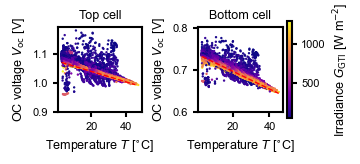

In [68]:
x = []
y1 = []
y2 = []
fig, axs = plt.subplots(1, 2, constrained_layout = True, figsize=fig_twocol)

df_module = MR281_top_aligned
data_filter = (
        (df_module["irrad_mean"] > 50)
        & (df_module["irrad_mean"] < 1300)
        & (df_module["temp_module_mean"] > 3)
        & (df_module.index.date != df_module.index.date[0])
    )

df_module = df_module[data_filter]
spec_power_aligned = meteo_spectra_aligned.SpecPower[data_filter]
wind_aligned = meteo_spectra_aligned.wind[data_filter]
tcell_test = meteo_spectra_aligned.TempCell[data_filter]

for i, row in df_module.iterrows():
    E0 = 1e3
    deltaT = 3

    # tcell = row["temp_module_mean"]
    tcell = row["temp_module_mean"] + (spec_power_aligned.loc[i] * 0.7/ E0) * (deltaT)

    x.append(tcell)
    # y2.append(row["voc"])
    y2.append(row["voc"] - tc_iv_params[-1] / pvc.junction.Vth(25) * pvc.junction.Vth(25) * np.log(row["irrad_mean"] / E0))

sp1 = axs[0].scatter(x, y2, 2, df_module["irrad_mean"], marker=".", cmap="plasma")

isc_25 = tc_jsc

# fit alpha_isc
voc_fit = []
for t in t_range:
    tc_eg_t = GaAs_eg_shift(t, device_tc_eg_25)
    tc_sj.set(Eg=tc_eg_t, TC=t, Jext=isc_25)
    voc_fit.append(tc_sj.MPP()["Voc"])


axs[0].plot(t_range, voc_fit, "r--", lw=1)

# Do same with bottom cell
x = []
y1 = []
y2 = []

df_module = MR281_bottom_aligned
data_filter = (
    (df_module["irrad_mean"] > 50)
    & (df_module["irrad_mean"] < 1300)
    & (df_module["temp_module_mean"] > 3)
    # & (df_module["isc"] * 1000 / df_module["irrad_mean"] < 0.0175)
    & (df_module.index.date != df_module.index.date[0])
)

df_module = df_module[data_filter]
spec_power_aligned = meteo_spectra_aligned.SpecPower[data_filter]
wind_aligned = meteo_spectra_aligned.wind[data_filter]

for i, row in df_module.iterrows():

    # tcell = row["temp_module_mean"]
    tcell = row["temp_module_mean"] + (row["irrad_mean"]*0.0 / E0) * (deltaT)
    x.append(tcell)

    # y2.append(row["voc"])
    y2.append(row["voc"] - bc_iv_params[-1] / pvc.junction.Vth(25) * pvc.junction.Vth(25) * np.log(row["irrad_mean"] / E0))

sp2 = axs[1].scatter(x, y2, 2, df_module["irrad_mean"], marker=".", cmap="plasma")

isc_25 = bc_jsc
t_range = np.linspace(np.min(x), np.max(x), 50)

# fit alpha_isc
voc_fit = []
for t in t_range:
    bc_eg_t = Si_eg_shift(t, device_bc_eg_25)
    bc_sj.set(Eg=bc_eg_t, TC=t, Jext=isc_25)
    voc_fit.append(bc_sj.MPP()["Voc"])

axs[1].plot(t_range, voc_fit, "r--", lw=1)


axs[0].set_title("Top cell")

axs[0].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[0].set_ylabel(r"OC voltage $V_\mathrm{oc}$ [V]")
axs[0].set_ylim(bottom=0.9)
axs[0].set_box_aspect(1)

axs[1].set_title("Bottom cell")
axs[1].set_xlabel(r"Temperature $T$ [$^{\circ}$C]")
axs[1].set_ylabel(r"OC voltage $V_\mathrm{oc}$ [V]")
axs[1].set_ylim(bottom=0.6)
axs[1].set_box_aspect(1)

cbar = fig.colorbar(sp2, ax=axs[1], label="Irradiance $G_{\mathrm{GTI}}$ [W m$^{-2}$]", shrink=0.7)

# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\voc_t.pgf", format='pgf', backend='pgf')
# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\voc_t.pdf", format='pdf', bbox_inches = "tight")
fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\voc_t.png", format='png', bbox_inches = "tight")

Correct EQE for JV params

TC from QE 26.22801388987703
TC from scaled QE 26.22801388987703
TC from Outdoor IV 23.730963627957557
BC from QE 10.310188186376497
BC from scaled QE 10.310188186376497
BC from Outdoor IV 12.78659464621251
BC from filtered QE 9.02558224775193


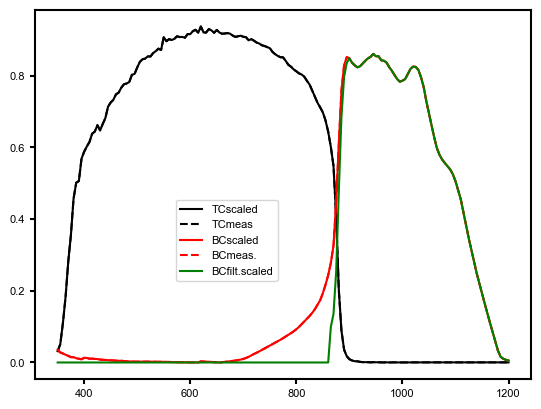

In [69]:
tc_trans = 1 - tc_eqe

tandem_eqe, bc_eqe_scaled = get_tandem_eqe(tc_eqe,tc_trans,bc_eqe,tc_iv_params,bc_iv_params)

tc_eqe_scaled = tandem_eqe["TC"]
bc_eqe_filtered_scaled = tandem_eqe["BC"]

print(f"TC from QE {intergrate_eqe(tc_eqe)}")
print(f"TC from scaled QE {intergrate_eqe(tc_eqe_scaled)}")
print(f"TC from Outdoor IV {tc_isc * 1e3}")
# print(intergrate_eqe(bc_eqe_interp))
print(f"BC from QE {intergrate_eqe(bc_eqe)}")
print(f"BC from scaled QE {intergrate_eqe(bc_eqe_scaled)}")
print(f"BC from Outdoor IV {bc_isc * 1e3}")
print(f"BC from filtered QE {intergrate_eqe(bc_eqe_filtered_scaled)}")

fig,axs = plt.subplots()
axs.plot(tc_eqe_scaled,"k-")
axs.plot(tc_eqe,"k--")
axs.plot(bc_eqe_scaled,"r-")
axs.plot(bc_eqe,"r--")
axs.plot(bc_eqe_filtered_scaled, "g-")
axs.legend(["TCscaled", "TCmeas","BCscaled", "BCmeas.","BCfilt.scaled"], loc=0, bbox_to_anchor=(0.5, 0.5))

Get the area from the scaling

In [70]:
area_tc, area_bc = get_area_isc_eqe(tc_eqe,tc_trans,bc_eqe,tc_iv_params,bc_iv_params)

area_bc = area_bc * 1.2 # scale the effective area - at higher angles it seems light might fall into masked areas rendering the bottom area and thus the cell current higher

Make a tandem

In [71]:
iiiv_si_tandem = get_tandem_device(tc_iv_params,bc_iv_params, bc_eqe, device_tc_eg_25, device_bc_eg_25, area_tc, area_bc)
iiiv_si_tandem

PskSidev3T: <pvcircuit.tandem3T.Tandem3T class>
T = 25.0 C, Rz= 0 Ω cm2, Rt= 0.0261761 Ω cm2, Rr = 0.00667208 Ω cm2

top: <pvcircuit.junction.Junction class>
Eg = 1.41 eV, TC = 25.0 C
Jext = 26.2 mA/cm2, JLC = 0.0 mA/cm2
Gsh = 6.05717e-05 S/cm2, Rser = 0.0261761 Ωcm2
lightA = 0.904795 cm2, totalA = 0.904795 cm2
pn = -1, beta = 0, gamma = 0
   n    J0ratio   J0(A/cm2) 
  db       1      1.051e-21 
 2.38    300.00   8.247e-09 

bot: <pvcircuit.junction.Junction class>
Eg = 1.12 eV, TC = 25.0 C
Jext = 10.3 mA/cm2, JLC = 0.0 mA/cm2
Gsh = 5.11923e-05 S/cm2, Rser = 0.00667208 Ωcm2
lightA = 1.48823 cm2, totalA = 1.48823 cm2
pn = 1, beta = 0, gamma = 0
   n    J0ratio   J0(A/cm2) 
  db       1      7.140e-17 
 1.32    127.46   1.382e-11 

Check error

In [72]:
# interpolate am1.5g spectra with Wiser spectra
am15g_interp_func = interp1d(am15g.index, am15g.values)

am15g_interp_head = pd.Series(am15g_interp_func(wiser_global_tilt.wavelength), index=wiser_global_tilt.wavelength)
am15g_interp_head_power = np.trapz(x=am15g_interp_head.index, y=am15g_interp_head.values)

scalers = wiser_global_spec_power_head / am15g_interp_head_power

am15g_tail = am15g[(am15g.index > max_otf_wavelength) & (am15g.index <= 1200)]
am15g_tail_scaled = pd.DataFrame(np.outer(scalers,am15g_tail), index = wiser_global_tilt_spectra_filtered.index, columns=am15g_tail.index)

spectra_corr = pd.concat([wiser_global_tilt_spectra_filtered.iloc[:,wiser_global_tilt_spectra_filtered.columns <= max_otf_wavelength], am15g_tail_scaled], axis=1)



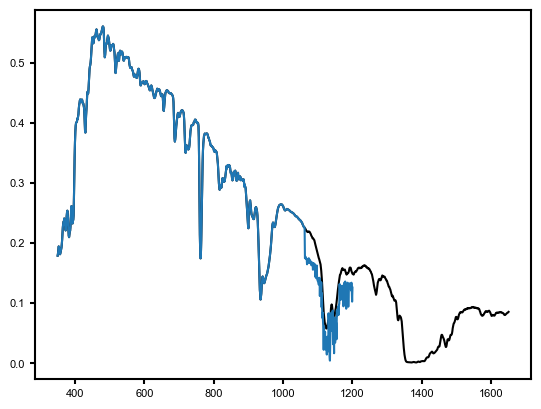

In [73]:
fig, ax = plt.subplots()
ax.plot(wiser_global_tilt_spectra_filtered.iloc[123, :], "k")
ax.plot(spectra_corr.iloc[123, :])
# ax.plot(am15g[am15g.index < 1200] * scalers[123], "r--")
# ax.plot(bc_eqe_filtered_scaled)
# lines = ax.plot(spectra_corr.iloc[::5000,:].T, c=(0.1,0.1,0.1,0.1))


In [74]:
bc_currents_wiser = get_currents(wiser_global_tilt_spectra_filtered, bc_eqe_filtered_scaled)
bc_currents_am15gcorr = get_currents(spectra_corr, bc_eqe_filtered_scaled)


RMSE = 0.22  mAcm^-2


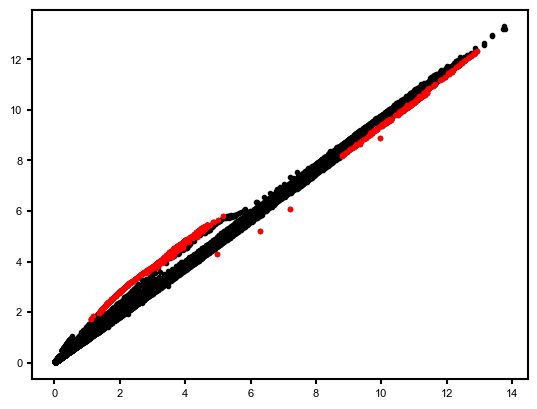

In [75]:
se = (bc_currents_wiser - bc_currents_am15gcorr.values)**2
mse = se.mean()
rmse = np.sqrt(mse)
se_sort_idx = se.argsort()

fig, ax = plt.subplots()
ax.plot(bc_currents_wiser, bc_currents_am15gcorr, ".k")
ax.plot(bc_currents_wiser.iloc[se_sort_idx[-500:]], bc_currents_am15gcorr.iloc[se_sort_idx[-500:]], ".r")
print(f"RMSE = {rmse:.2f}  mAcm^-2")

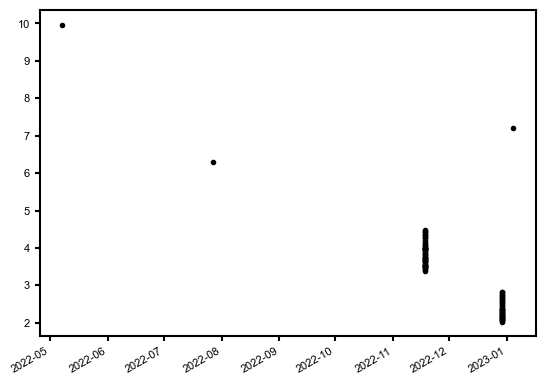

In [76]:
fig, ax = plt.subplots()
ax.plot(bc_currents_wiser.iloc[se_sort_idx[-100:]], ".k")
fig.autofmt_xdate()

Determine average photon energy (APE) and Filter irrelevant energies


In [77]:
meteo_spectra_corr.calc_ape()

data_filter = (
    (meteo_spectra_corr.average_photon_energy > 0)
    & (meteo_spectra_corr.average_photon_energy < 4)
    & ((meteo_spectra_corr.spectra > 1e-3).all(axis=1))
    & ((meteo_spectra_corr.spectra > 1e-3).all(axis=1))
    # & ((meteo_spectra_corr.SpecPower.index >= pd.Timestamp(2020,1,1)))
    # & ((meteo_spectra_corr.SpecPower.index < pd.Timestamp(2020,3,1)))
    # & (np.abs(meteo_spectra_aligned.SpecPower - MR281_top_aligned['irrad_mean']) /np.sqrt(2) < 50)
).values

MR281_top_filtered = MR281_top_aligned.iloc[data_filter,:]
MR281_bottom_filtered = MR281_bottom_aligned.iloc[data_filter,:]

meteo_spectra_filtered = meteo_spectra_corr.filter_custom(data_filter)


Show difference between Irradiance from sensor and from integrated Spectra

Integrate currrents from spectra and EQE

In [78]:
currents = pd.DataFrame(
    np.zeros([meteo_spectra_filtered.spectra.shape[0],2]),
    index=meteo_spectra_filtered.spectra.index,
    columns=["Jsctop", "Jscbot"]
)

currents["Jsctop"]= get_currents(meteo_spectra_filtered.spectra,tc_eqe_scaled)
currents["Jscbot"] = get_currents(meteo_spectra_filtered.spectra,bc_eqe_filtered_scaled)

(0.0, 35.25420114667261)

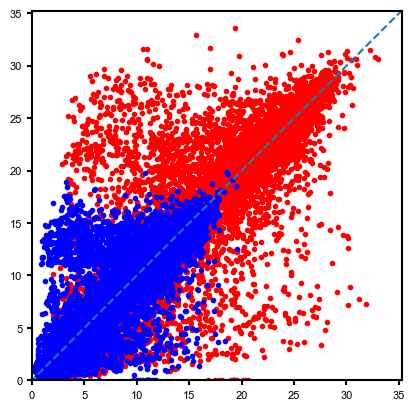

In [79]:
fig, ax = plt.subplots()
Amps2miliAmps = 1e3
ax.plot(currents["Jsctop"] * area_tc, MR281_top_filtered["isc"] * Amps2miliAmps, "r.")
ax.plot(currents["Jscbot"] * area_bc, MR281_bottom_filtered["isc"] * Amps2miliAmps, "b.")

ax.set_aspect(1)
ax_lims = ax.get_ylim()
ax.plot(ax_lims, ax_lims, "--")

ax.set_xlim(0, ax_lims[1])
ax.set_ylim(0, ax_lims[1])


In [80]:
meteo_data_filtered = meteo_data_aligned[data_filter]



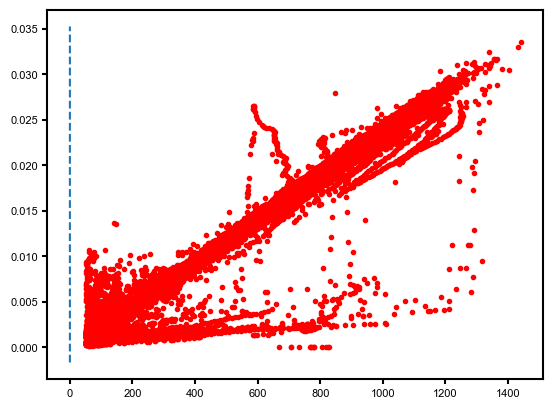

In [81]:
fig, ax = plt.subplots()
ax.plot(MR281_top_filtered["irrad_mean"], MR281_top_filtered["isc"], "r.")

# ax.axis('square')

ax_lims = ax.get_ylim()
ax.plot(ax_lims, ax_lims, "--")

# ax.set_xlim(0, ax_lims[1])
# ax.set_ylim(0, ax_lims[1])




In [82]:
spectra_scalor = MR281_top_filtered["irrad_mean"]/meteo_spectra_filtered.SpecPower

In [83]:
spectra_scaled = meteo_spectra_filtered.spectra.mul(spectra_scalor,axis = 0)

In [84]:
np.sum(np.abs(np.trapz(spectra_scaled, meteo_spectra_filtered.wavelength) - MR281_top_filtered["irrad_mean"]))

2.6804997332874336e-08

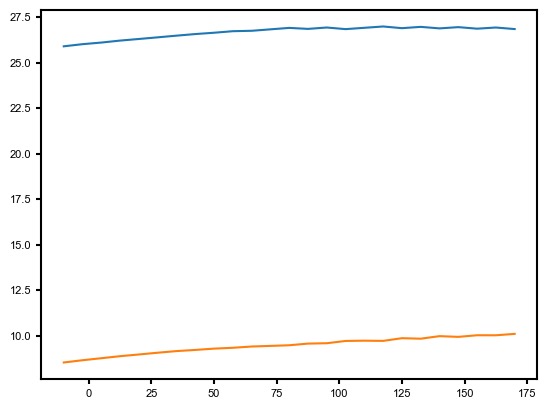

In [85]:
# spectra = wiser_global_horizontal.spectra.loc[date_plot]
spectra_T = meteo_spectra_filtered.spectra.T
spectra_T = spectra_scaled.T

spectra_T.index = meteo_spectra_filtered.wavelength


# interpolate eqe or spectra depending on which has smallest dlambda
if np.mean(np.diff(spectra_T.index)) < np.mean(np.diff(tc_eqe_scaled.index)):
    # interpolate spectra for EQE.
    fint = interp1d(spectra_T.index, spectra_T, axis=0, bounds_error=False, fill_value=0)
    spectra_T_interp = pd.DataFrame(fint(tc_eqe_scaled.index), index=tc_eqe_scaled.index, columns=spectra_T.columns)
    tc_eqe_interp = tc_eqe_scaled
    bc_eqe_interp = bc_eqe_scaled
    bc_eqe_filtered_interp = bc_eqe_filtered_scaled

else:
    # interpolate EQE for spectra.
    fint = interp1d(tc_eqe_scaled.index, tc_eqe_scaled, axis=0, bounds_error=False, fill_value=0)
    tc_eqe_interp = pd.Series(fint(spectra_T.index), index=spectra_T.index)
    fint = interp1d(bc_eqe_scaled.index, bc_eqe_scaled, axis=0, bounds_error=False, fill_value=0)
    bc_eqe_interp = pd.Series(fint(spectra_T.index), index=spectra_T.index)
    fint = interp1d(bc_eqe_filtered_scaled.index, bc_eqe_filtered_scaled, axis=0, bounds_error=False, fill_value=0)
    bc_eqe_filtered_interp = pd.Series(fint(spectra_T.index), index=spectra_T.index)
    spectra_T_interp = spectra_T

spectra_T_interp.iloc[:,1:] = np.tile(spectra_T_interp.iloc[:,0].values.reshape(-1,1),(1,spectra_T_interp.iloc[:,1:].shape[1]))
spectra_interp = spectra_T_interp.T

Ts = np.linspace(-10,170,25)
eg_tc, sigma_tc = calc_Eg_Rau(tc_eqe_interp)
# egs_tc = GaAs_eg_shift(MR281_top_filtered["temp_module_mean"], eg_tc)
# sigmas_tc = GaAs_sigma_shift(MR281_top_filtered["temp_module_mean"], sigma_tc)
egs_tc = GaAs_eg_shift(Ts, eg_tc)
sigmas_tc = GaAs_sigma_shift(Ts, sigma_tc)

eg_bc, sigma_bc = calc_Eg_Rau(bc_eqe_filtered_interp)
# egs_bc = Si_eg_shift(MR281_bottom_filtered["temp_module_mean"], eg_bc)
# sigmas_bc = GaAs_sigma_shift(MR281_bottom_filtered["temp_module_mean"], sigma_bc)
egs_bc = Si_eg_shift(Ts, eg_bc)
sigmas_bc = GaAs_sigma_shift(Ts, sigma_bc)


tc_jscs, bc_jscs = shift_eqe_tcbc(
    tc_eqe_interp,
    eg_tc,
    sigma_tc,
    [egs_tc],
    [sigmas_tc],
    bc_eqe_filtered_interp,
    eg_bc,
    sigma_bc,
    [egs_bc],
    [sigmas_bc],
    spectra_T_interp.iloc[:,:len(Ts)],
)
# tc_jscs = shift_eqe(tc_eqe_interp, eg_tc, sigma_tc, [egs_tc], [sigmas_tc], spectra_T_interp)
# bc_jscs = shift_eqe(bc_eqe_filtered_interp, eg_bc, sigma_bc, [egs_bc], [sigmas_bc], spectra_T_interp)
fig,ax = plt.subplots()
ax.plot(Ts, tc_jscs)
ax.plot(Ts, bc_jscs)

In [86]:
# spectra = wiser_global_horizontal.spectra.loc[date_plot]
spectra_T = meteo_spectra_filtered.spectra.T
spectra_T.index = meteo_spectra_filtered.wavelength

# interpolate eqe or spectra depending on which has smallest dlambda
if np.mean(np.diff(spectra_T.index)) < np.mean(np.diff(tc_eqe_scaled.index)):
    # interpolate spectra for EQE.
    fint = interp1d(spectra_T.index, spectra_T, axis=0, bounds_error=False, fill_value=0)
    spectra_T_interp = pd.DataFrame(fint(tc_eqe_scaled.index), index=tc_eqe_scaled.index, columns=spectra_T.columns)
    tc_eqe_interp = tc_eqe_scaled
    bc_eqe_interp = bc_eqe_scaled
    bc_eqe_filtered_interp = bc_eqe_filtered_scaled

else:
    # interpolate EQE for spectra.
    fint = interp1d(tc_eqe_scaled.index, tc_eqe_scaled, axis=0, bounds_error=False, fill_value=0)
    tc_eqe_interp = pd.Series(fint(spectra_T.index), index=spectra_T.index)
    fint = interp1d(bc_eqe_scaled.index, bc_eqe_scaled, axis=0, bounds_error=False, fill_value=0)
    bc_eqe_interp = pd.Series(fint(spectra_T.index), index=spectra_T.index)
    fint = interp1d(bc_eqe_filtered_scaled.index, bc_eqe_filtered_scaled, axis=0, bounds_error=False, fill_value=0)
    bc_eqe_filtered_interp = pd.Series(fint(spectra_T.index), index=spectra_T.index)
    spectra_T_interp = spectra_T

spectra_interp = spectra_T_interp.T

eg_tc, sigma_tc = calc_Eg_Rau(tc_eqe_interp)
# egs_tc = GaAs_eg_shift(MR281_top_filtered["temp_module_mean"], eg_tc)
# sigmas_tc = GaAs_sigma_shift(MR281_top_filtered["temp_module_mean"], sigma_tc)
egs_tc = GaAs_eg_shift(MR281_top_filtered["temp_module_mean"] + MR281_top_filtered["irrad_mean"] / E0 * deltaT, eg_tc)
sigmas_tc = GaAs_sigma_shift(MR281_top_filtered["temp_module_mean"] + MR281_top_filtered["irrad_mean"] / E0 * deltaT, sigma_tc)

eg_bc, sigma_bc = calc_Eg_Rau(bc_eqe_filtered_interp)
# egs_bc = Si_eg_shift(MR281_bottom_filtered["temp_module_mean"], eg_bc)
# sigmas_bc = GaAs_sigma_shift(MR281_bottom_filtered["temp_module_mean"], sigma_bc)
egs_bc = Si_eg_shift(MR281_bottom_filtered["temp_module_mean"] + MR281_bottom_filtered["irrad_mean"] / E0 * deltaT, eg_bc)
sigmas_bc = GaAs_sigma_shift(MR281_bottom_filtered["temp_module_mean"] + MR281_bottom_filtered["irrad_mean"] / E0 * deltaT, sigma_bc)


tc_jscs, bc_jscs = shift_eqe_tcbc(tc_eqe_interp, eg_tc, sigma_tc, [egs_tc], [sigmas_tc], bc_eqe_filtered_interp, eg_bc, sigma_bc, [egs_bc], [sigmas_bc], spectra_T_interp)
# tc_jscs = shift_eqe(tc_eqe_interp, eg_tc, sigma_tc, [egs_tc], [sigmas_tc], spectra_T_interp)
# bc_jscs = shift_eqe(bc_eqe_filtered_interp, eg_bc, sigma_bc, [egs_bc], [sigmas_bc], spectra_T_interp)


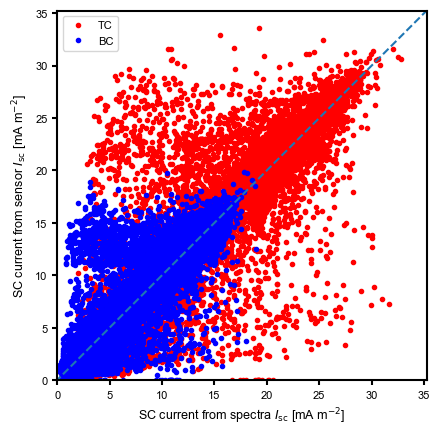

In [87]:
fig, ax = plt.subplots()
Amps2miliAmps = 1e3
ax.plot(tc_jscs * area_tc, MR281_top_filtered['isc'] * Amps2miliAmps,"r.")
ax.plot(bc_jscs * area_bc,MR281_bottom_filtered['isc'] * Amps2miliAmps,"b.")

ax.set_aspect(1)
lims = ax.get_ylim()
ax.plot(lims,lims,"--")

ax.set_xlim(0,lims[1])
ax.set_ylim(0,lims[1])

ax.set_xlabel(r"SC current from spectra $I_\mathrm{sc}$ [mA m$^{-2}$]")
ax.set_ylabel(r"SC current from sensor $I_\mathrm{sc}$ [mA m$^{-2}$]")
ax.legend(['TC','BC'])

Text(0.5, 0, 'Current difference $I_\\mathrm{sc, meas}$ - $I_\\mathrm{sc, mod}$ [mA m$^{-2}$]')

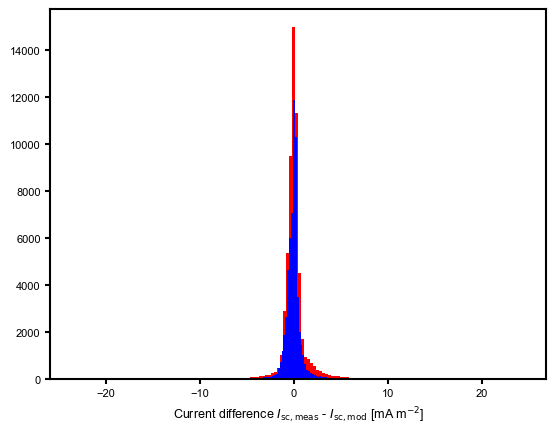

In [88]:
fig, ax = plt.subplots()
h1 = ax.hist(tc_jscs * area_tc - MR281_top_filtered['isc'] * Amps2miliAmps,150, color = "r")
h2 = ax.hist(bc_jscs * area_bc - MR281_bottom_filtered['isc'] * Amps2miliAmps,150, color = "b")


ax.set_xlabel(r"Current difference $I_\mathrm{sc, meas}$ - $I_\mathrm{sc, mod}$ [mA m$^{-2}$]")

Remodel the power output

In [89]:
# spectra = wiser_global_horizontal.spectra.loc[date_plot]
spectra_T = meteo_spectra_filtered.spectra.T
spectra_T.index = meteo_spectra_filtered.wavelength

# interpolate eqe or spectra depending on which has smallest dlambda
if np.mean(np.diff(spectra_T.index)) < np.mean(np.diff(tc_eqe_scaled.index)):
    # interpolate spectra for EQE.
    fint = interp1d(spectra_T.index, spectra_T, axis=0, bounds_error=False, fill_value=0)
    spectra_T_interp = pd.DataFrame(fint(tc_eqe_scaled.index), index=tc_eqe_scaled.index, columns=spectra_T.columns)
    tc_eqe_interp = tc_eqe_scaled
    bc_eqe_interp = bc_eqe_scaled
    bc_eqe_filtered_interp = bc_eqe_filtered_scaled

else:
    # interpolate EQE for spectra.
    fint = interp1d(tc_eqe_scaled.index, tc_eqe_scaled, axis=0, bounds_error=False, fill_value=0)
    tc_eqe_interp = pd.Series(fint(spectra_T.index), index=spectra_T.index)
    fint = interp1d(bc_eqe_scaled.index, bc_eqe_scaled, axis=0, bounds_error=False, fill_value=0)
    bc_eqe_interp = pd.Series(fint(spectra_T.index), index=spectra_T.index)
    fint = interp1d(bc_eqe_filtered_scaled.index, bc_eqe_filtered_scaled, axis=0, bounds_error=False, fill_value=0)
    bc_eqe_filtered_interp = pd.Series(fint(spectra_T.index), index=spectra_T.index)
    spectra_T_interp = spectra_T

spectra_interp = spectra_T_interp.T

eg_tc, sigma_tc = calc_Eg_Rau(tc_eqe_interp)
# egs_tc = GaAs_eg_shift(MR281_top_filtered["temp_module_mean"], eg_tc)
# sigmas_tc = GaAs_sigma_shift(MR281_top_filtered["temp_module_mean"], sigma_tc)
egs_tc = GaAs_eg_shift(MR281_top_filtered["temp_module_mean"] + MR281_top_filtered["irrad_mean"] / E0 * deltaT, eg_tc)
sigmas_tc = GaAs_sigma_shift(MR281_top_filtered["temp_module_mean"] + MR281_top_filtered["irrad_mean"] / E0 * deltaT, sigma_tc)

eg_bc, sigma_bc = calc_Eg_Rau(bc_eqe_filtered_interp)
# egs_bc = Si_eg_shift(MR281_bottom_filtered["temp_module_mean"], eg_bc)
# sigmas_bc = GaAs_sigma_shift(MR281_bottom_filtered["temp_module_mean"], sigma_bc)
egs_bc = Si_eg_shift(MR281_bottom_filtered["temp_module_mean"] + MR281_bottom_filtered["irrad_mean"] / E0 * deltaT, eg_bc)
sigmas_bc = Si_sigma_shift(MR281_bottom_filtered["temp_module_mean"] + MR281_bottom_filtered["irrad_mean"] / E0 * deltaT, sigma_bc)


tc_jscs, bc_jscs = shift_eqe_tcbc(tc_eqe_interp, eg_tc, sigma_tc, [egs_tc], [sigmas_tc], bc_eqe_filtered_interp, eg_bc, sigma_bc, [egs_bc], [sigmas_bc], spectra_T_interp)


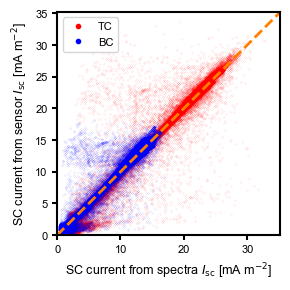

In [90]:
fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = fig_onecol)
Amps2miliAmps = 1e3
ax.plot(tc_jscs * area_tc, MR281_top_filtered['isc'] * Amps2miliAmps, ".", ms=0.1, mfc=(1,0,0,1), mec=(1,0,0,1))
ax.plot(bc_jscs * area_bc,MR281_bottom_filtered['isc'] * Amps2miliAmps,".", ms=0.1, mfc=(0,0,1,1), mec=(0,0,1,1))

ax.set_aspect(1)
lims = ax.get_ylim()
ax.plot(lims,lims,"--",c=(1,0.5,0), lw=2)

ax.set_xlim(0,lims[1])
ax.set_ylim(0,lims[1])

ax.set_xlabel(r"SC current from spectra $I_\mathrm{sc}$ [mA m$^{-2}$]")
ax.set_ylabel(r"SC current from sensor $I_\mathrm{sc}$ [mA m$^{-2}$]")
leg = ax.legend(['TC','BC'])

for leg_handle in leg.legendHandles:
    leg_handle.set_markersize(6)


# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\isc.pgf", format='pgf', backend='pgf')
# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\isc.pdf", format='pdf', bbox_inches = "tight")
fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\isc.png", format='png', bbox_inches = "tight")

simulate output with current and temperature

In [91]:
# dev3T = get_tandem_device(tc_iv_params, bc_iv_params, bc_eqe_filtered_interp, eg_tc, eg_bc, area_tc, area_bc)
# power2T = []
# power4T = []
# for i in trange(len(tc_jscs)):
#     dev3T.top.set(Jext=MR281_top_filtered['isc'][i], TC=MR281_top_filtered["temp_module_mean"][i] + MR281_top_filtered["irrad_mean"][i]  * 0/ E0 * deltaT, Eg=egs_tc[i])
#     dev3T.bot.set(Jext=MR281_bottom_filtered['isc'][i], TC=MR281_bottom_filtered["temp_module_mean"][i] + MR281_bottom_filtered["irrad_mean"][i] * 0 / E0 * deltaT, Eg=egs_bc[i])

#     _, iv3t = dev3T.CM()
#     power2T.append(iv3t.Ptot[0])
#     iv3t = dev3T.MPP()
#     power4T.append(iv3t.Ptot[0])

# power_data_wisc = pd.DataFrame({"power2T":power2T, "power4T":power4T})

# with open("power_data_wisc.p","wb") as fout:
#     pickle.dump(power_data_wisc,fout)

In [92]:
with open(r"ey_data/power_data_wisc.p","rb") as fin:
    power_data_wisc = pickle.load(fin)

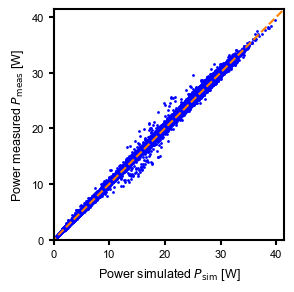

In [93]:
fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = fig_onecol)
ax.plot(power_data_wisc["power4T"]*1e3,(MR281_top_filtered['pmp'] + MR281_bottom_filtered['pmp'])*1e3, ".", ms=2, mfc=(0,0,1,1), mec=(0,0,1,1))
ax.set_aspect(1)
max_ax = ax.get_ylim()
ax.plot(max_ax,max_ax,"--", c=(1,0.5,0))

ax.set_xlim(0,max_ax[1])
ax.set_ylim(0,max_ax[1])

ax.set_xlabel(r"Power simulated $P_\mathrm{sim}$ [W]")
ax.set_ylabel(r"Power measured $P_\mathrm{meas}$ [W]")
ax.locator_params(axis='both', nbins=5)
fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\pvsp_isc.png", format='png', dpi=600, bbox_inches = "tight")

In [94]:
np.corrcoef(power_data_wisc["power4T"]*1e3,(MR281_top_filtered['pmp'] + MR281_bottom_filtered['pmp'])*1e3)

array([[1.        , 0.99934516],
       [0.99934516, 1.        ]])

Simulate output with irradiance and temperaure

Simulate ouput with spectra and temperaure only

In [95]:

# dev3T = get_tandem_device(tc_iv_params, bc_iv_params, bc_eqe_filtered_interp, eg_tc, eg_bc, area_tc, area_bc)
# power2T = []
# power4T = []
# for i in trange(len(tc_jscs)):
#     dev3T.top.set(Jext=np.round(tc_jscs[i] * area_tc, 3) / 1e3, TC=MR281_top_filtered["temp_module_mean"][i] + MR281_top_filtered["irrad_mean"][i] * 0/ E0 * deltaT, Eg=egs_tc[i])
#     dev3T.bot.set(Jext=np.round(bc_jscs[i] * area_bc, 3) / 1e3, TC=MR281_bottom_filtered["temp_module_mean"][i] + MR281_bottom_filtered["irrad_mean"][i] *0 / E0 * deltaT, Eg=egs_bc[i])

#     _, iv3t = dev3T.CM()
#     power2T.append(iv3t.Ptot[0])
#     iv3t = dev3T.MPP()
#     power4T.append(iv3t.Ptot[0])


# power_data = pd.DataFrame({"power2T":power2T, "power4T":power4T})

# with open("power_data.p","wb") as fout:
#     pickle.dump(power_data,fout)

In [96]:
with open(r"ey_data/power_data.p","rb") as fin:
    power_data = pickle.load(fin)


Text(0, 0.5, 'Power measured $P_\\mathrm{meas}$ [mW]')

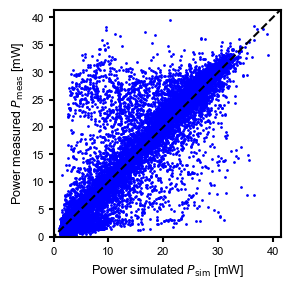

In [97]:
fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = fig_onecol)
ax.plot(power_data["power4T"] * 1e3, (MR281_top_filtered['pmp'] + MR281_bottom_filtered['pmp'])*1e3, ".", ms=2, mfc=(0,0,1,1), mec=(0,0,1,1))
ax.set_aspect(1)
lims = ax.get_ylim()
ax.plot(lims,lims,"k--")

ax.set_xlim(0,lims[1])
ax.set_ylim(0,lims[1])

ax.set_xlabel(r"Power simulated $P_\mathrm{sim}$ [mW]")
ax.set_ylabel(r"Power measured $P_\mathrm{meas}$ [mW]")

In [98]:
data = np.linspace(1,100,10000)
np.random.shuffle(data)
b=data + np.random.randn(10000)*10
# plt.plot(data,b,'.')
np.corrcoef(data,b)


array([[1.        , 0.94128263],
       [0.94128263, 1.        ]])

In [99]:
np.corrcoef(power_data["power4T"] * 1e3, (MR281_top_filtered['pmp'] + MR281_bottom_filtered['pmp'])*1e3)

array([[1.        , 0.96973067],
       [0.96973067, 1.        ]])

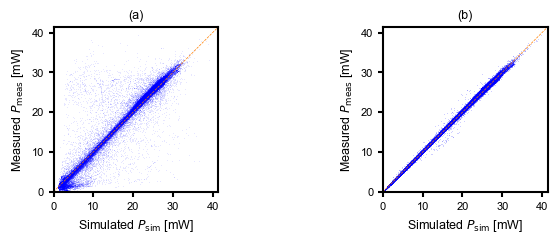

In [123]:
fig,ax = plt.subplots(1,2, constrained_layout=False, figsize = fig_onecol)

ax[0].plot(power_data["power4T"]*1e3,(MR281_top_filtered['pmp'] + MR281_bottom_filtered['pmp'])*1e3, ".", ms=1, mfc=(0,0,1,0.25), mec=(0,0,0,0))
ax[0].set_aspect(1)
max_ax = ax[0].get_ylim()
ax[0].plot(max_ax,max_ax,"--", c=(1,0.5,0), lw=0.5)

ax[0].set_xlim(0,max_ax[1])
ax[0].set_ylim(0,max_ax[1])

ax[0].set_xlabel(r"Simulated $P_\mathrm{sim}$ [mW]")
ax[0].set_ylabel(r"Measured $P_\mathrm{meas}$ [mW]")

ax[1].plot(power_data_wisc["power4T"] * 1e3, (MR281_top_filtered['pmp'] + MR281_bottom_filtered['pmp'])*1e3, ".", ms=1, mfc=(0,0,1,0.5), mec=(0,0,0,0))
ax[1].set_aspect(1)
lims = ax[1].get_ylim()
ax[1].plot(lims,lims,"--",c=(1,0.5,0), lw=0.5)

ax[1].set_xlim(0,lims[1])
ax[1].set_ylim(0,lims[1])

ax[1].set_xlabel(r"Simulated $P_\mathrm{sim}$ [mW]")
ax[1].set_ylabel(r"Measured $P_\mathrm{meas}$ [mW]")

ax[0].set_title("(a)", loc='center')
ax[1].set_title("(b)", loc='center')

ax[0].locator_params(axis='both', nbins=5)
ax[1].locator_params(axis='both', nbins=5)

fig.subplots_adjust(wspace=1) # For one col version
# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\pvsp.pgf", format='pgf', backend='pgf')
# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\pvsp.pdf", format='pdf', bbox_inches = "tight")
# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\pvsp.png", format='png', bbox_inches = "tight")
fig.savefig(fr'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Submission_1\figures\pvsp.{"pdf"}', format='pdf', bbox_inches = "tight")
fig.savefig(fr'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Submission_1\figures\pvsp.{"png"}', format='png', bbox_inches = "tight", dpi = 300)


Save data for later plotting

In [125]:
power_data_wisc.to_pickle(fr'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\data\power_data_wisc.pkl')
power_data.to_pickle(fr'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\data\power_data.pkl')
MR281_top_filtered.to_pickle(fr'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\data\MR281_top_filtered.pkl')
MR281_bottom_filtered.to_pickle(fr'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\data\MR281_bottom_filtered.pkl')

Text(0.5, 1.0, '(b)')

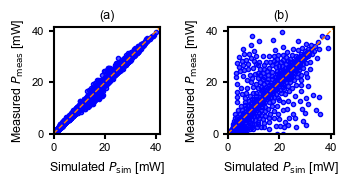

In [101]:
from sklearn.cluster import KMeans

data = pd.concat([power_data["power4T"].reset_index(drop=True) * 1e3, (MR281_top_filtered['pmp'].reset_index(drop=True) + MR281_bottom_filtered['pmp'].reset_index(drop=True))*1e3],axis=1).values
# Specify the number of clusters (means) you want to find
num_clusters = len(data) // 100

# Create a KMeans object with the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters)

# Fit the data to the KMeans model and obtain cluster labels
cluster_labels = kmeans.fit_predict(data)

# Get the coordinates of the cluster centers
cluster_centers = kmeans.cluster_centers_

fig,ax = plt.subplots(1,2, constrained_layout=True, figsize = fig_twocol)

ax[0].plot(power_data_wisc["power4T"]*1e3,(MR281_top_filtered['pmp'][:len(tc_jscs)] + MR281_bottom_filtered['pmp'][:len(tc_jscs)])*1e3, ".", mfc=(0,0,1,0.66), mec=(0,0,1,1))
ax[0].set_aspect(1)
max_ax = ax[0].get_ylim()
ax[0].plot(max_ax,max_ax,"--", c=(1,0.5,0), lw=1)

ax[0].set_xlim(0,max_ax[1])
ax[0].set_ylim(0,max_ax[1])

ax[0].set_xlabel(r"Simulated $P_\mathrm{sim}$ [mW]")
ax[0].set_ylabel(r"Measured $P_\mathrm{meas}$ [mW]")

ax[1].plot(cluster_centers[:,0],cluster_centers[:,1], ".", mfc=(0,0,1,0.66), mec=(0,0,1,1))
ax[1].set_aspect(1)
lims = ax[1].get_ylim()
ax[1].plot(lims,lims,"--",c=(1,0.5,0), lw=1)

ax[1].set_xlim(0,lims[1])
ax[1].set_ylim(0,lims[1])

ax[1].set_xlabel(r"Simulated $P_\mathrm{sim}$ [mW]")
ax[1].set_ylabel(r"Measured $P_\mathrm{meas}$ [mW]")

ax[0].set_title("(a)", loc='center')
ax[1].set_title("(b)", loc='center')

# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\pvsp.pgf", format='pgf', backend='pgf')
# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\pvsp.pdf", format='pdf', bbox_inches = "tight")
# fig.savefig(r"C:\Users\rwitteck\OneDrive - NREL\Publications\2023\Outdoor tandem module\figures\pvsp.pdf", format='pdf', bbox_inches = "tight")
# fig.savefig(fr'C:\Users\rwitteck\OneDrive - NREL\Publications\2023\EHE-paper\Tex\figures\pvsp.{"pdf"}', format='pdf', bbox_inches = "tight")


In [102]:
def filter_times(ts, min2filt,diff_min2filt):
    # filter values with a time difference of +-2min
    time_filter = (ts.index.minute.values % min2filt <= diff_min2filt) | (np.abs(ts.index.minute.values % min2filt - min2filt) <= diff_min2filt)
    ts_mask = ts[time_filter]

    # round all times to 10 min
    ts_mask = ts_mask.set_index(ts_mask.index.round(pd.Timedelta(minutes=min2filt)))

    # calc mean for these values
    # return(ts_mask.resample(pd.Timedelta(minutes=min2filt)).mean())
    return ts_mask.groupby(ts_mask.index.round(pd.Timedelta(minutes=min2filt))).mean()

In [103]:
date_start = MR281_top_filtered['pmp'].index[0]
date_end = MR281_top_filtered['pmp'].index[-1]
clouds = CloudCover.get_asi(date_start, date_end)

NameError: name 'CloudCover' is not defined

In [ ]:
power_meas_clouds = pd.DataFrame(power_data["power4T"].values * 1e3,index=MR281_top_filtered['pmp'].index)
# power_meas_clouds = power_meas_clouds.resample("10T").bfill()
power_meas_clouds = filter_times(power_meas_clouds.shift(freq='-1T'),10,0)


power_sim_clouds = pd.DataFrame((MR281_top_filtered['pmp'] + MR281_bottom_filtered['pmp'])*1e3)
# power_sim_clouds = power_sim_clouds.resample("10T").bfill()
power_sim_clouds = filter_times(power_sim_clouds.shift(freq='-1T'),10,0)

In [ ]:
cloud_data = clouds.data[~clouds.data.index.duplicated()]

cloud_data, power_meas_clouds = sync(cloud_data, power_meas_clouds)
cloud_data, power_sim_clouds = sync(cloud_data, power_sim_clouds)

Text(0, 0.5, 'Measured $P_\\mathrm{meas}$ [mW]')

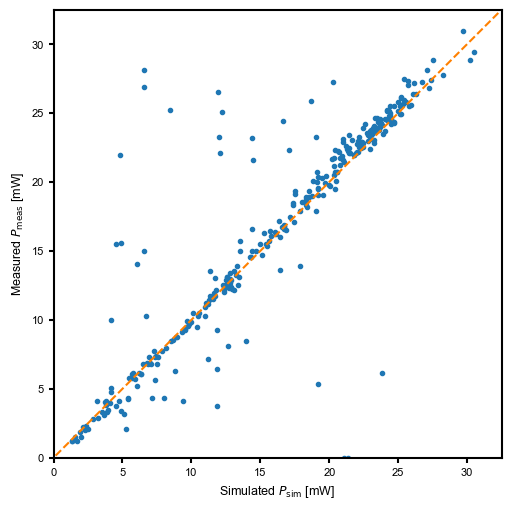

In [ ]:
fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (5,5))

# ax.scatter(power_meas_clouds, power_sim_clouds, 10, cloud_data["Sun Flag"], cmap='plasma')
# cloud_filter = cloud_data["CDOC Total Cloud Cover [%]"]<50
cloud_filter = cloud_data["Sun Flag"] == 1
ax.plot(power_meas_clouds[cloud_filter], power_sim_clouds[cloud_filter],".")
ax.set_aspect(1)
max_ax = ax.get_ylim()
ax.plot(max_ax,max_ax,"--", c=(1,0.5,0))

ax.set_xlim(0,max_ax[1])
ax.set_ylim(0,max_ax[1])
ax.set_xlabel(r"Simulated $P_\mathrm{sim}$ [mW]")
ax.set_ylabel(r"Measured $P_\mathrm{meas}$ [mW]")

Compare pvlib AOI with this AOI

AttributeError: 'numpy.ndarray' object has no attribute 'index'

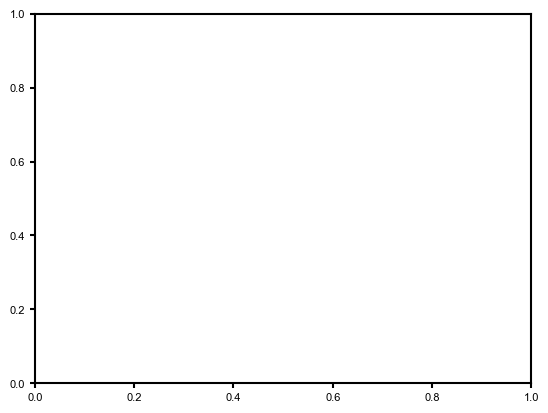

In [ ]:
location = pvloc.Location(39.7555, -105.2211, tz="America/Denver", altitude=1828.8)
# location = pvloc.Location(39.742, -105.18, tz="America/Denver", altitude=1828.8)
tilt = 40
azimuth = 180
loc_times = MR281_top_filtered.index.tz_localize(location.tz)

solpos = solarposition.get_solarposition(
    loc_times, latitude=location.latitude, longitude=location.longitude, altitude=location.altitude, method="nrel_numpy"
)
aoi = irradiance.aoi(tilt, azimuth, solpos.apparent_zenith, solpos.azimuth)

fig, ax = plt.subplots()
ax.plot(data.index.hour + data.index.minute / 60, data['aoi'], ".")
# ax.plot(data.index, data['aoi'], ".")
# ax.plot(MR281_top_filtered.index.hour + MR281_top_filtered.index.minute / 60, MR281_top_filtered["aoi"], ".")
# ax.plot(MR281_bottom_filtered.index.hour + MR281_bottom_filtered.index.minute / 60, MR281_bottom_filtered["aoi"], ".")
# ax.plot(MR281_top_filtered["aoi"],MR281_top_filtered["isc"] / MR281_top_filtered["irrad_mean"], ".")
# ax.plot(MR281_bottom_filtered["aoi"],MR281_bottom_filtered["irrad_mean"], ".")

In [ ]:
am_filter = ((MR281_top_filtered["irrad_mean"] > 998)
    & (MR281_top_filtered["irrad_mean"] < 1001)
    & (MR281_top_filtered["temp_module_mean"] > 24.5)
    & (MR281_top_filtered["temp_module_mean"] < 25.5)
    & (MR281_top_filtered["aoi"] < 15))

spectra_T_interp_filtered = spectra_interp[am_filter.values].T

plt.plot(spectra_T_interp_filtered)
plt.plot(spectra_T_interp_filtered.mean(axis=1), 'r-', lw=6)

In [ ]:
tc_voc_fit = []
tc_isc_fit = []
tc_pmpp_fit = []

bc_voc_fit = []
bc_isc_fit = []
bc_pmpp_fit = []

tc_sj.set(totalarea=1)
bc_sj.set(totalarea=1)

am15g_array = pd.DataFrame(np.tile(am15g.loc[tc_eqe_interp.index].values,(len(t_range),1)), columns=am15g.loc[tc_eqe_interp.index].index)
# am15g_array = pd.DataFrame(np.tile(spectra_T_interp_filtered.mean(axis=1).loc[tc_eqe_interp.index].values,(len(t_range),1)), columns=spectra_T_interp_filtered.mean(axis=1).loc[tc_eqe_interp.index].index)

eg_tc, sigma_tc = calc_Eg_Rau(tc_eqe_interp)
egs_tc = GaAs_eg_shift(t_range, eg_tc)
sigmas_tc = GaAs_sigma_shift(t_range, sigma_tc)

eg_bc, sigma_bc = calc_Eg_Rau(bc_eqe_filtered_interp)
egs_bc = Si_eg_shift(t_range, eg_bc)
sigmas_bc = Si_sigma_shift(t_range, sigma_bc)
tc_jscs, bc_jscs = shift_eqe_tcbc(tc_eqe_interp, eg_tc, sigma_tc, [egs_tc], [sigmas_tc], bc_eqe_filtered_interp, eg_bc, sigma_bc, [egs_bc], [sigmas_bc], am15g_array.T)

# tc_jscs = shift_eqe(tc_eqe_interp, eg_tc, sigma_tc, [egs_tc], [sigmas_tc], am15g_array.T)
# bc_jscs = shift_eqe(bc_eqe_filtered_interp, eg_bc, sigma_bc, [egs_bc], [sigmas_bc], am15g_array.T)

t_range = np.insert(t_range,0,25) if not t_range[0] == 25 else t_range
col_names = ['tc_voc_fit', 'tc_isc_fit', 'tc_pmp_fit', 'bc_voc_fit', 'bc_isc_fit', 'bc_pmp_fit']
tk_data = pd.DataFrame(np.zeros((len(t_range),len(col_names))),index = t_range, columns = col_names)
for i,t in enumerate(t_range):
    tc_eg_t = GaAs_eg_shift(t, eg_tc)
    bc_eg_t = Si_eg_shift(t, eg_bc)
    assert np.isclose(tc_eg_t,egs_tc[i])
    assert np.isclose(bc_eg_t,egs_bc[i])

    tc_sj.set(Eg=tc_eg_t, TC=t, Jext=tc_jscs[i] * area_tc/ 1e3)
    bc_sj.set(Eg=bc_eg_t, TC=t, Jext=bc_jscs[i] * area_bc/ 1e3)
    tk_data.loc[t,'tc_voc_fit'] = tc_sj.MPP()["Voc"]
    tk_data.loc[t,'tc_isc_fit'] = tc_sj.MPP()["Isc"]
    tk_data.loc[t,'tc_pmp_fit'] = tc_sj.MPP()["Pmp"]
    tk_data.loc[t,'bc_voc_fit'] = bc_sj.MPP()["Voc"]
    tk_data.loc[t,'bc_isc_fit'] = bc_sj.MPP()["Isc"]
    tk_data.loc[t,'bc_pmp_fit'] = bc_sj.MPP()["Pmp"]

In [ ]:
tk_coeff = pd.DataFrame(np.polyfit(tk_data.index, tk_data.values, 1) / tk_data.loc[25, :].values * 100, columns=tk_data.columns)

In [ ]:
# fig, ax = plt.subplots()
# # ax.plot(t_range,tc_isc_fit,".")
# ax.plot(t_range,bc_isc_fit,".")

print(f"""----------- GaAs top cell -----------"
Tkvoc = {tk_coeff.loc[0,"tc_voc_fit"]:.2f} %/degC
Tkisc = {tk_coeff.loc[0,"tc_isc_fit"]:.2f} %/degC
Tkpmpp = {tk_coeff.loc[0,"tc_pmp_fit"]:.2f} %/degC

---------- Bottom cell -----------
Tkvoc = {tk_coeff.loc[0,"bc_voc_fit"]:.2f} %/degC
Tkisc = {tk_coeff.loc[0,"bc_isc_fit"]:.2f} %/degC
Tkpmpp = {tk_coeff.loc[0,"bc_pmp_fit"]:.2f} %/deg
""")

----------- GaAs top cell -----------"
Tkvoc = -0.18 %/degC
Tkisc = 0.05 %/degC
Tkpmpp = -0.23 %/degC

---------- Bottom cell -----------
Tkvoc = -0.30 %/degC
Tkisc = 0.11 %/degC
Tkpmpp = -0.29 %/deg



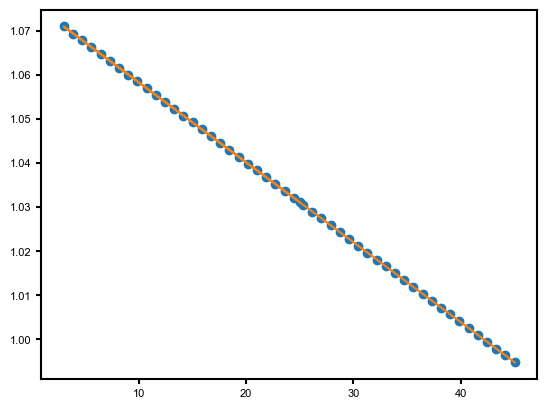

In [ ]:
test_idx = 5
col_idx  = 0
tk_coeff.iloc[0,col_idx] / 100 * tk_data.iloc[0, col_idx] * tk_data.index[test_idx] + tk_data.iloc[0,col_idx]
plt.plot(tk_data.index[:],tk_data.iloc[:,col_idx],'o')
plt.plot(tk_data.index[:],tk_coeff.iloc[0,col_idx] / 100 * tk_data.iloc[0, col_idx] * (tk_data.index[:]-25) + tk_data.iloc[0,col_idx])